In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import copy
import matplotlib.gridspec as gridspec
from matplotlib import colors
import seaborn as sns
import networkx as nx
import tqdm
plt.style.use('seaborn-whitegrid')
sns.set_palette('PuOr')

In [3]:
class Agent:
    def __init__(self, x, y, kind, preference, world):
        self.x = x
        self.y = y
        self.kind = kind
        self.preference = preference
        self.world = world
    
    def know_neighbours(self):
        self.neighbours = [self.world.coords[x % self.world.size, y % self.world.size]
                           for x, y in itertools.product(range(self.x-1, self.x+2),
                                                         range(self.y-1, self.y+2))]
    
    def swap(self, partner):
        self.kind, partner.kind = partner.kind, self.kind
    
    def happiness(self):
        neighbour_kinds = [n.kind for n in self.neighbours]
        numsame = neighbour_kinds.count(self.kind)
        numvacant = neighbour_kinds.count(0)
        if numvacant == 8:
            if self.vacant():
                return 1.0
            return 0.0
        return (numsame - 1) / (8 - numvacant)
    
    def dissatisfied(self):
        return self.happiness() < self.preference
    
    def vacant(self):
        return self.kind == 0

In [4]:
class World:
    def __init__(self, size, kinds, probs, preference):
        self.size = size
        self.preference = preference
        self.coords = self.populate_world(kinds, probs, preference)
        [a.know_neighbours() for row in self.coords for a in row]
        self.num_dissatisfied = size ** 2
        self.num_vacant = sum([a.vacant() for row in self.coords for a in row])
    
    def populate_world(self, kinds, probs, preference):
        return np.array([[Agent(x, y, np.random.choice(kinds, p=probs), preference, self) for y in range(self.size)] for x in range(self.size)])
    
    def atlas(self):
        return np.array([[a.kind for a in row] for row in self.coords])
    
    def happiness_distribution(self):
        return [a.happiness() for row in self.coords for a in row if not a.vacant()]
    
    def advance_turn(self):
        dissatisfied = []
        vacant = []
        for row in self.coords:
            for a in row:
                if a.vacant():
                    vacant.append(a)
                elif a.dissatisfied():
                    dissatisfied.append(a)
        self.num_dissatisfied = len(dissatisfied)
        np.random.shuffle(dissatisfied)
        np.random.shuffle(vacant)
        num_swap = min(self.num_dissatisfied, self.num_vacant)
        for indx in range(num_swap):
            dissatisfied[indx].swap(vacant[indx])
    
    def play(self, threshold=0.01):
        while self.num_dissatisfied / (self.size ** 2) > threshold:
            self.advance_turn()

In [5]:
class WorldArchiving(World):
    def __init__(self, size, kinds, probs, preference):
        super(WorldArchiving, self).__init__(size, kinds, probs, preference)
        self.archived_atlases = []
    
    def archive(self):
        self.archived_atlases.append(copy.deepcopy(self.atlas()))

    def play(self, threshold=0.01):
        self.archive()
        while self.num_dissatisfied / (self.size ** 2) > threshold:
            self.advance_turn()
            self.archive()

In [6]:
def plot_atlas(w, turn):
    num_turns = len(w.archived_atlases)
    cmap = colors.ListedColormap(['white', '#FFCC1A', '#630081'])
    fig, ax = plt.subplots(1, figsize=(11, 11))
    ax.pcolor(w.archived_atlases[turn], cmap=cmap)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()
    fig.savefig('atlas_' + str(turn))

In [7]:
def number_connected_components(w):
    temp = np.matrix(copy.deepcopy(w.atlas()))
    nodes = ['(' + str(x) + ', ' + str(y) + ')' for x in range(w.size) for y in range(w.size) if temp[x, y] != 0]
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for x in range(w.size):
        for y in range(w.size):
            if temp[(x+1) % w.size, y] != 0 and temp[x, y] != 0:
                if temp[(x+1) % w.size, y] == temp[x, y]:
                    G.add_edge('(' + str(x) + ', ' + str(y) + ')', '(' + str((x+1) % w.size) + ', ' + str(y) + ')')
            if temp[x, (y+1) % w.size] != 0 and temp[x, y] != 0:
                if temp[x, (y+1) % w.size] == temp[x, y]:
                    G.add_edge('(' + str(x) + ', ' + str(y) + ')', '(' + str(x) + ', ' + str((y+1) % w.size) + ')')
    return nx.number_connected_components(G)

# Preference Experiments:
  + Vary preference: 0.01 -- 0.75 in steps of 0.01

In [8]:
num_trials = 10

In [9]:
np.random.seed(0)
worlds = {str(round(pref, 4)): [World(40, [0, 1, 2], [0.1, 0.45, 0.45], pref) for trial in range(num_trials)] for pref in [i*0.01 for i in range(76)]}

In [10]:
for k, trial in tqdm.tqdm(list(itertools.product(worlds, range(num_trials)))):
    worlds[k][trial].play(threshold=0.00005)

100%|██████████| 760/760 [05:36<00:00,  2.26it/s]


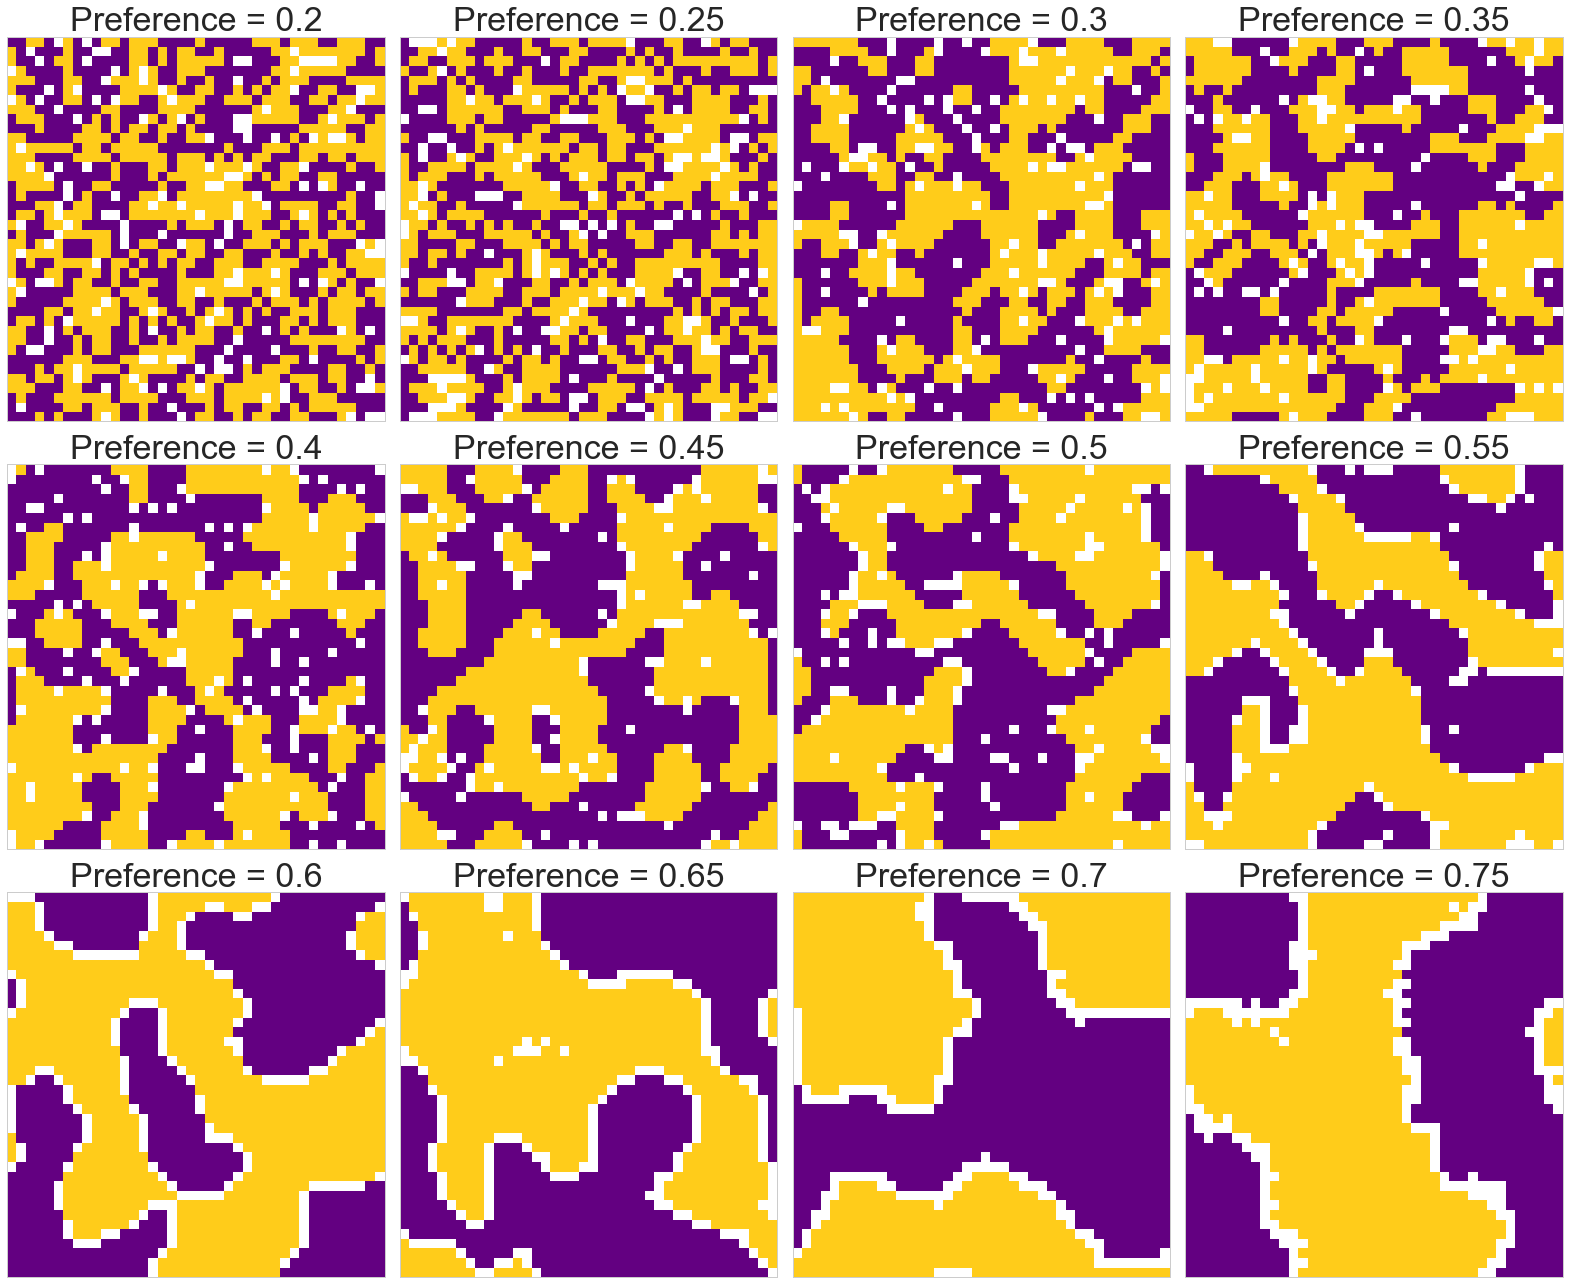

In [11]:
nrows = 3
ncols = 4
cmap = colors.ListedColormap(['white', '#FFCC1A', '#630081'])
fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 18))
for i, k in enumerate(['0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75',]):
    axarr[i // ncols, i % ncols].pcolor(worlds[k][0].atlas(), cmap=cmap)
    axarr[i // ncols, i % ncols].set_xticks([])
    axarr[i // ncols, i % ncols].set_yticks([])
    axarr[i // ncols, i % ncols].set_title('Preference = ' + str(k), fontsize=34)
plt.tight_layout()
fig.savefig('increase_preference')

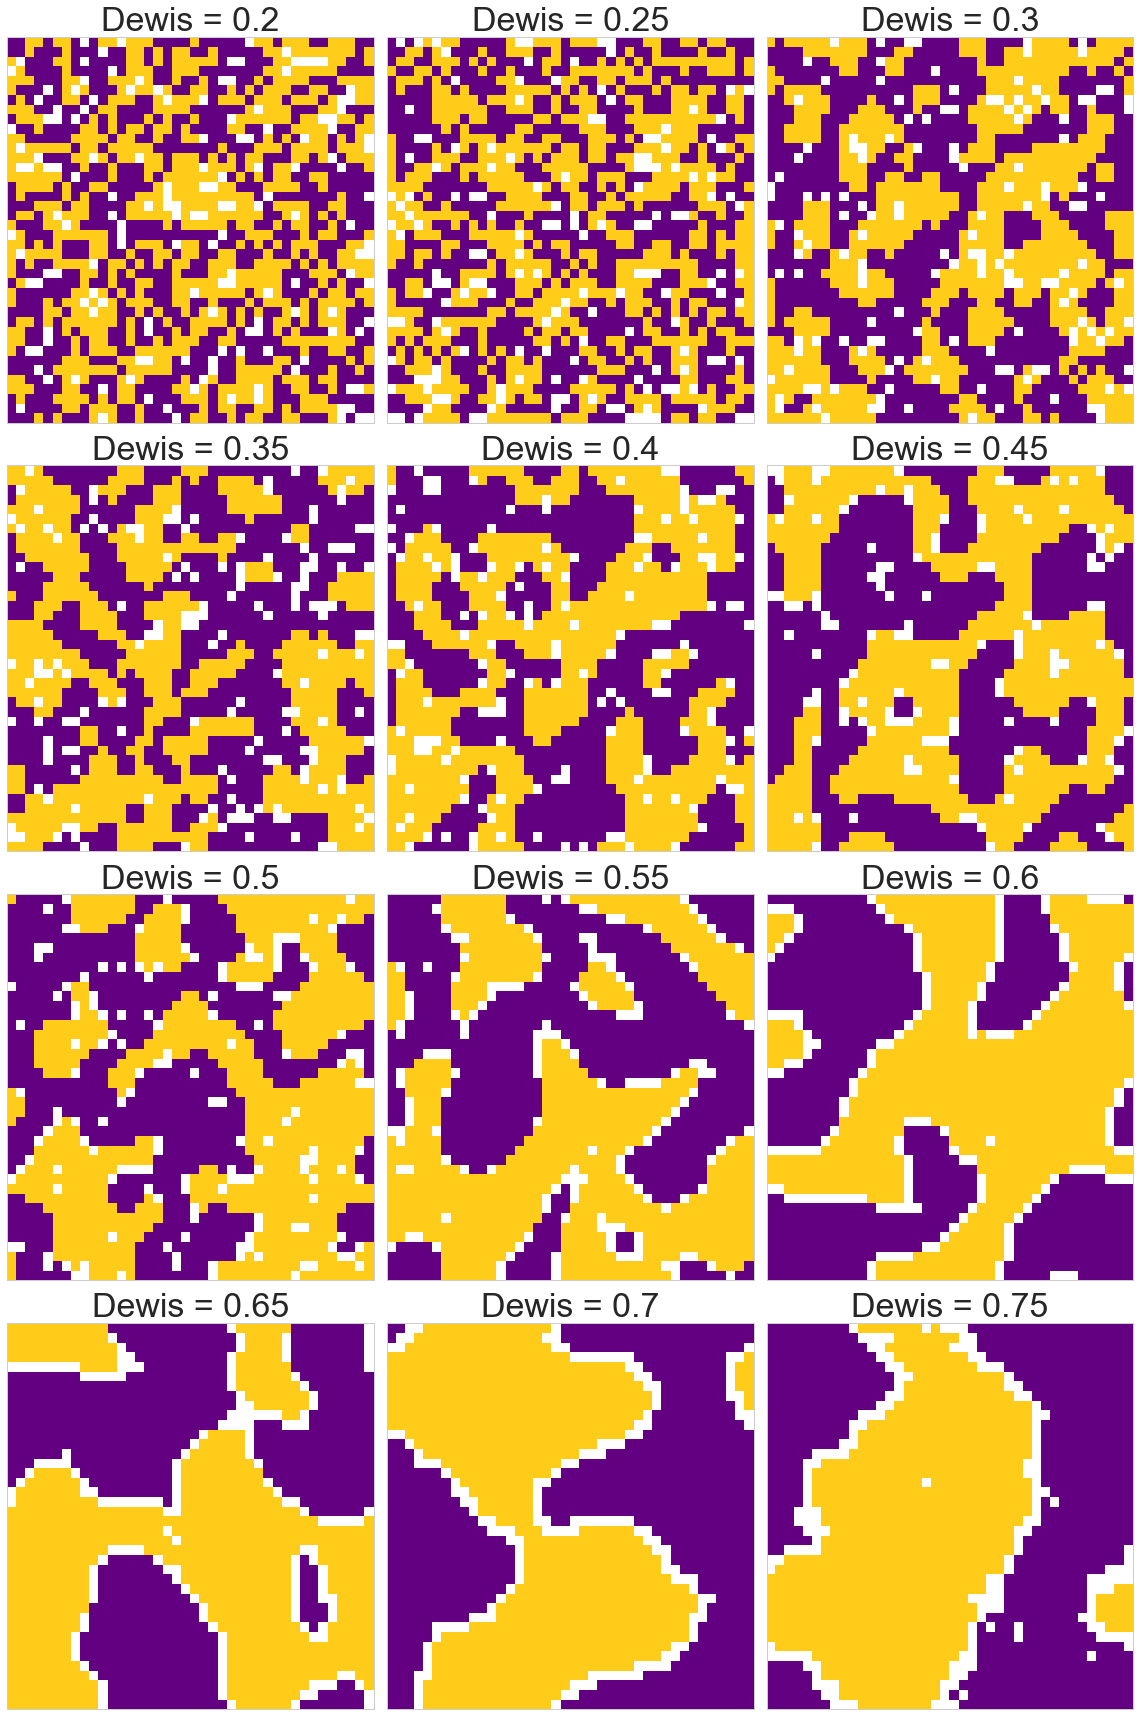

In [12]:
nrows = 4
ncols = 3
cmap = colors.ListedColormap(['white', '#FFCC1A', '#630081'])
fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 24))
for i, k in enumerate(['0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7', '0.75',]):
    axarr[i // ncols, i % ncols].pcolor(worlds[k][0].atlas(), cmap=cmap)
    axarr[i // ncols, i % ncols].set_xticks([])
    axarr[i // ncols, i % ncols].set_yticks([])
    axarr[i // ncols, i % ncols].set_title('Dewis = ' + str(k), fontsize=34)
plt.tight_layout()
fig.savefig('increase_preference_cy')

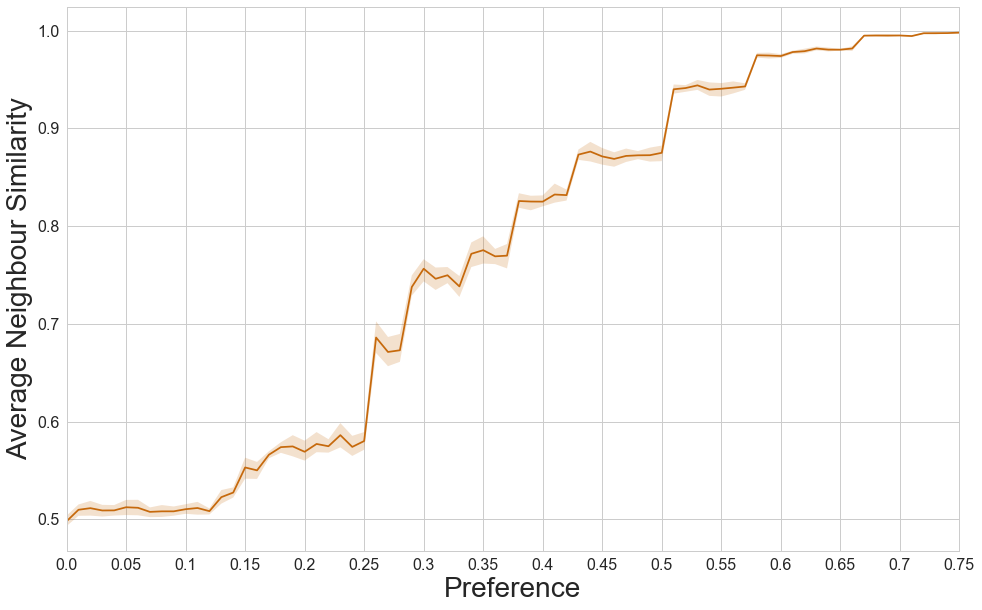

In [12]:
fig = plt.figure(figsize=(16, 10))
sns.tsplot([[np.mean(worlds[k][trial].happiness_distribution()) for k in sorted(worlds)] for trial in range(num_trials)], ci=99);
ticks = np.linspace(0, 75, 16)
plt.xticks(ticks, [list(sorted(worlds.keys()))[int(t)] for t in ticks])
plt.xlabel('Preference', fontsize=28)
plt.ylabel('Average Neighbour Similarity', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('preference_meanhappiness')

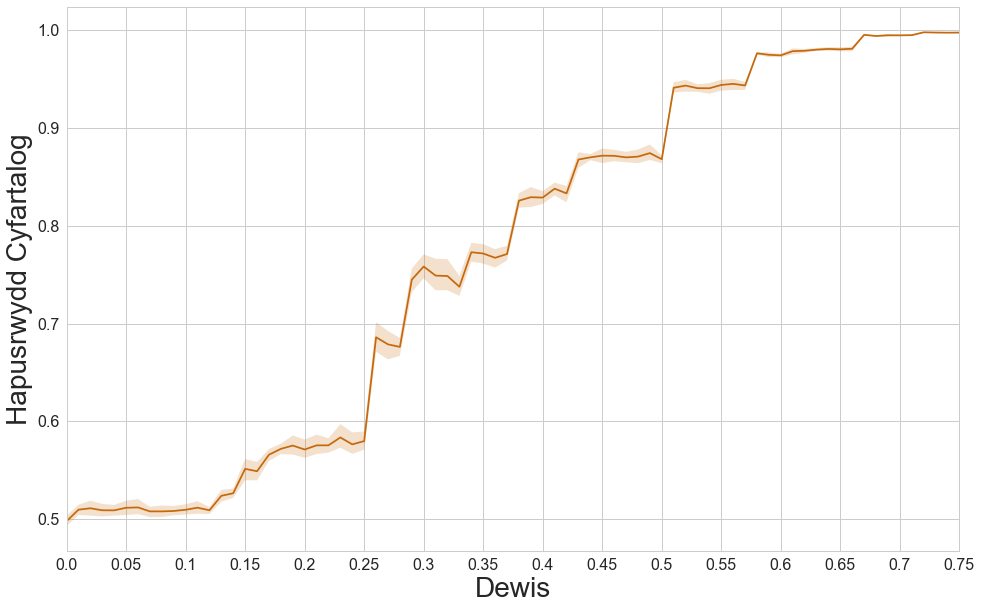

In [18]:
fig = plt.figure(figsize=(16, 10))
sns.tsplot([[np.mean(worlds[k][trial].happiness_distribution()) for k in sorted(worlds)] for trial in range(num_trials)], ci=99);
ticks = np.linspace(0, 75, 16)
plt.xticks(ticks, [list(sorted(worlds.keys()))[int(t)] for t in ticks])
plt.xlabel('Dewis', fontsize=28)
plt.ylabel('Hapusrwydd Cyfartalog', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('preference_meanhappiness_cy')

In [13]:
components = [[number_connected_components(worlds[k][trial]) for trial in range(num_trials)] for k in sorted(worlds)]

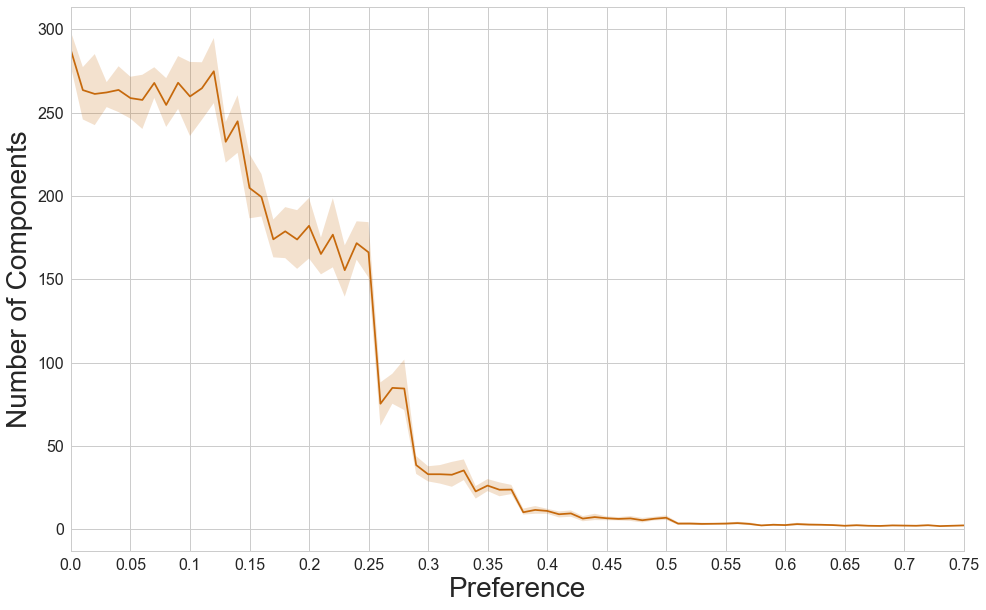

In [14]:
fig = plt.figure(figsize=(16, 10))
sns.tsplot(np.transpose(components), ci=99)
ticks = np.linspace(0, 75, 16)
plt.xticks(ticks, [list(sorted(worlds.keys()))[int(t)] for t in ticks])
plt.xlabel('Preference', fontsize=28)
plt.ylabel('Number of Components', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('preference_components')

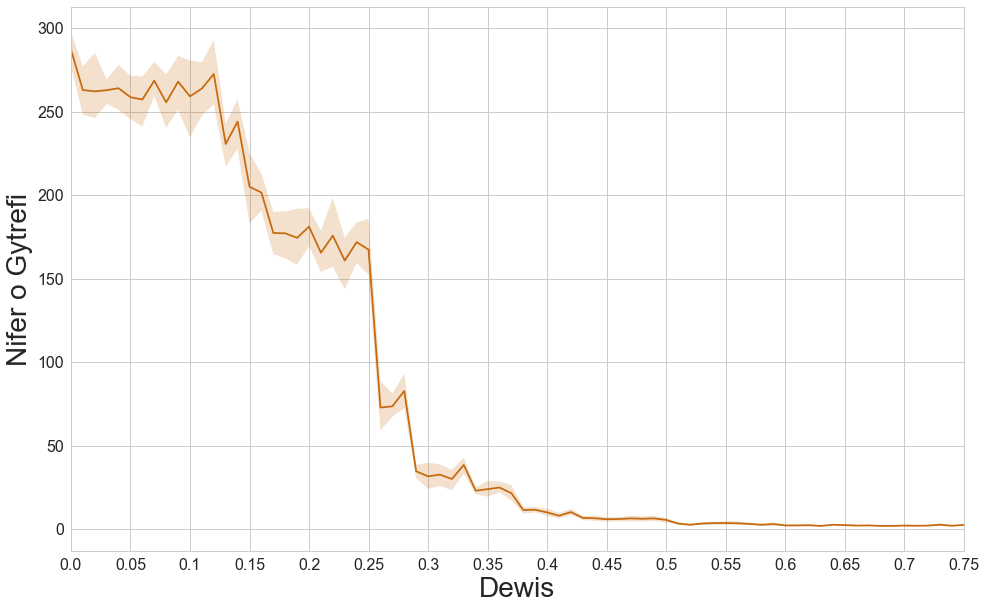

In [21]:
fig = plt.figure(figsize=(16, 10))
sns.tsplot(np.transpose(components), ci=99)
ticks = np.linspace(0, 75, 16)
plt.xticks(ticks, [list(sorted(worlds.keys()))[int(t)] for t in ticks])
plt.xlabel('Dewis', fontsize=28)
plt.ylabel('Nifer o Gytrefi', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('preference_components_cy')

# Creating the GIF

In [45]:
np.random.seed(0)
w = WorldArchiving(80, [0, 1, 2], [0.1, 0.45, 0.45], 0.7)

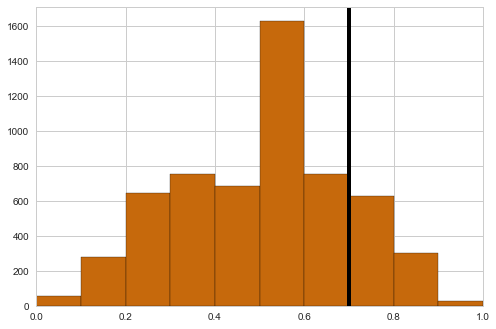

In [46]:
fig, ax = plt.subplots(1)
ax.hist(w.happiness_distribution(), edgecolor='black')
ymin, ymax = ax.get_ylim()
ax.vlines(0.7, ymin, ymax, linewidth=4)
ax.set_ylim(ymin, ymax)
ax.set_xlim(0, 1)
fig.savefig('happynessdist_before')

In [47]:
w.play(threshold=0.05)

 10%|▉         | 20/209 [00:09<01:47,  1.75it/s]/Users/geraintianpalmer/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████| 209/209 [01:36<00:00,  1.83it/s]


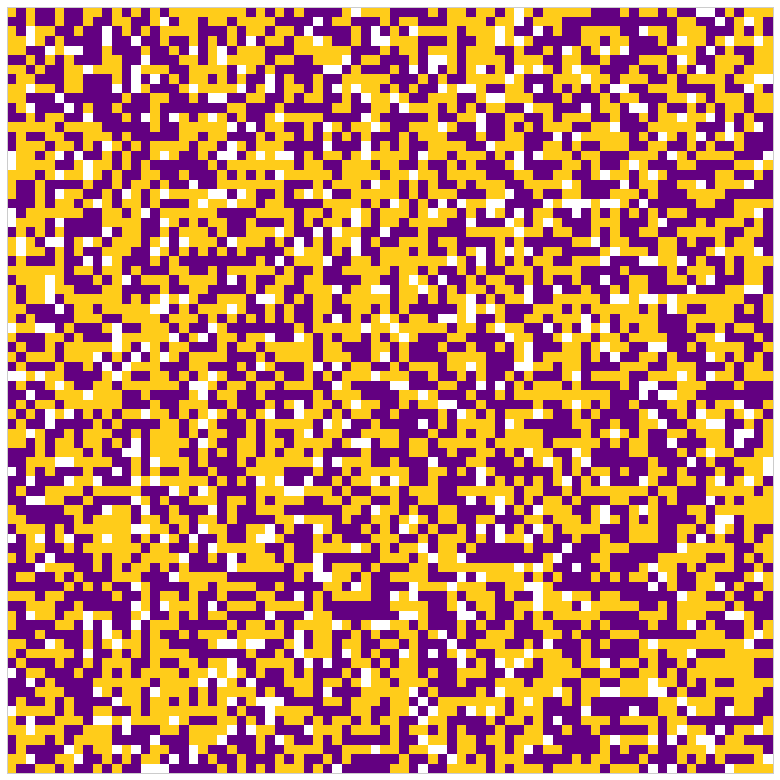

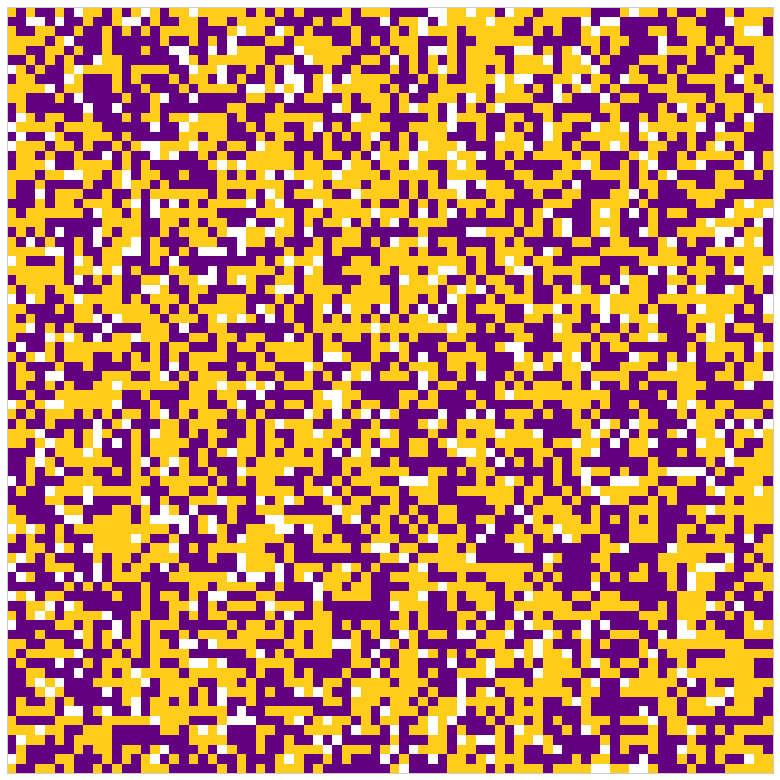

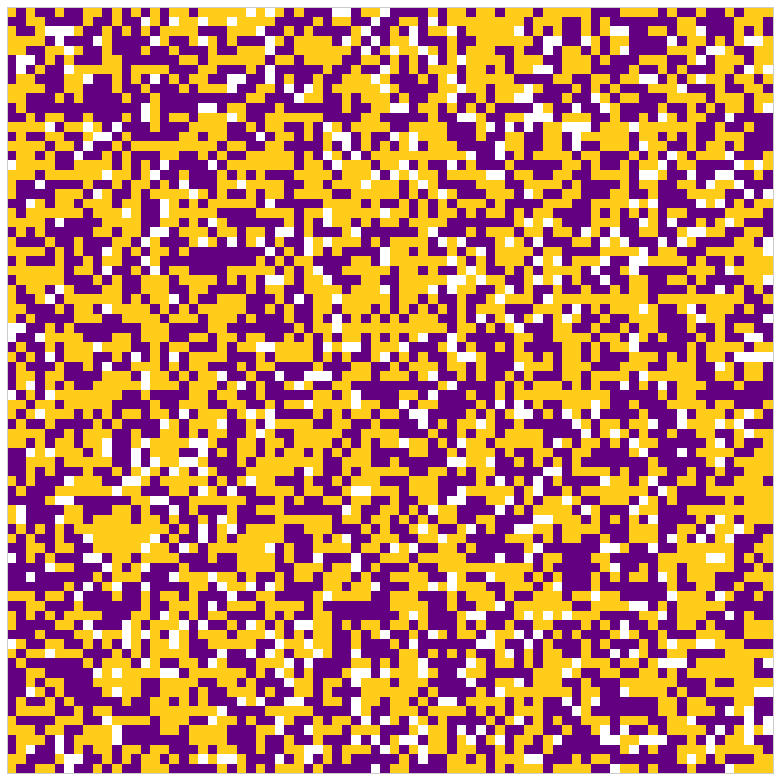

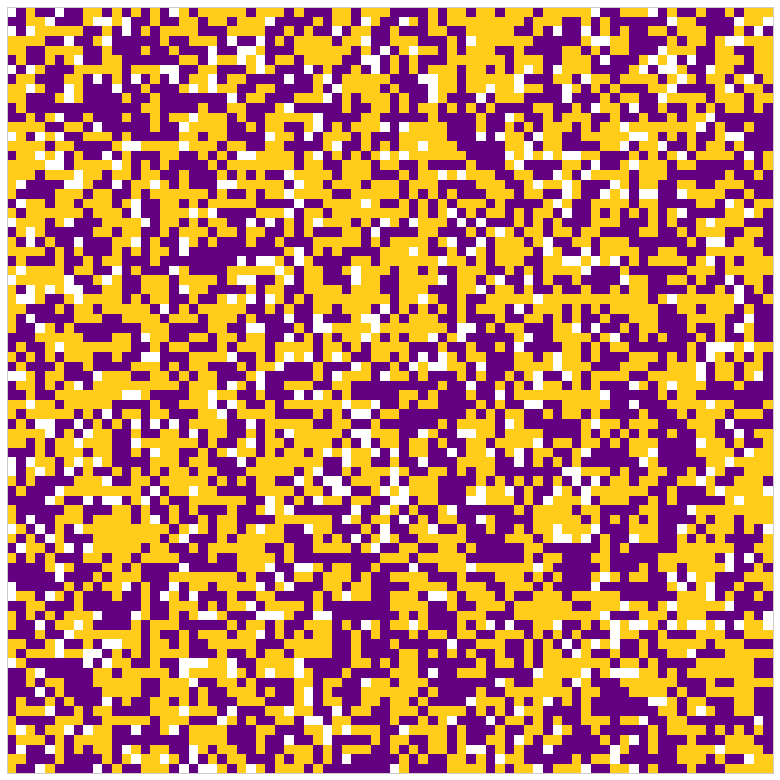

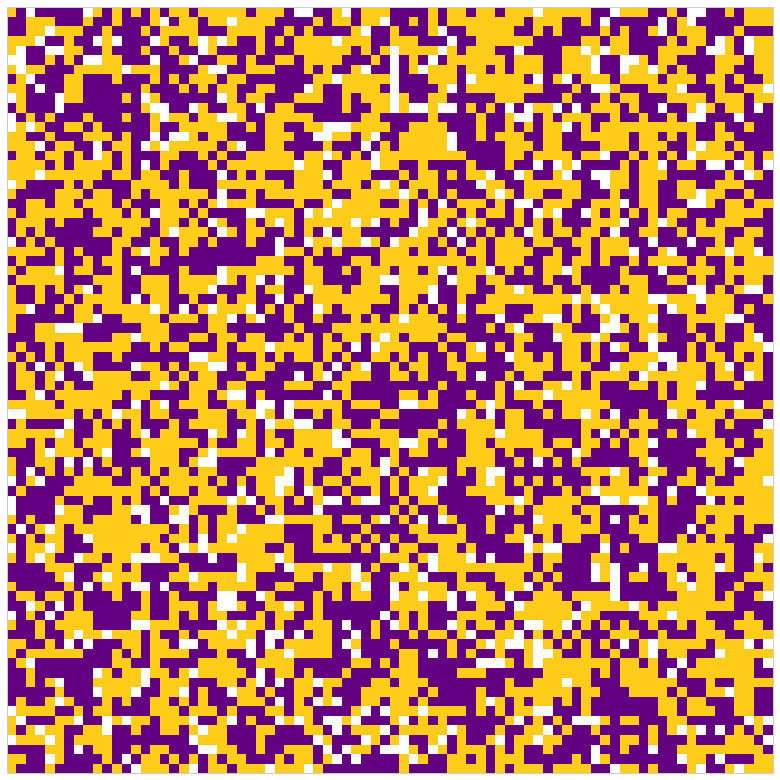

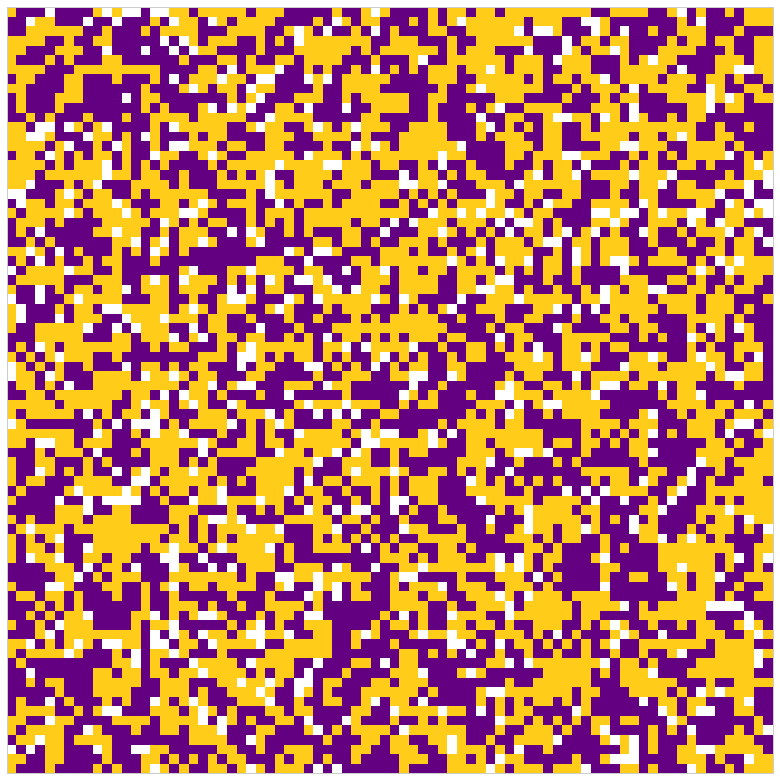

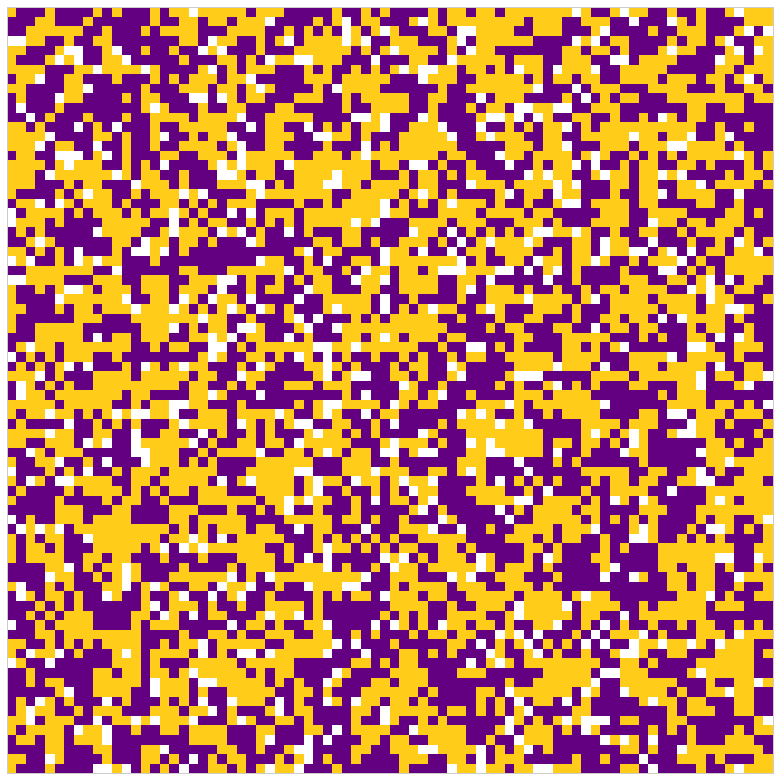

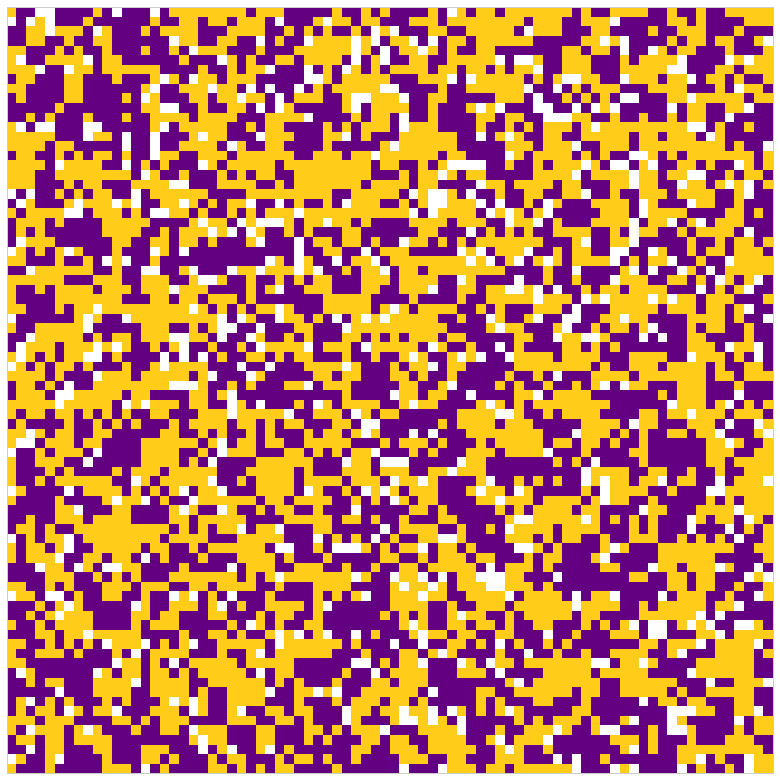

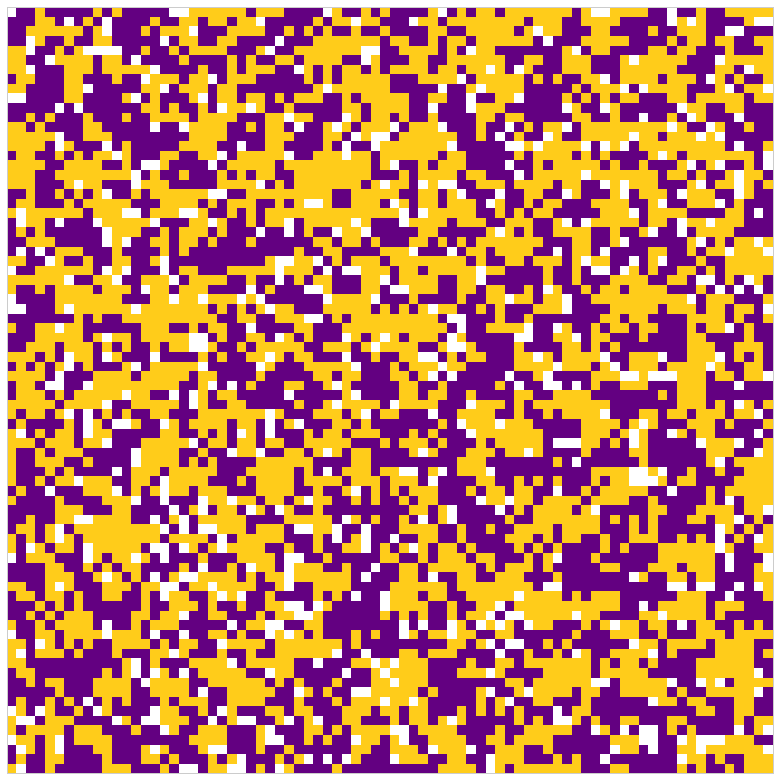

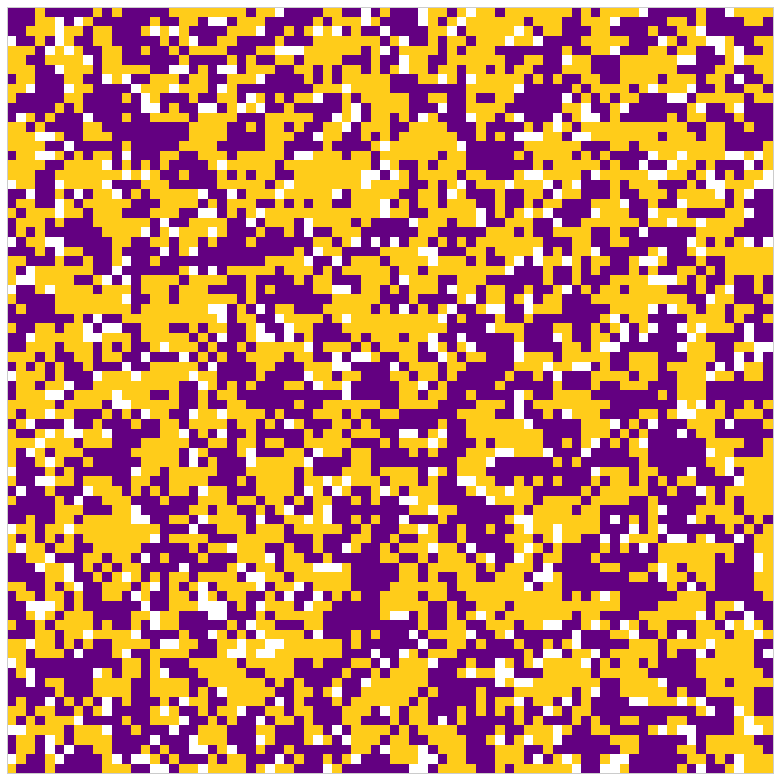

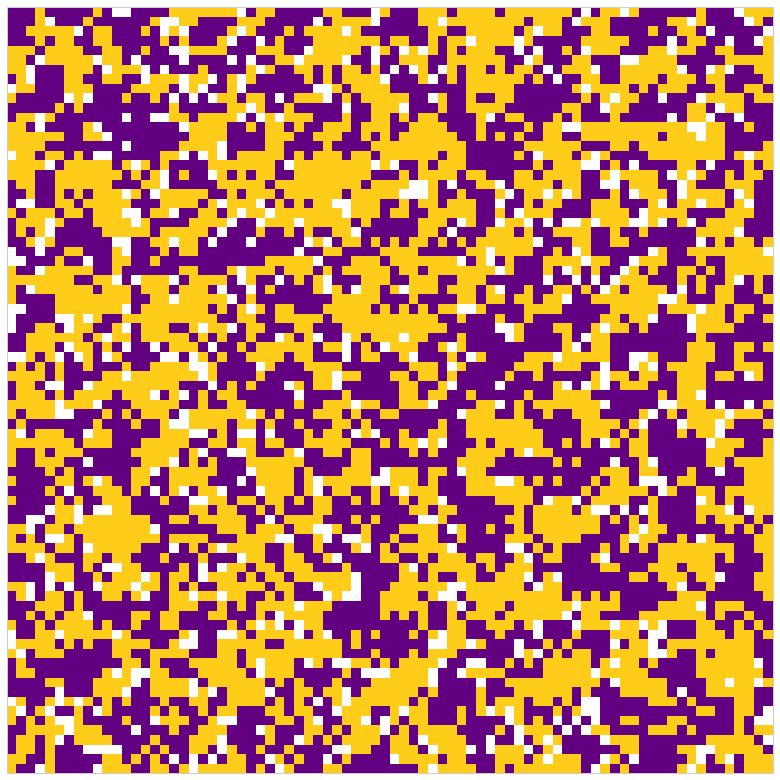

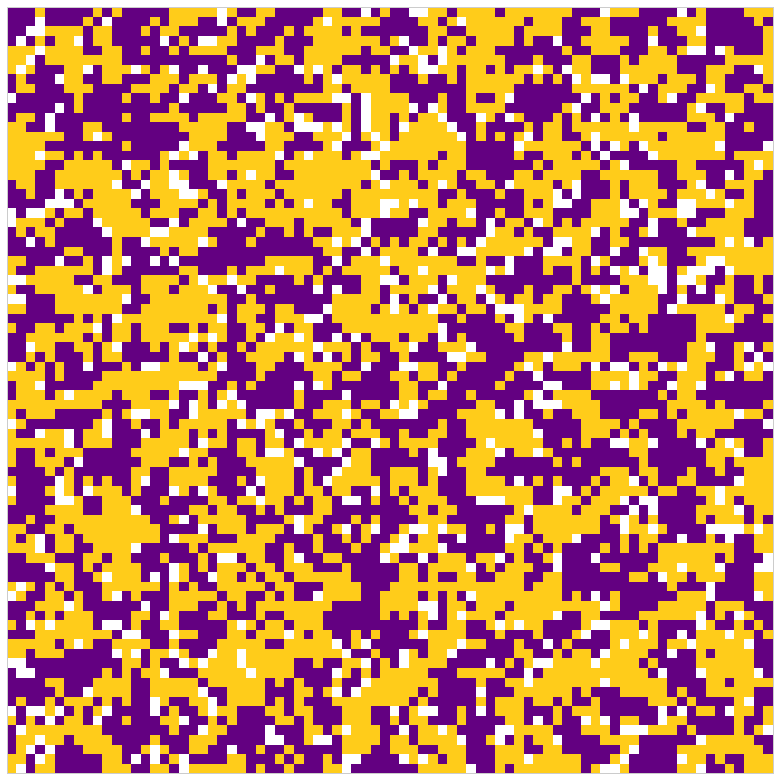

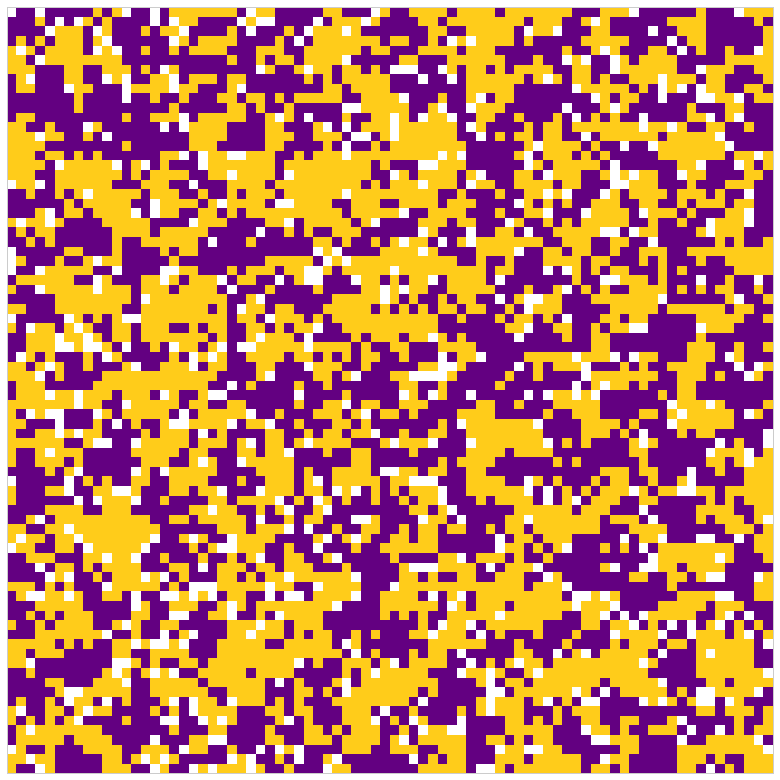

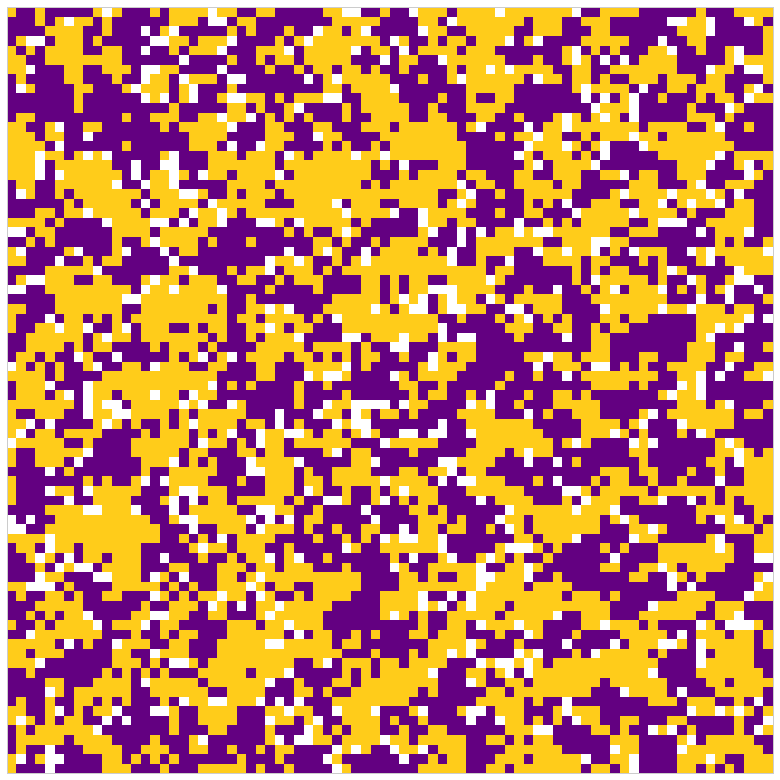

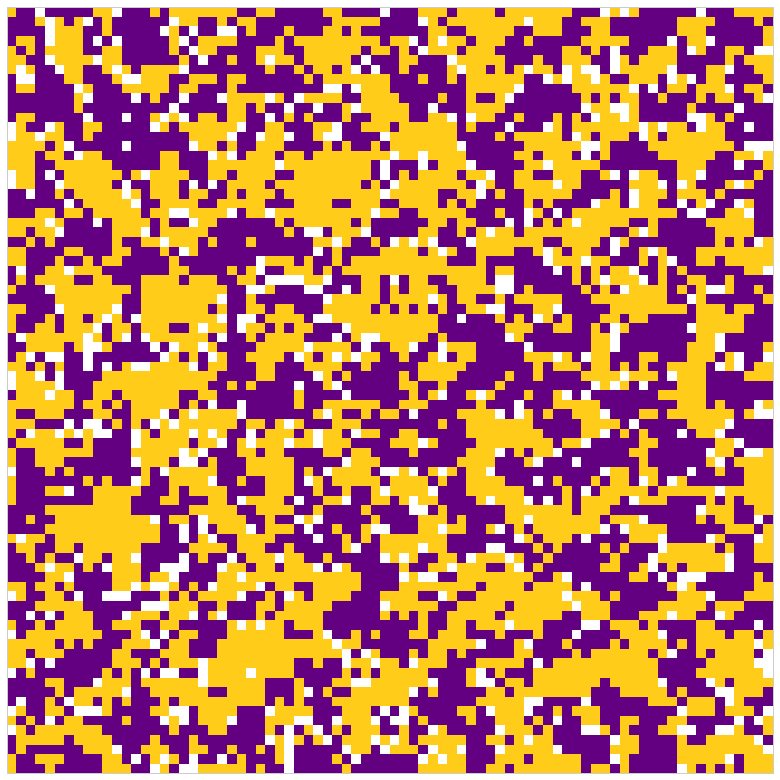

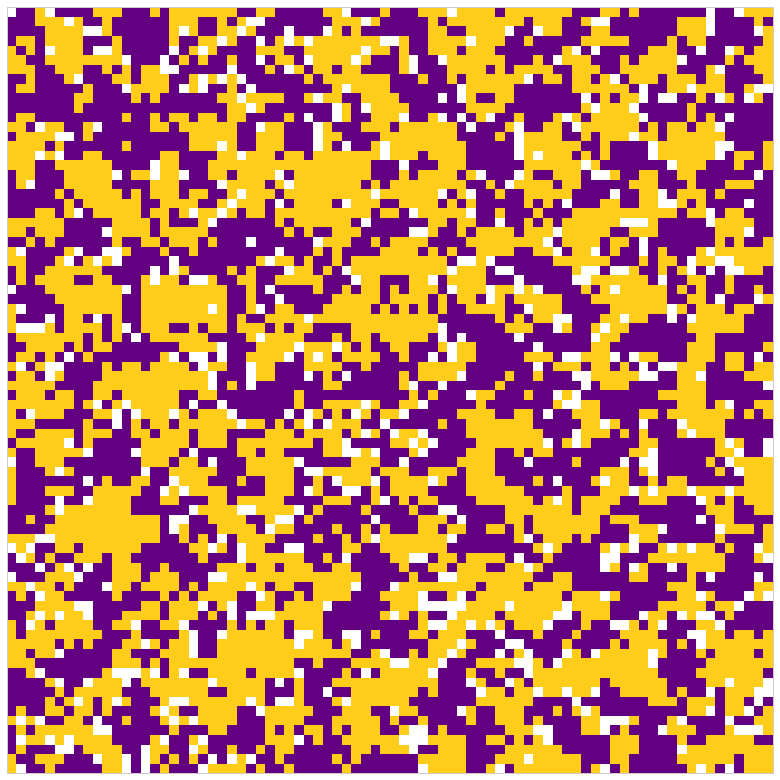

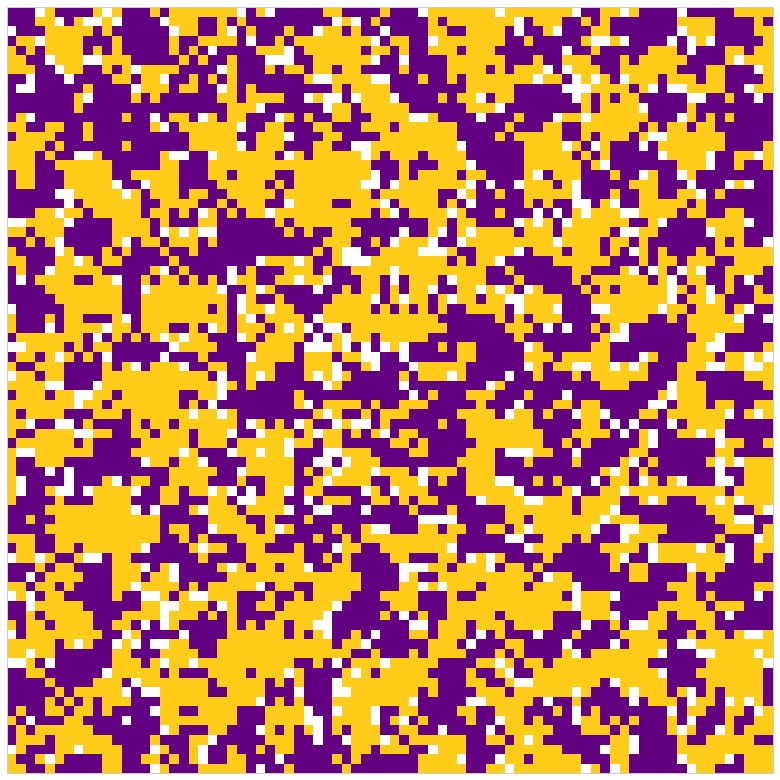

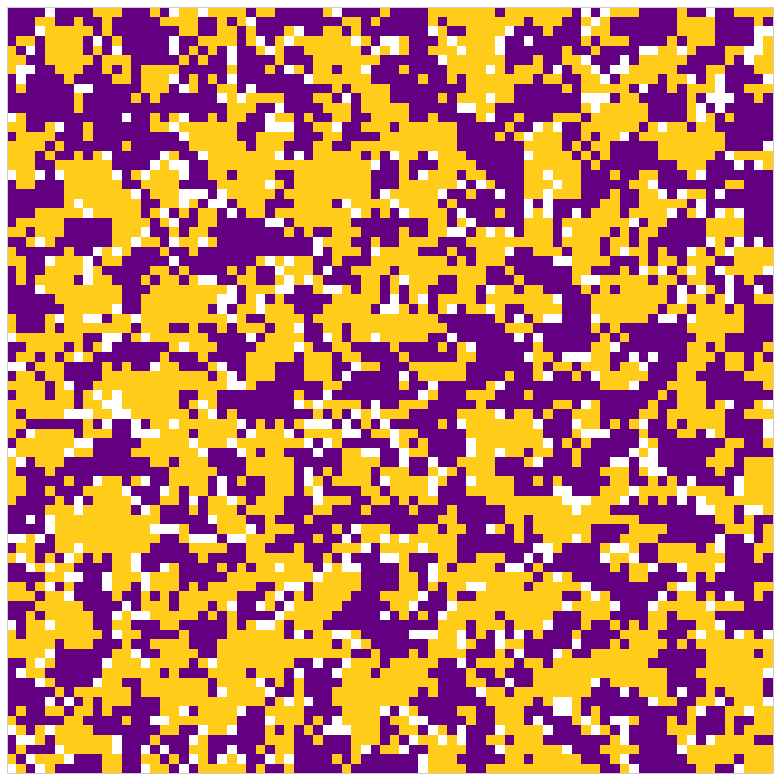

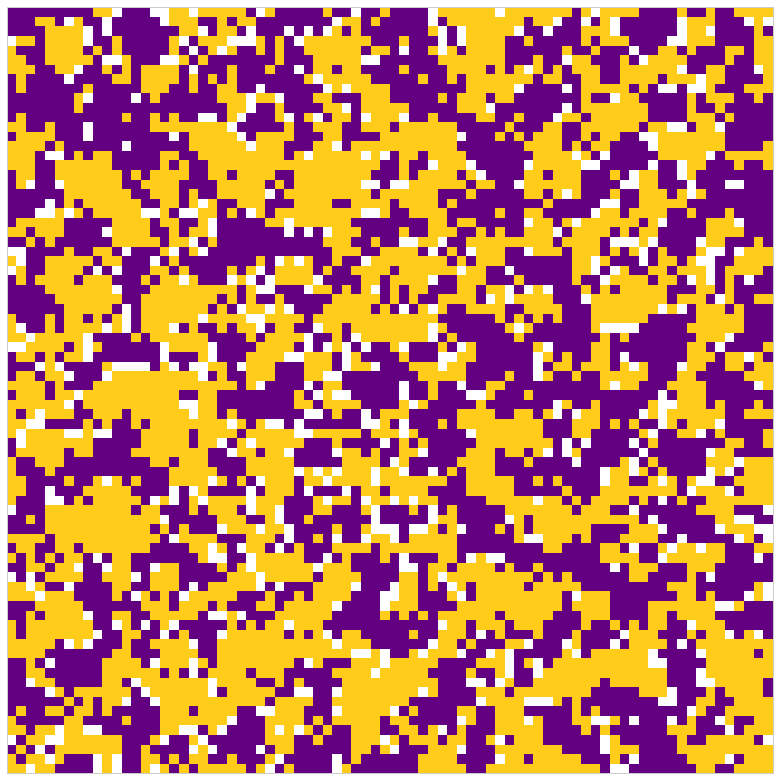

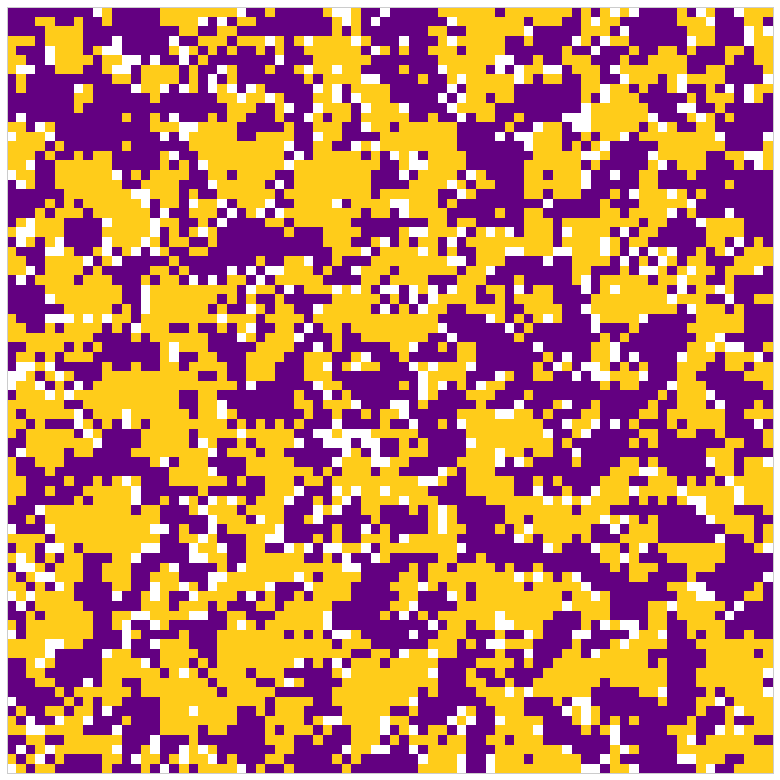

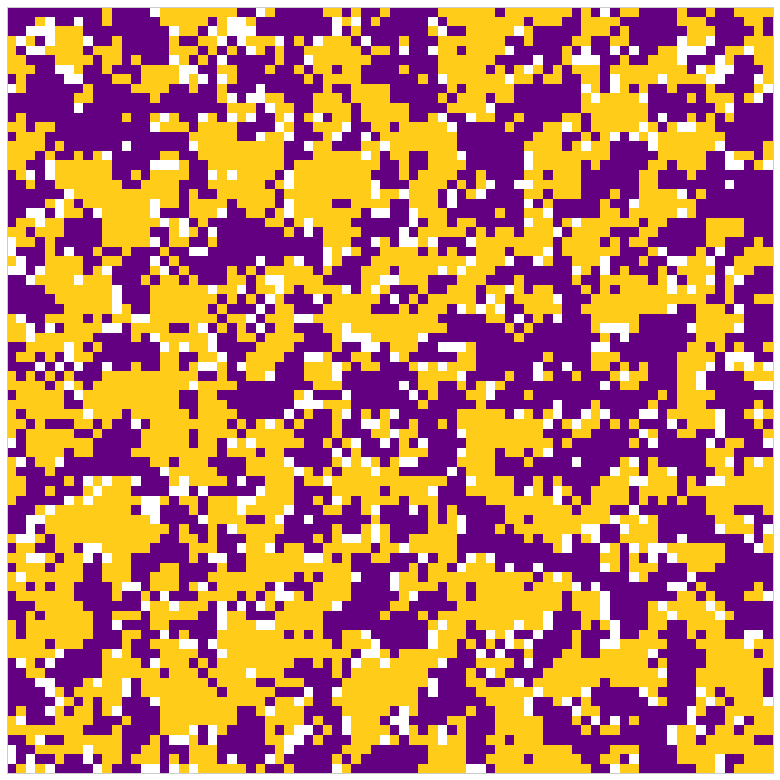

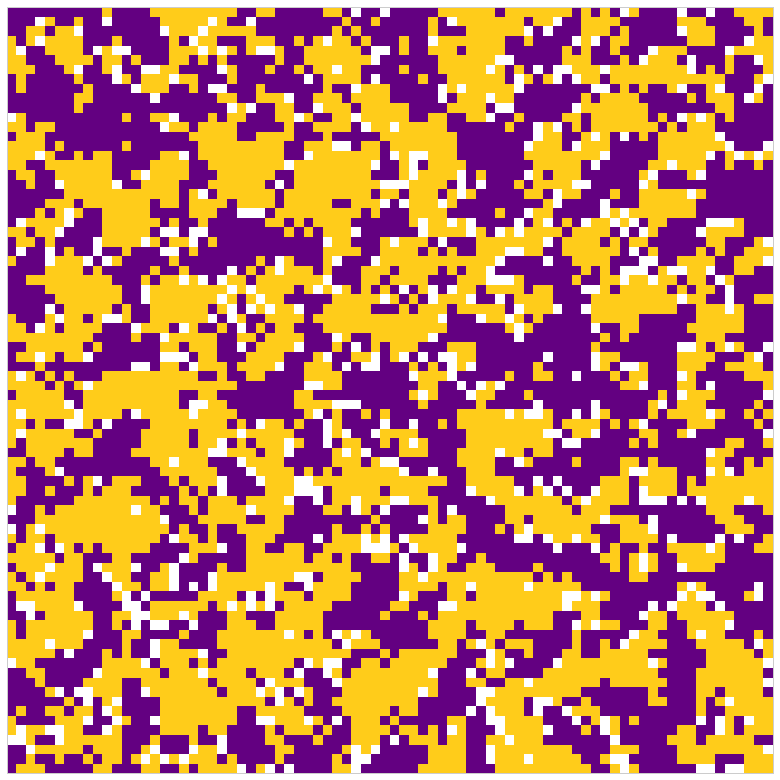

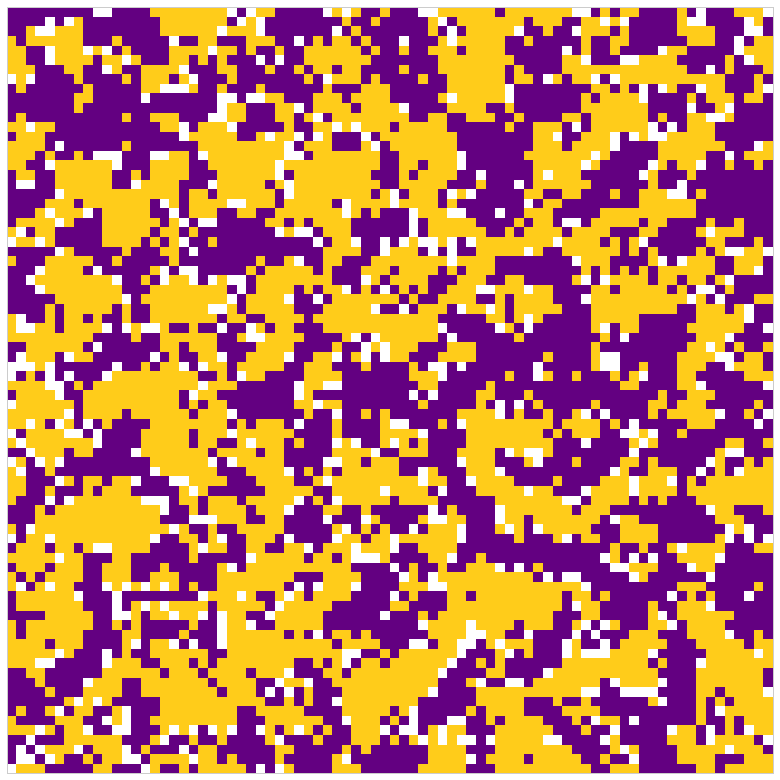

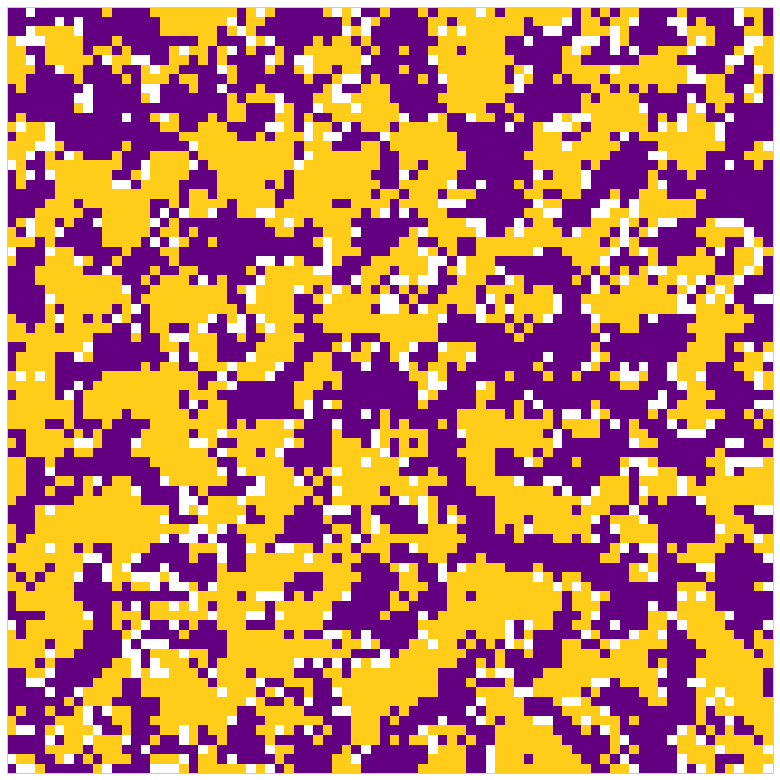

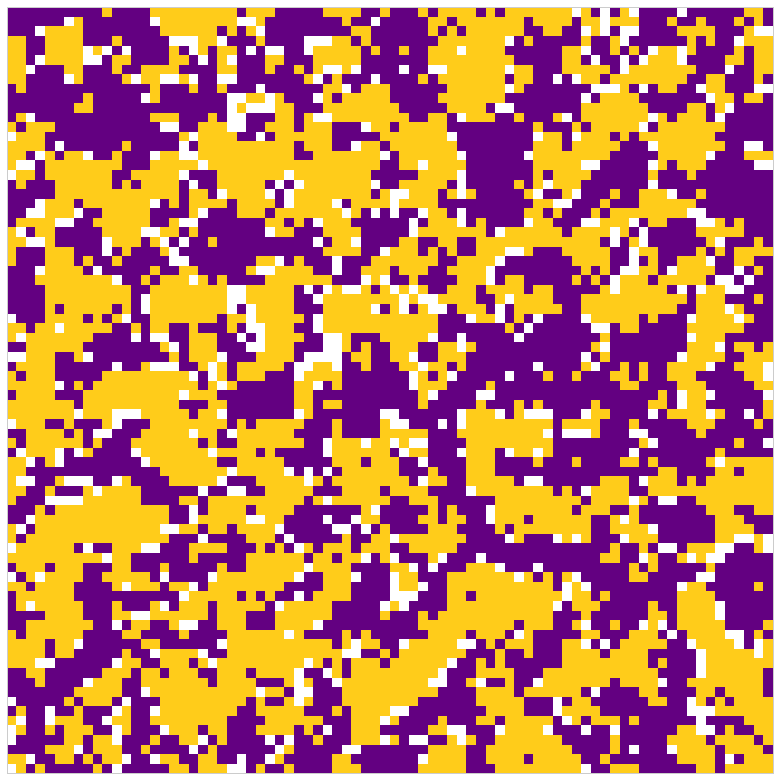

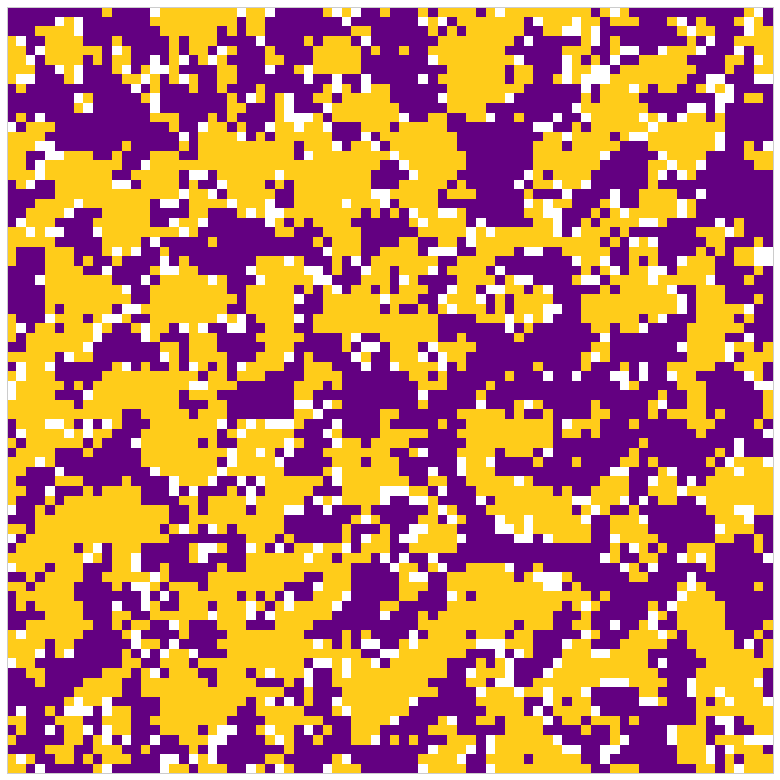

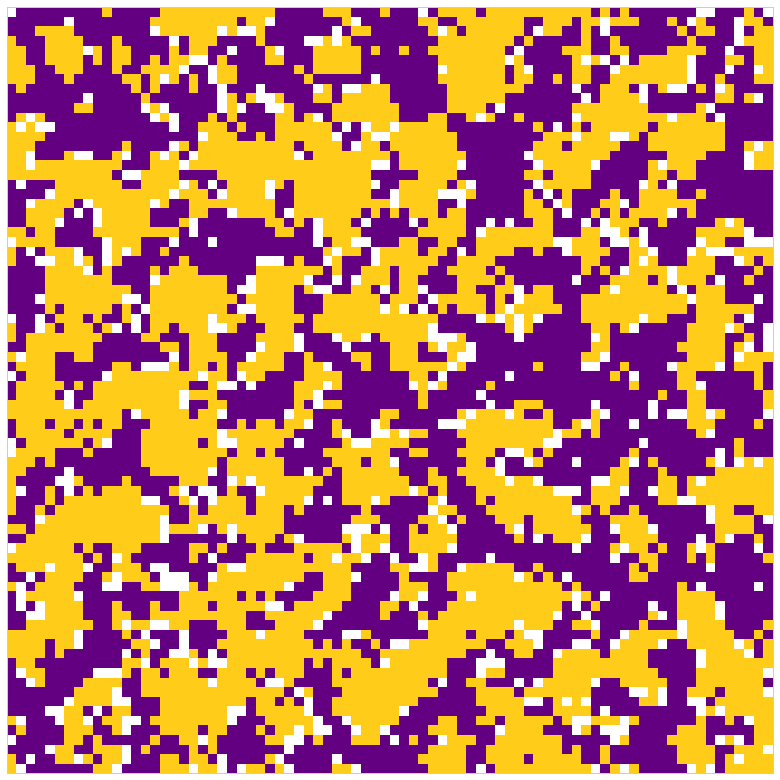

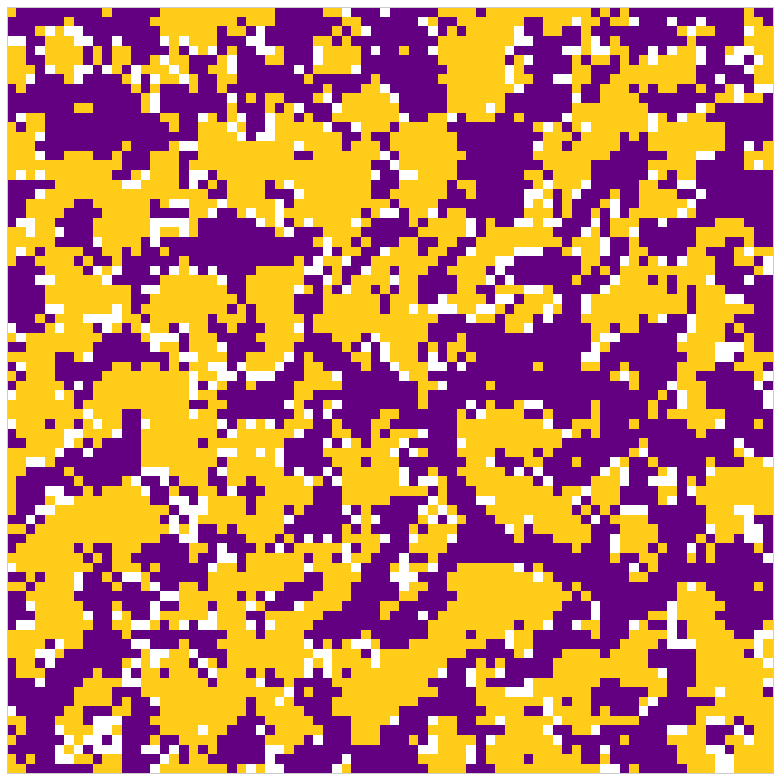

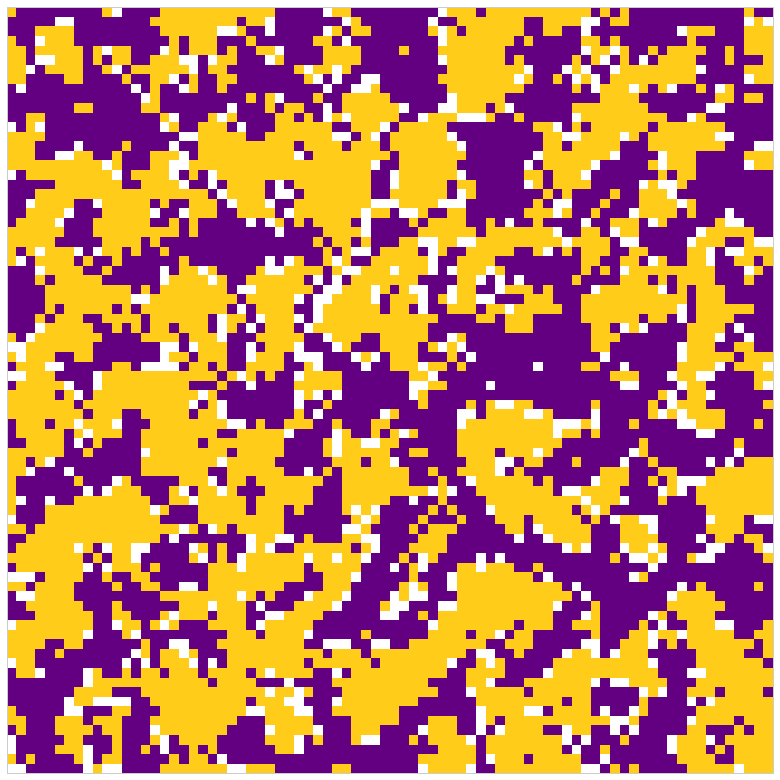

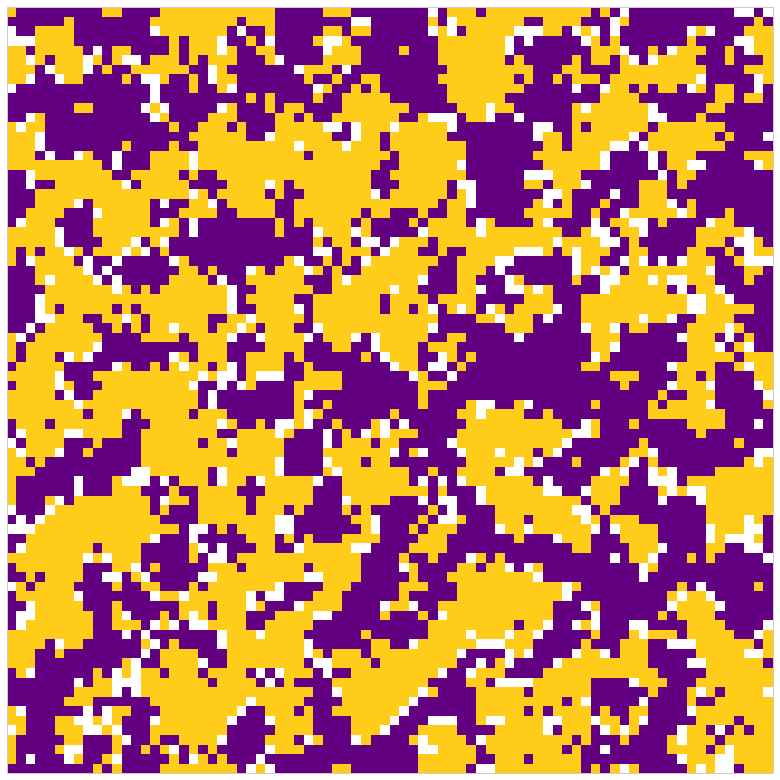

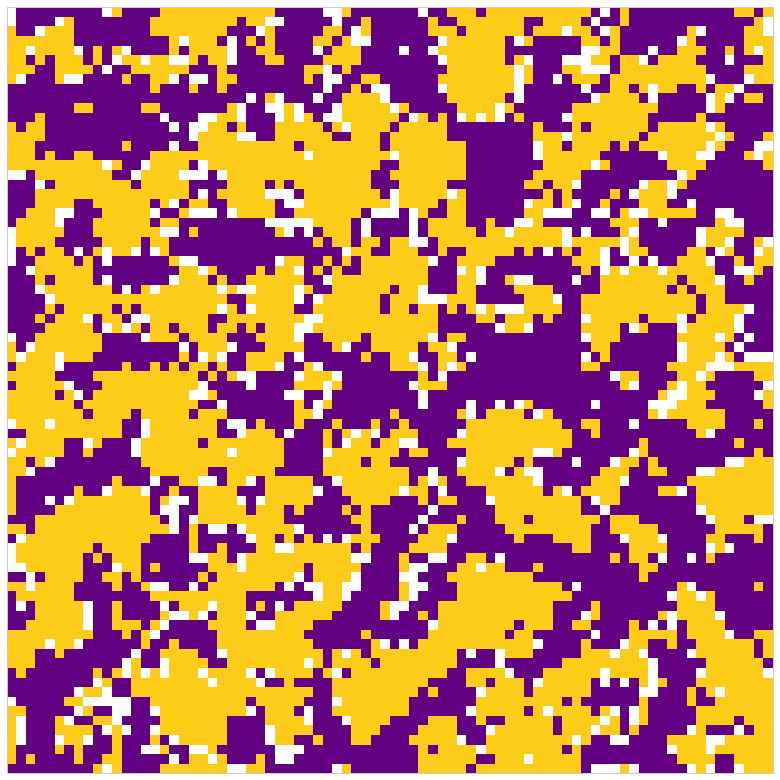

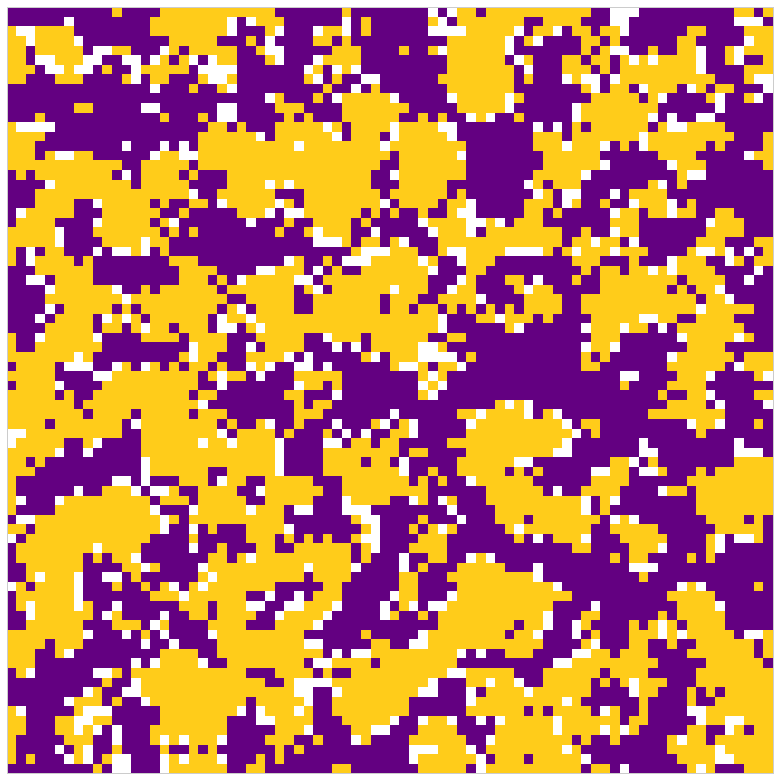

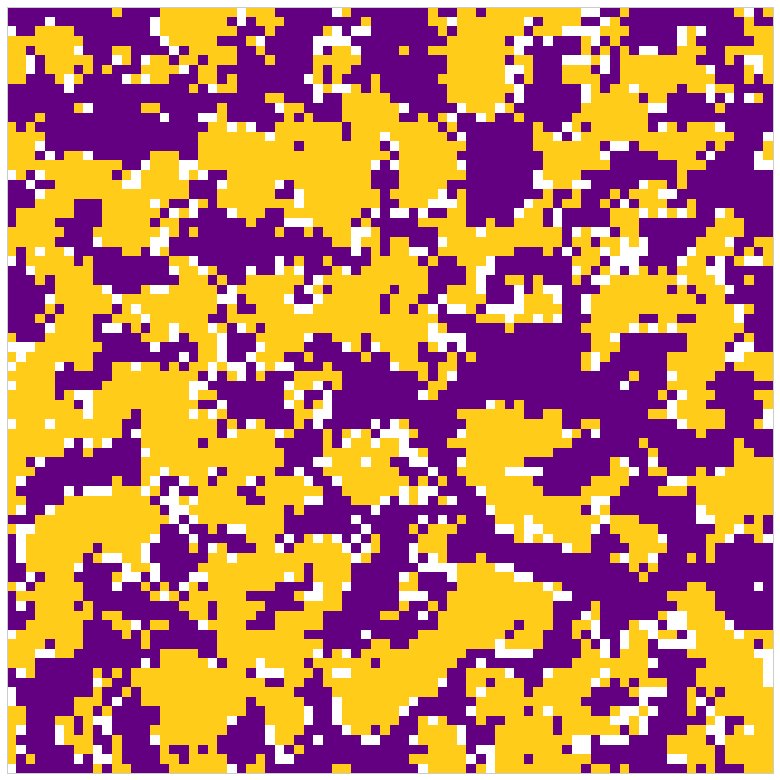

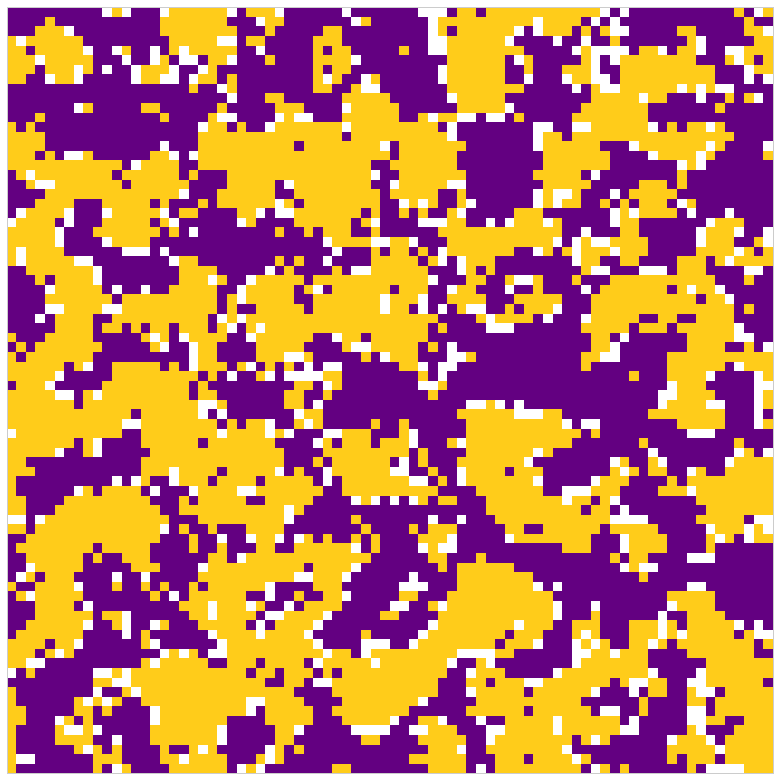

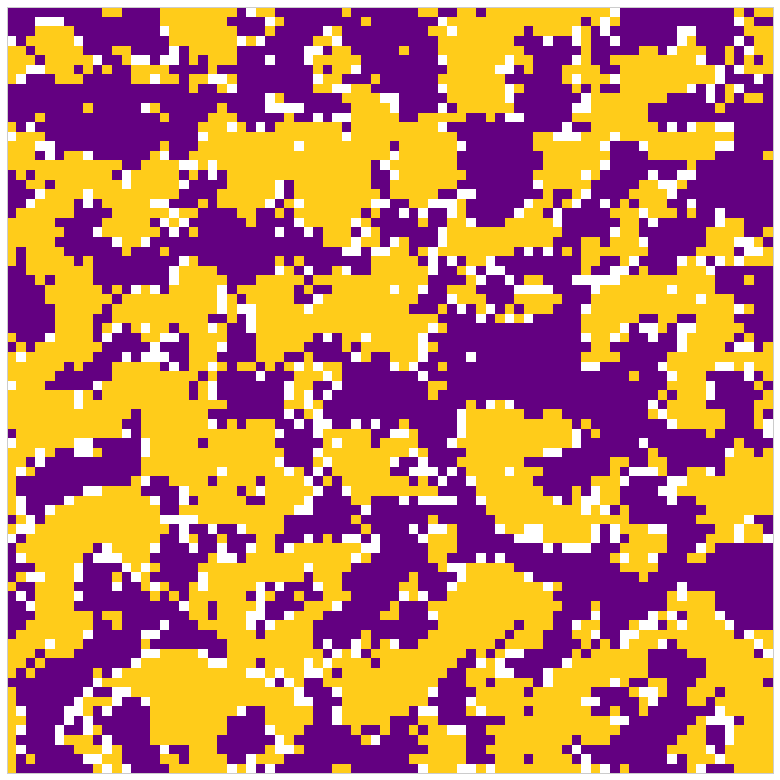

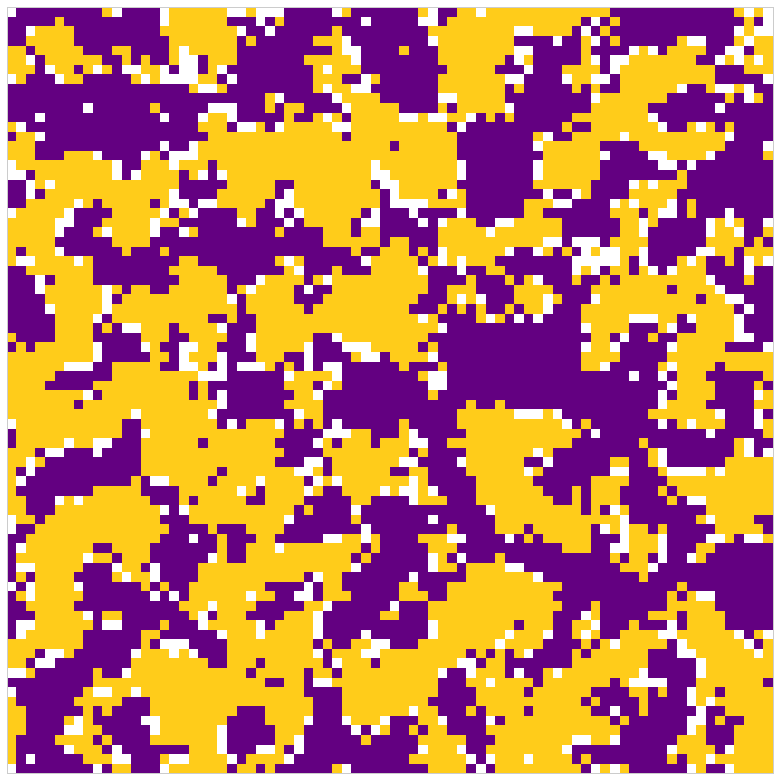

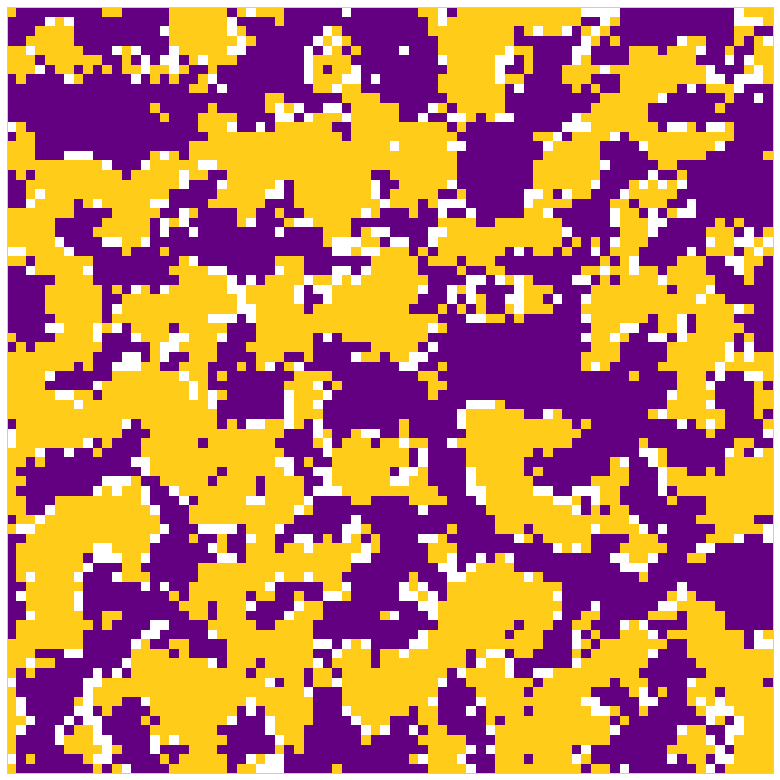

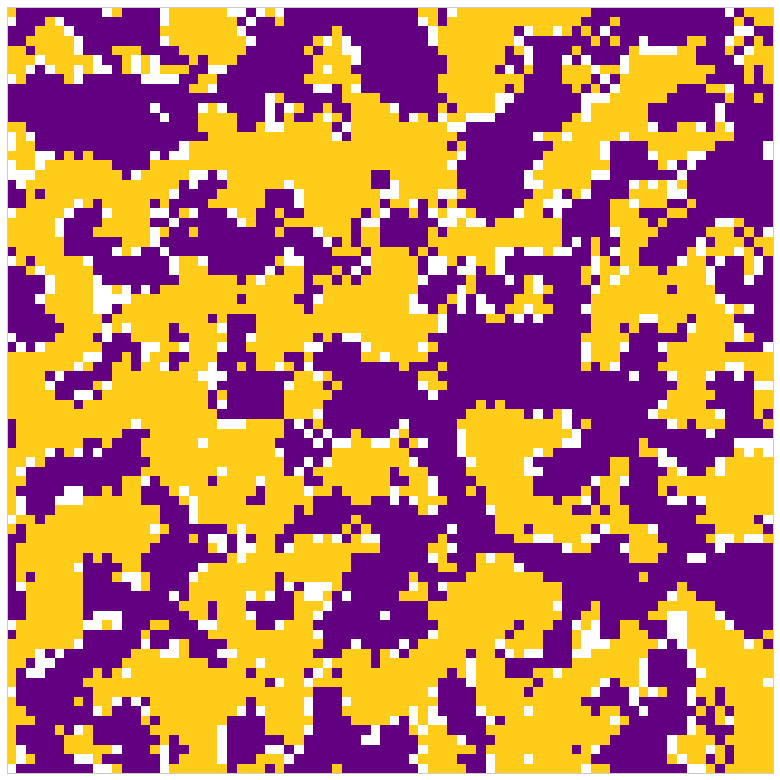

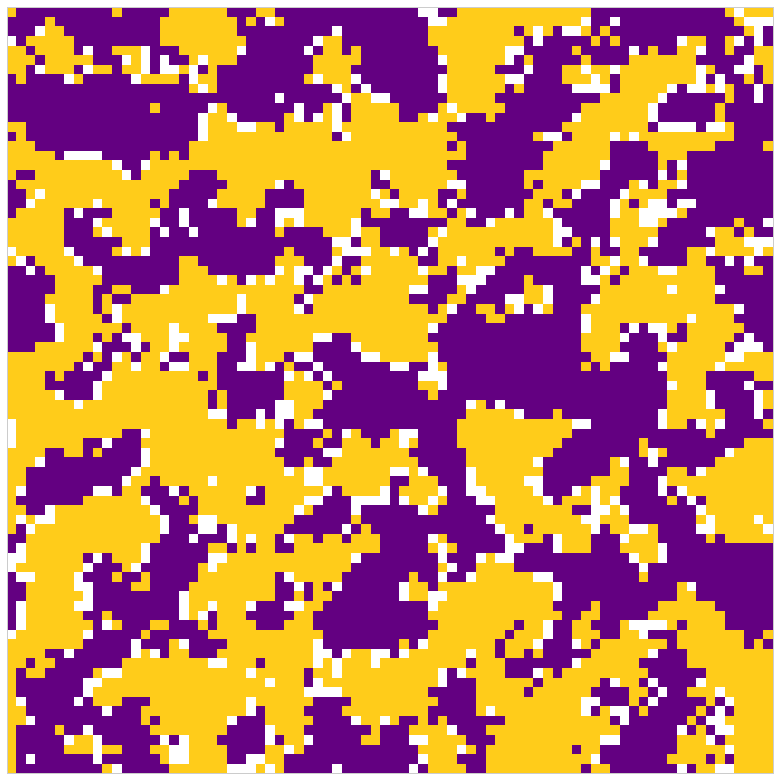

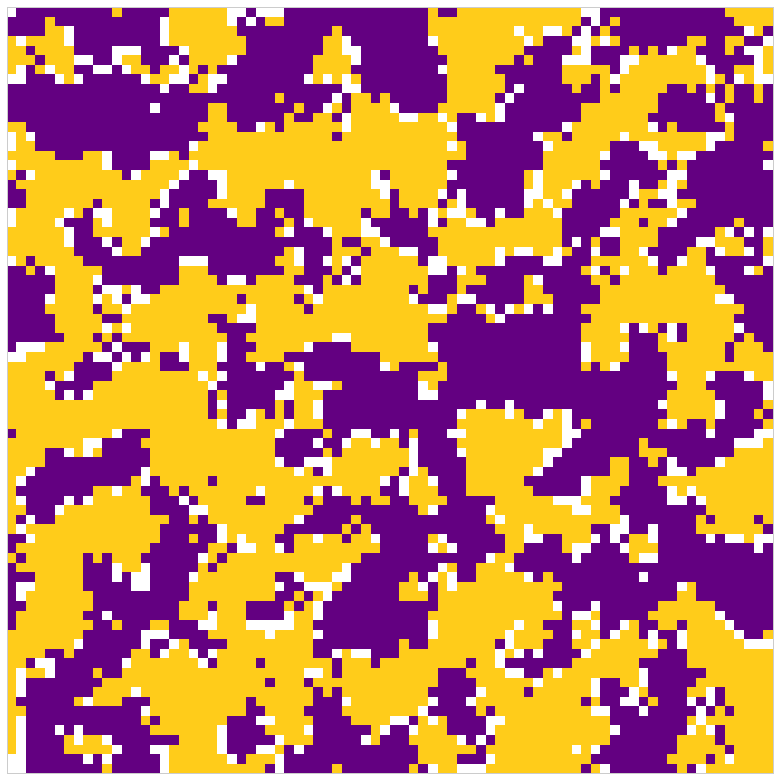

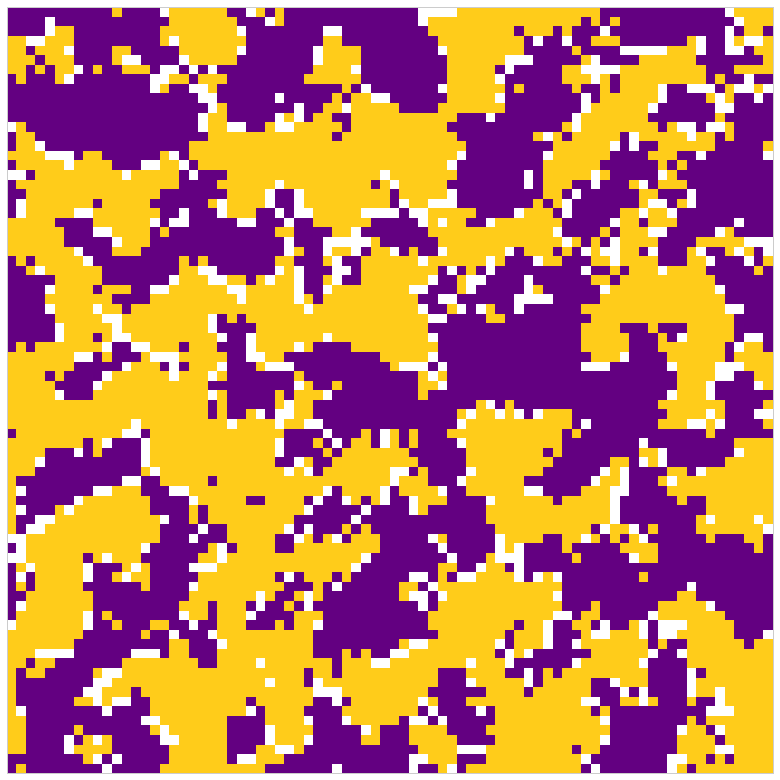

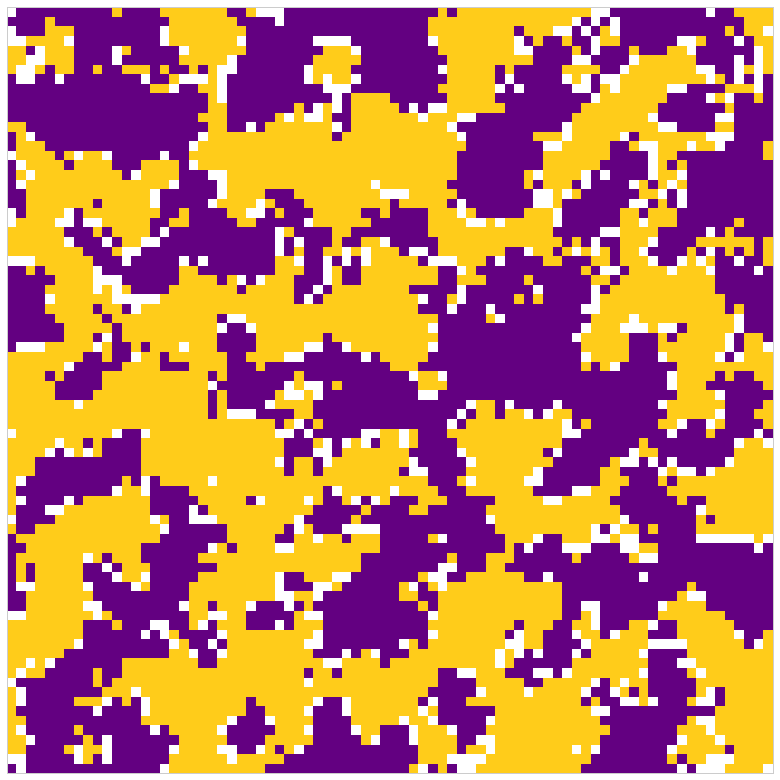

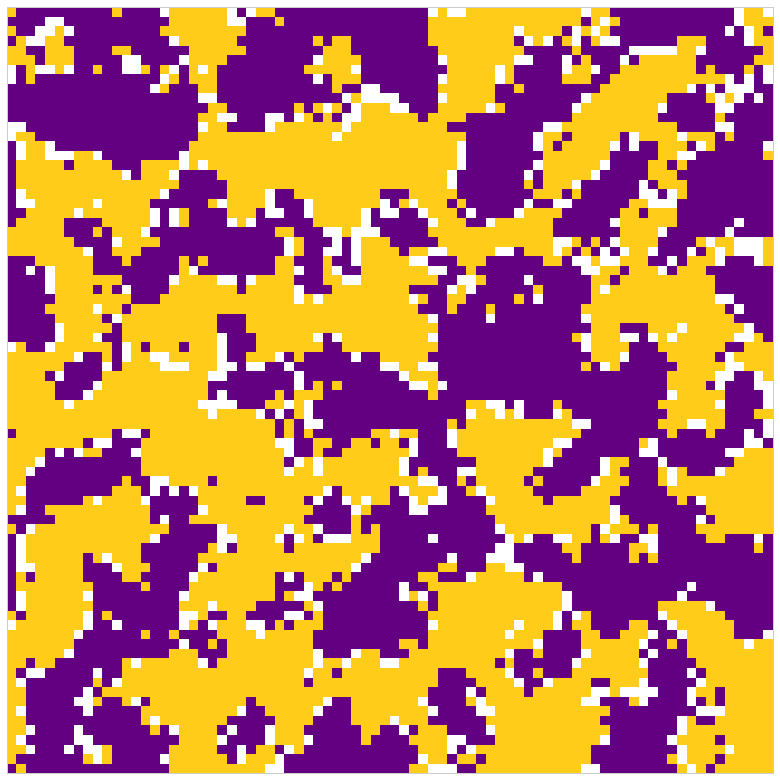

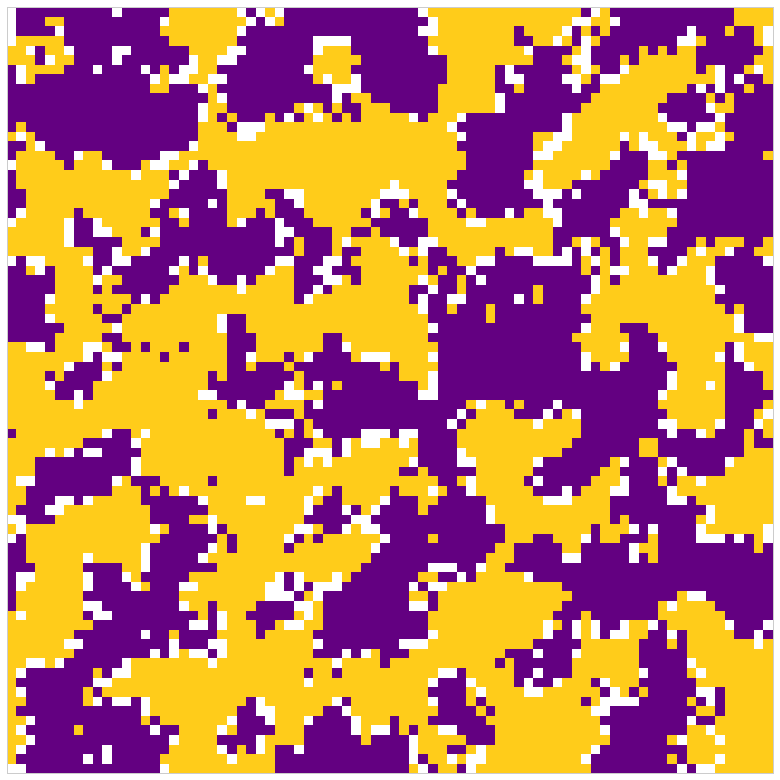

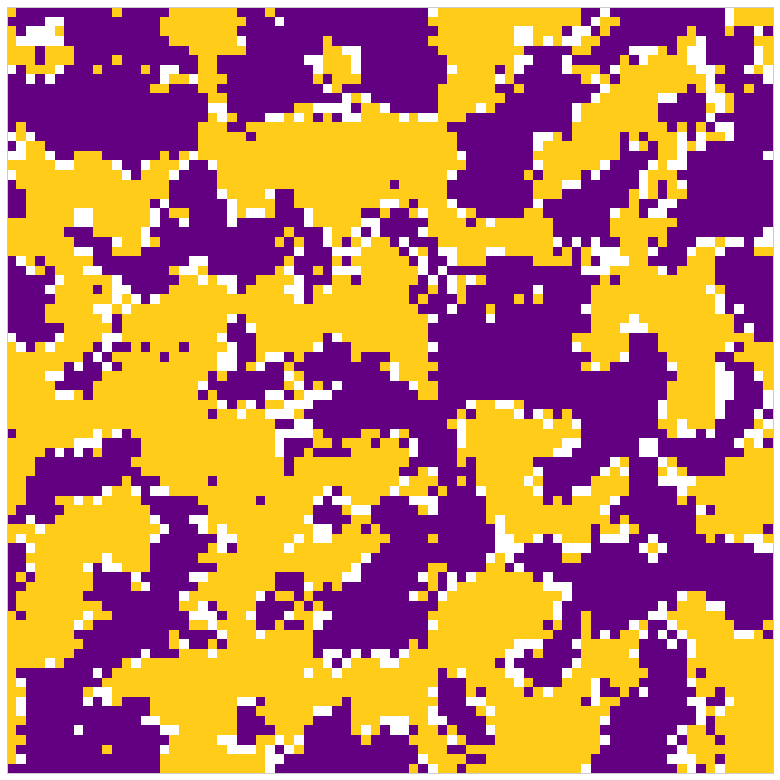

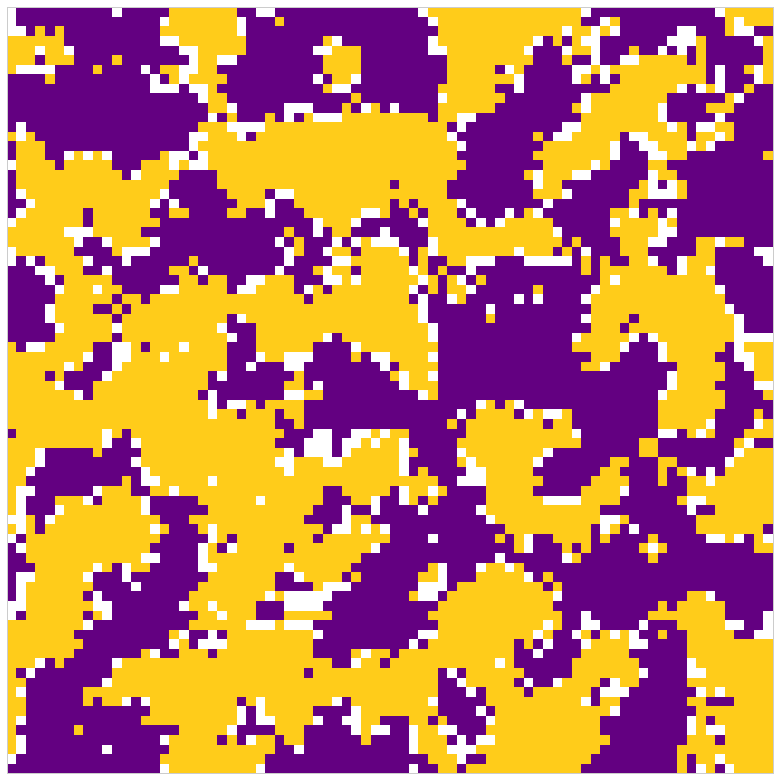

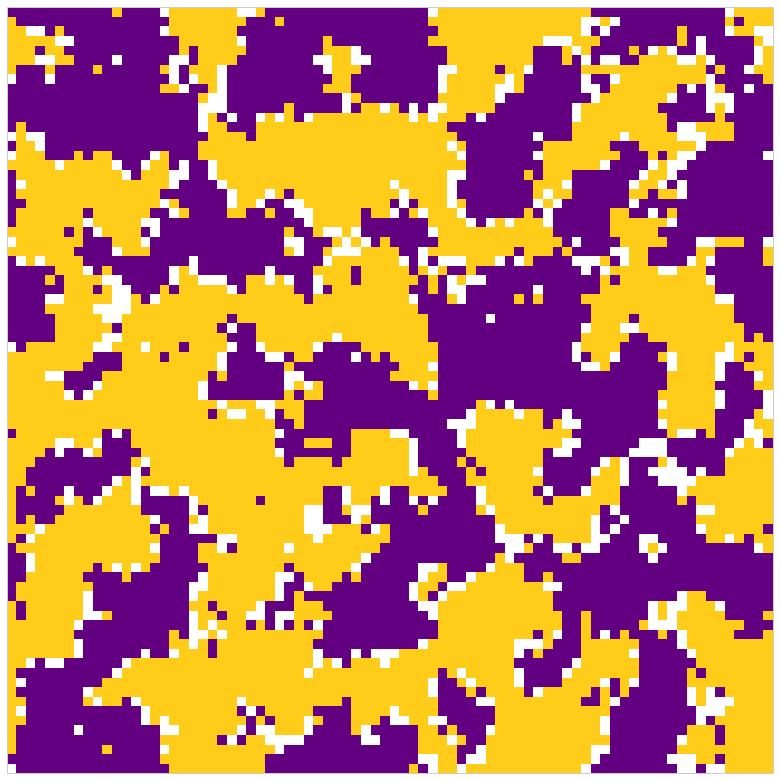

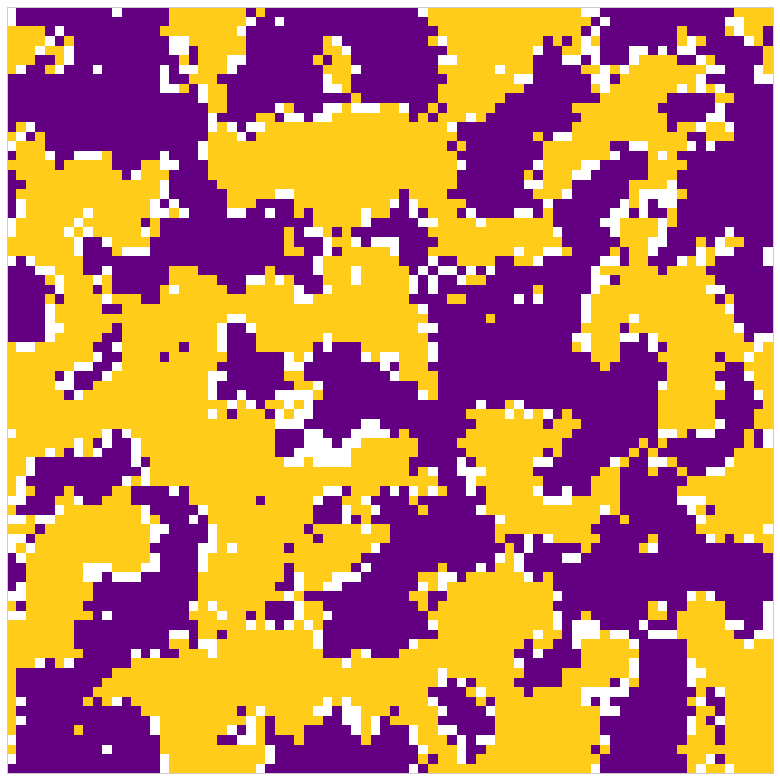

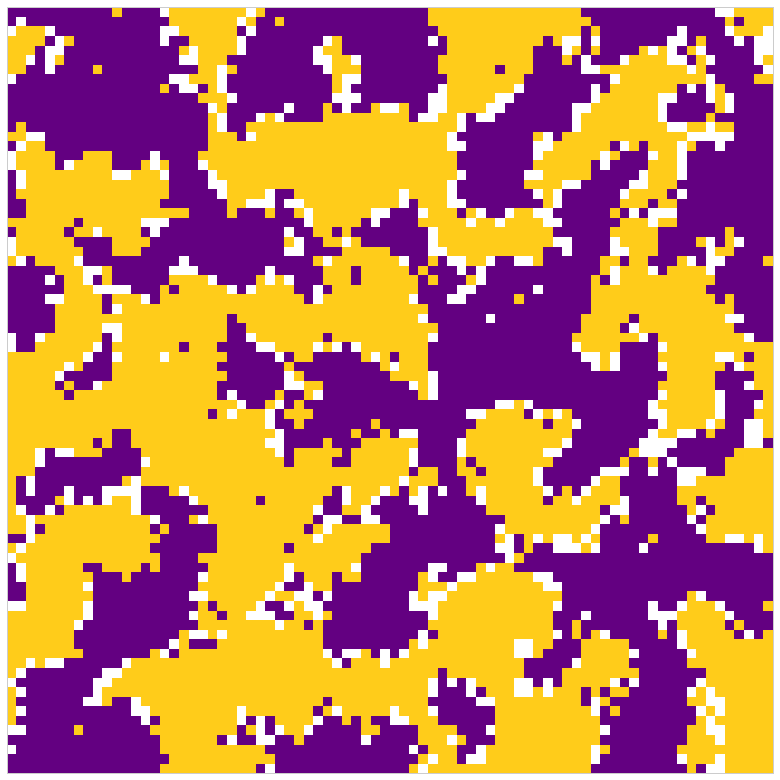

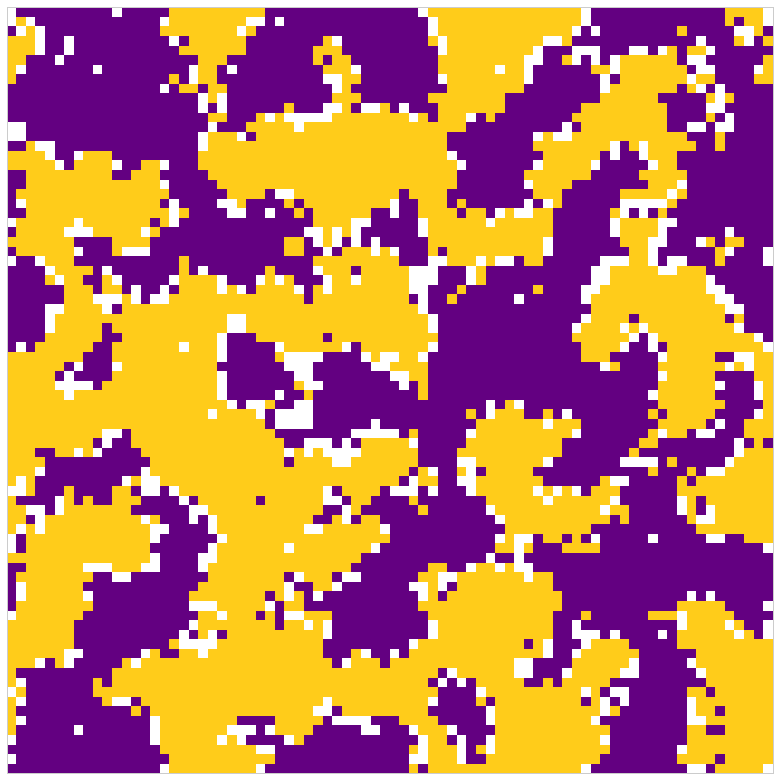

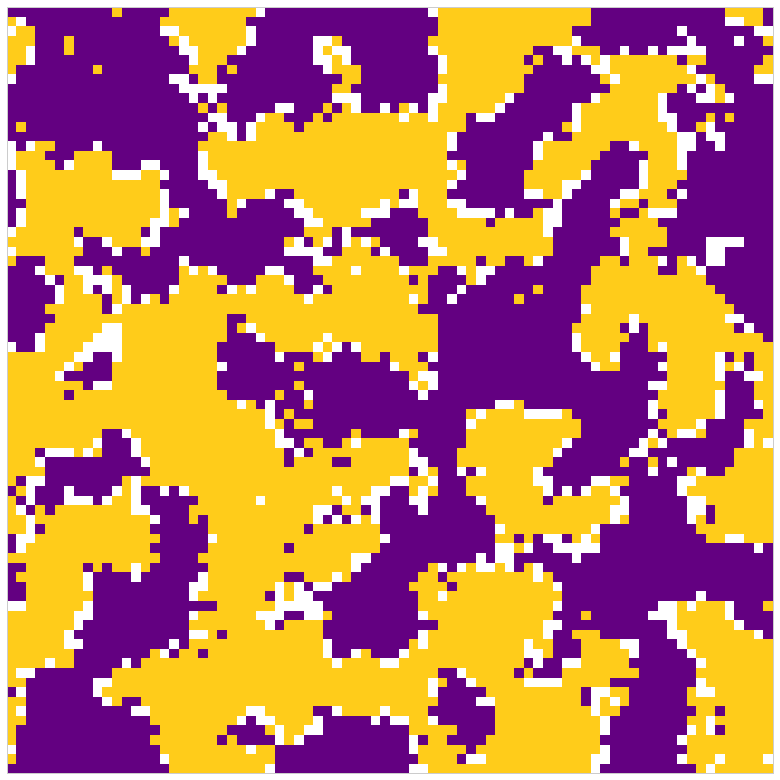

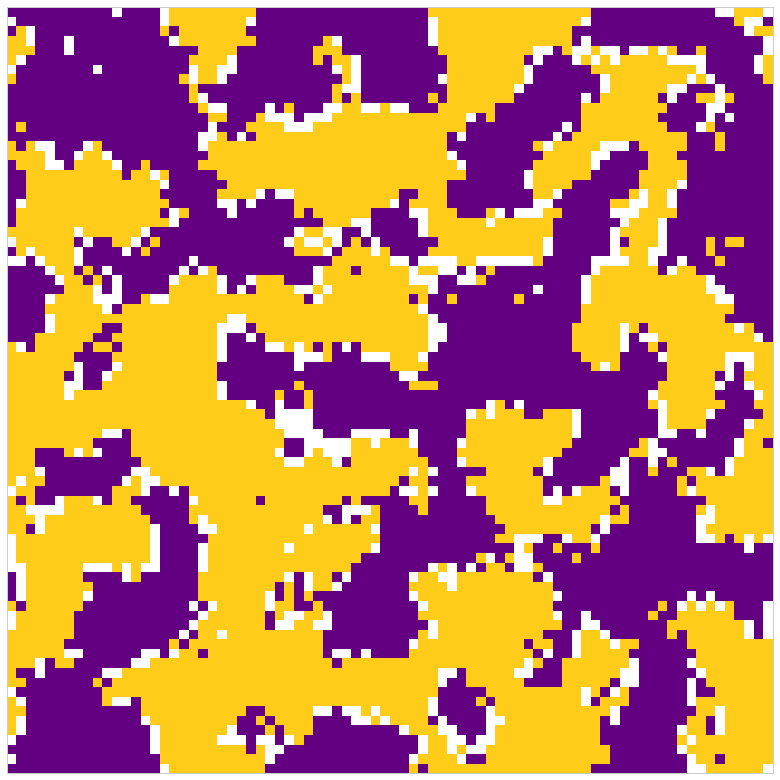

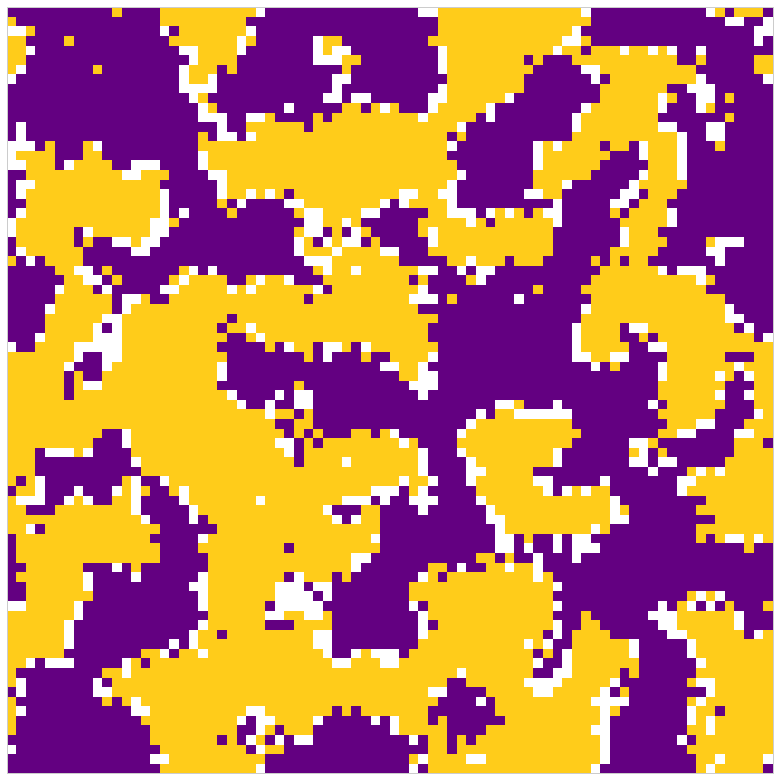

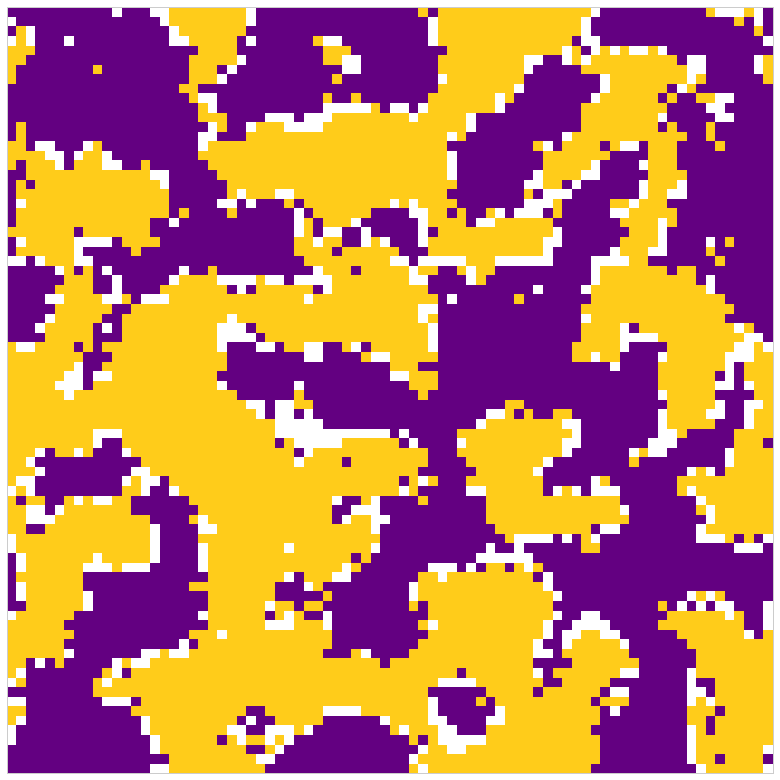

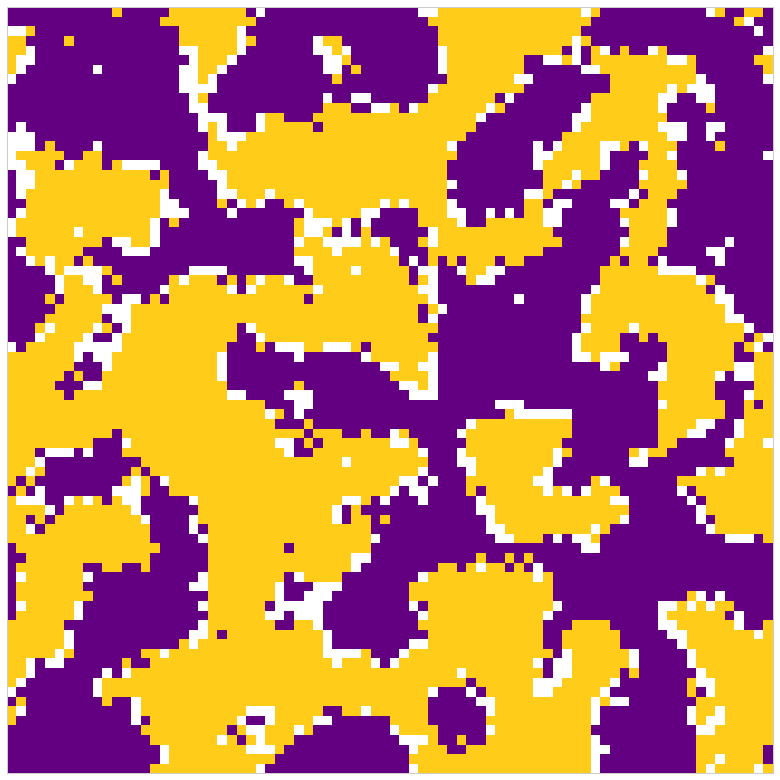

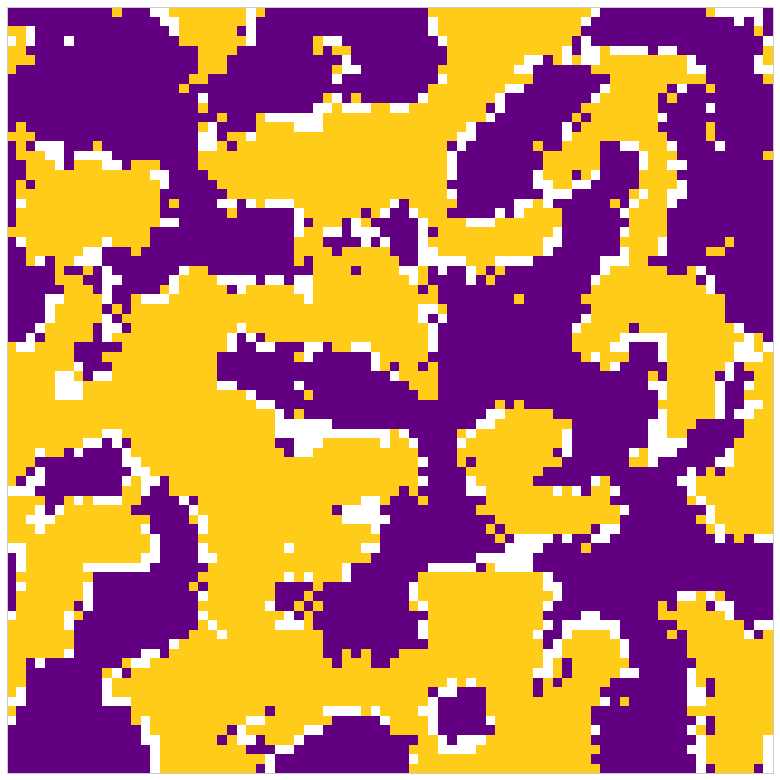

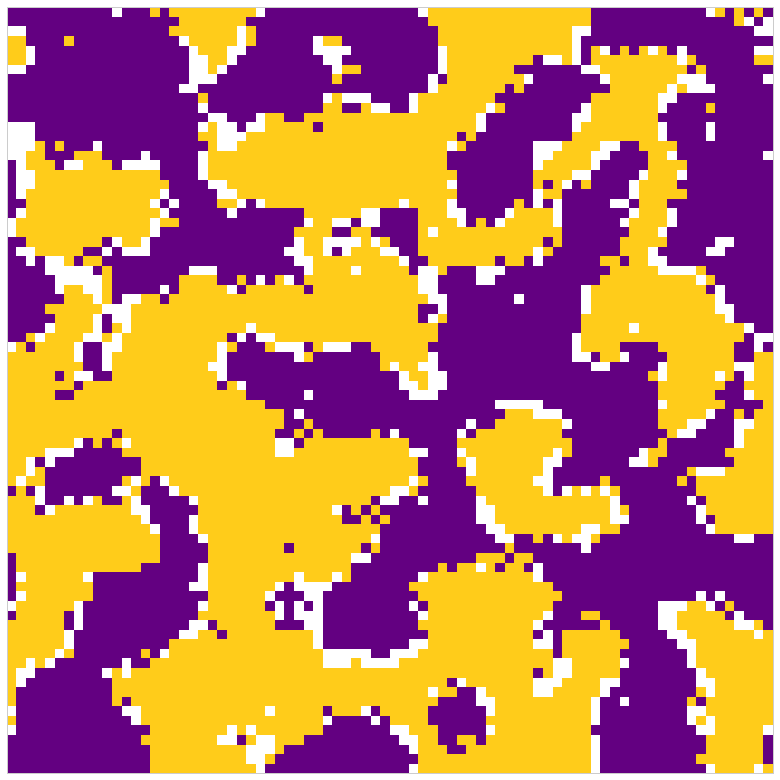

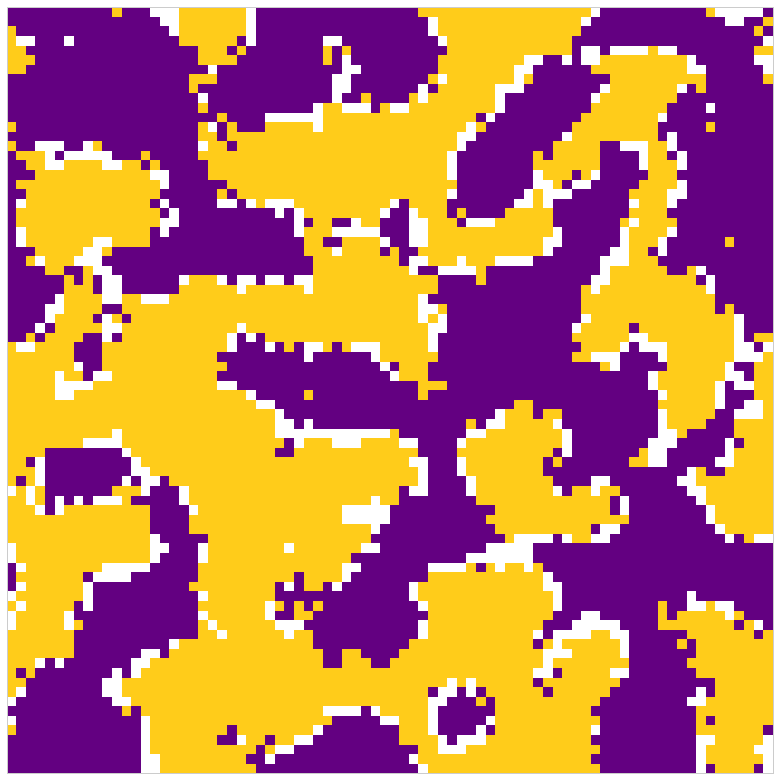

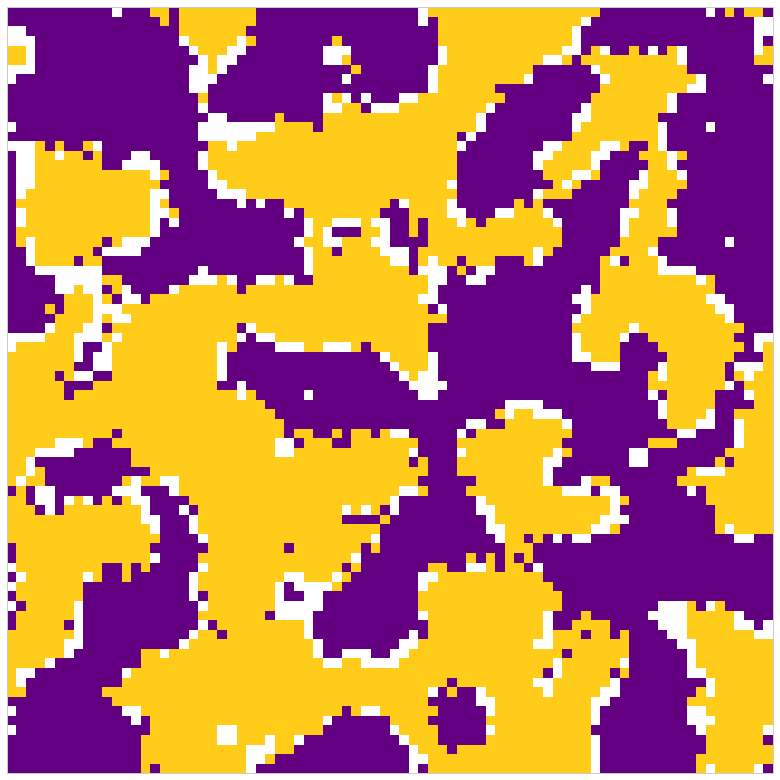

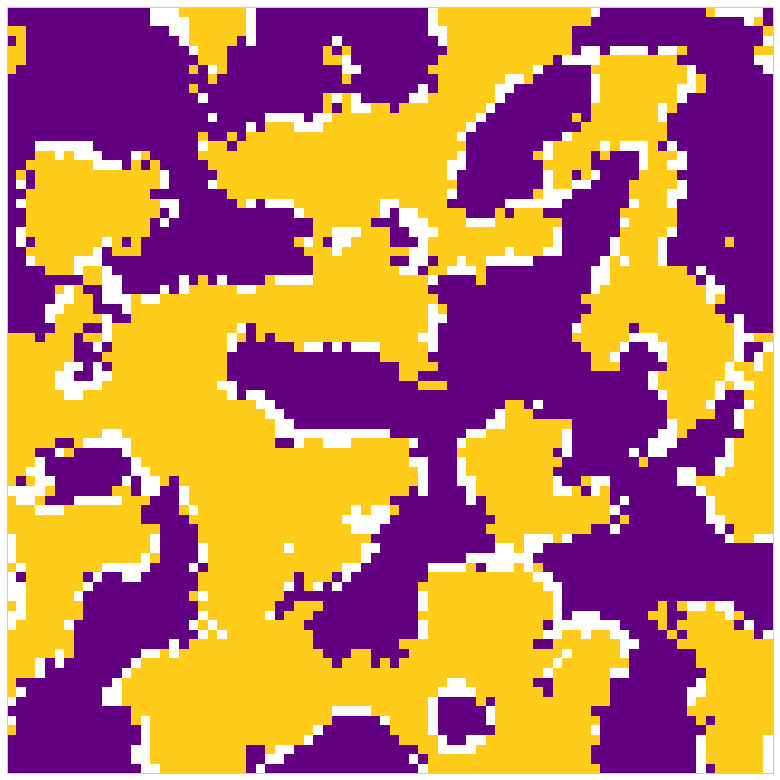

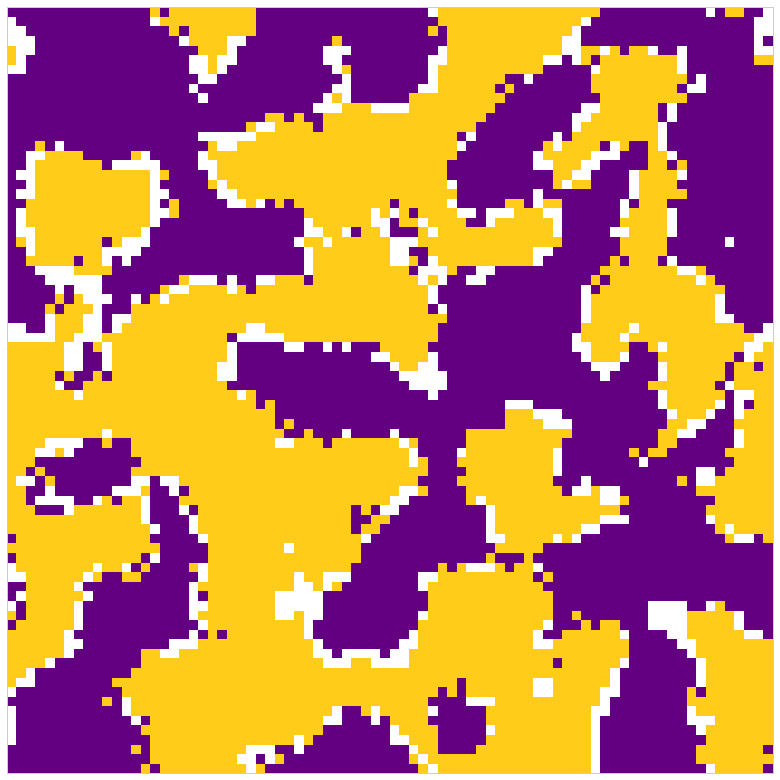

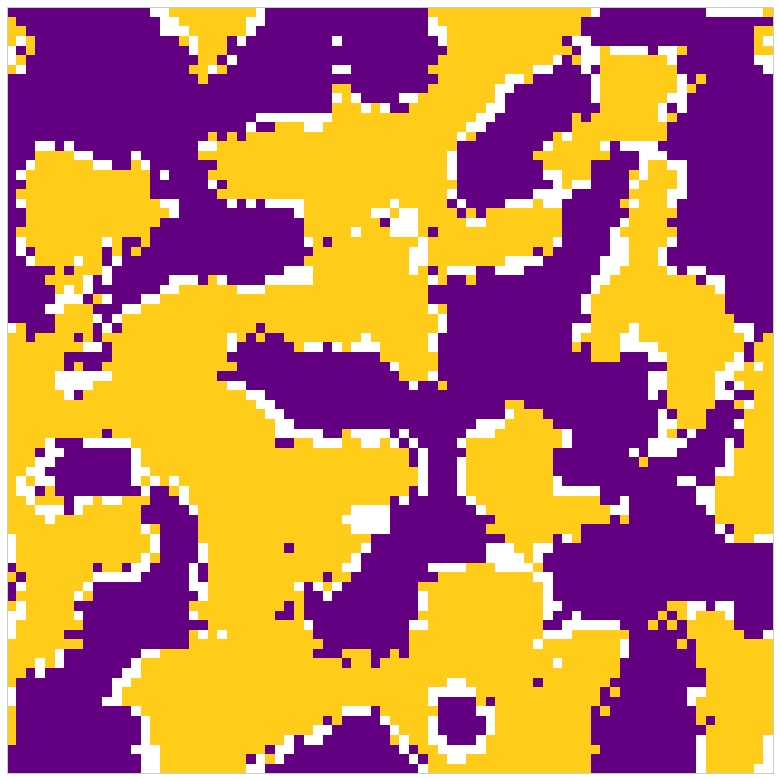

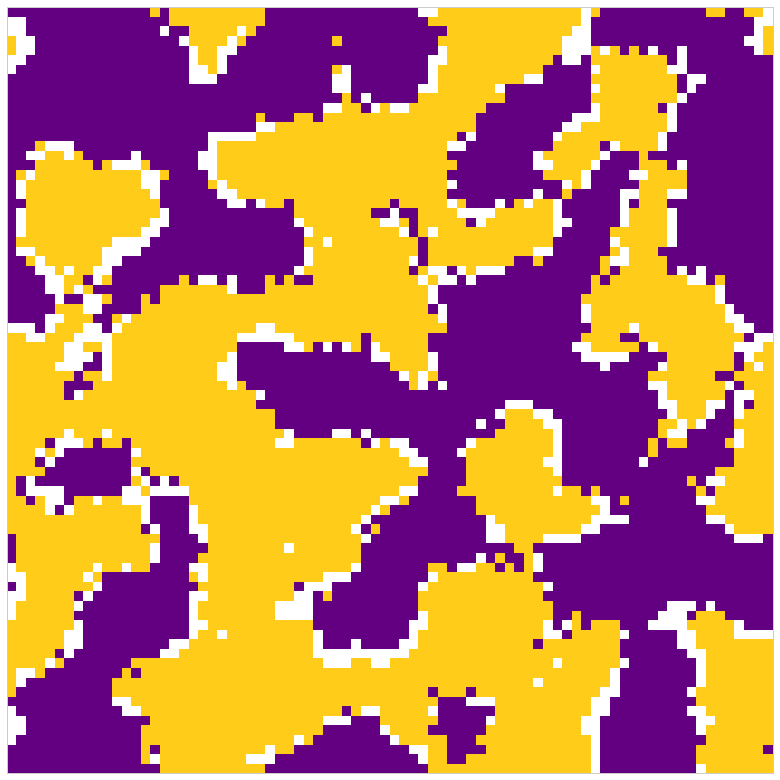

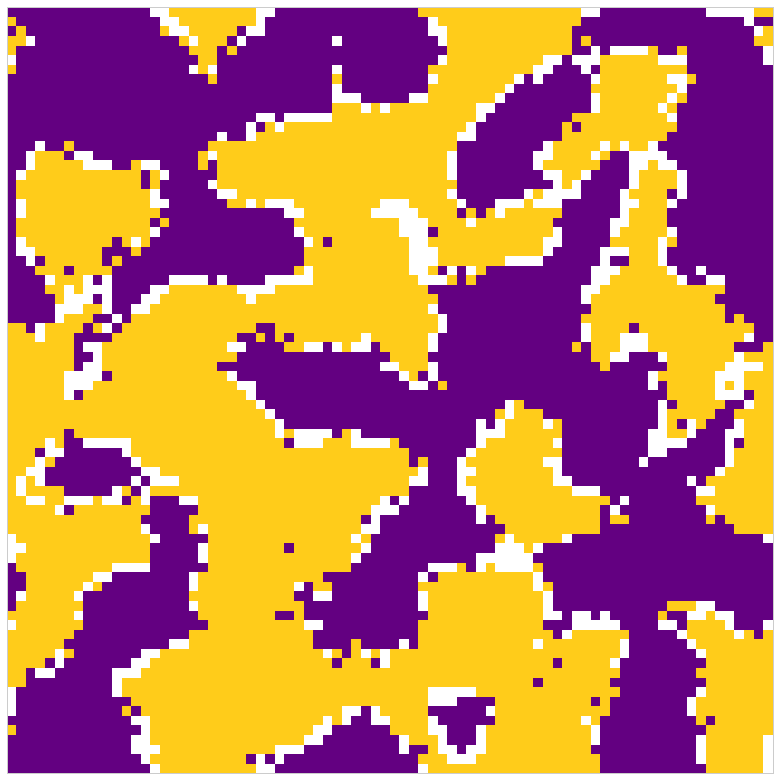

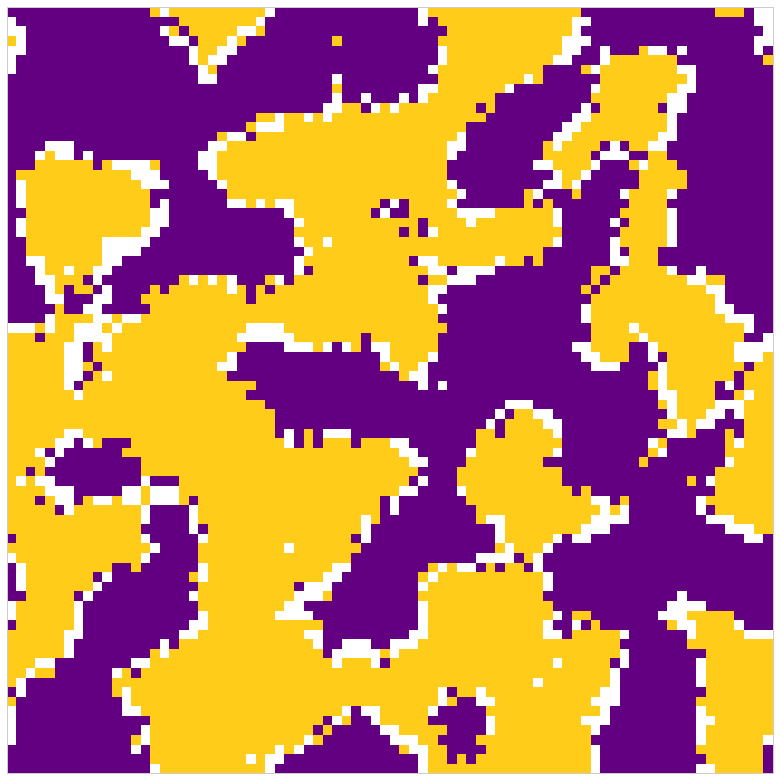

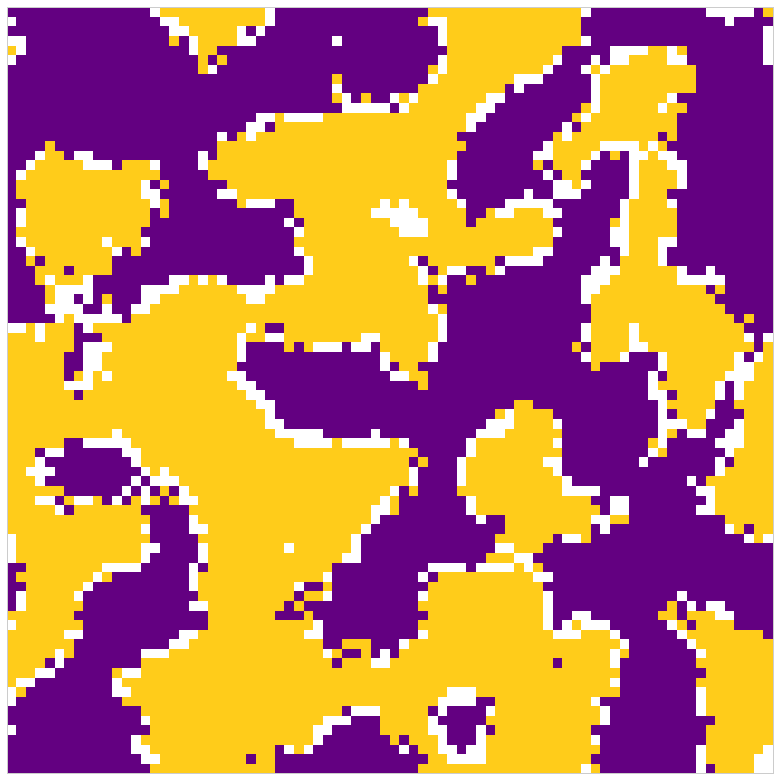

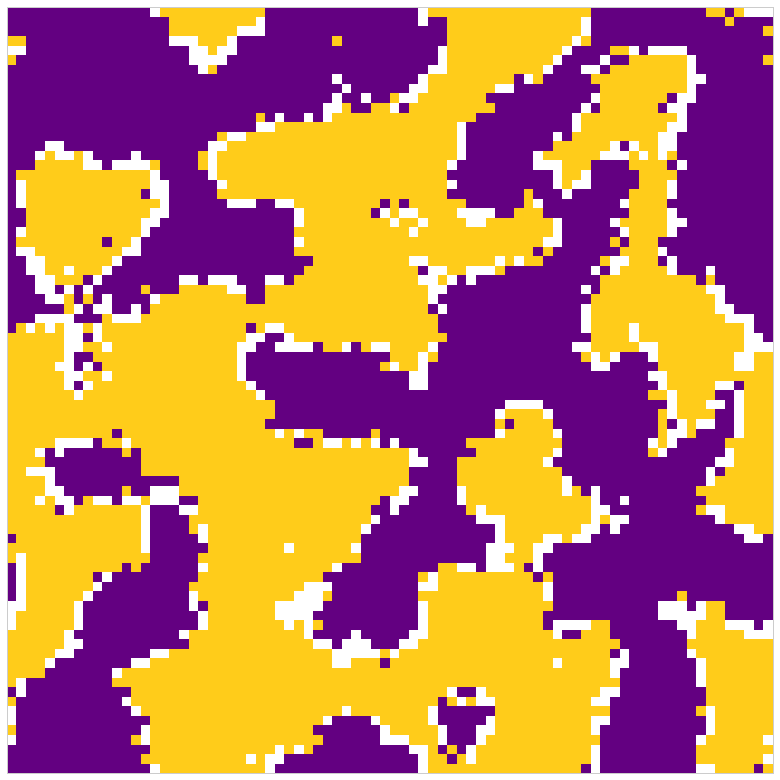

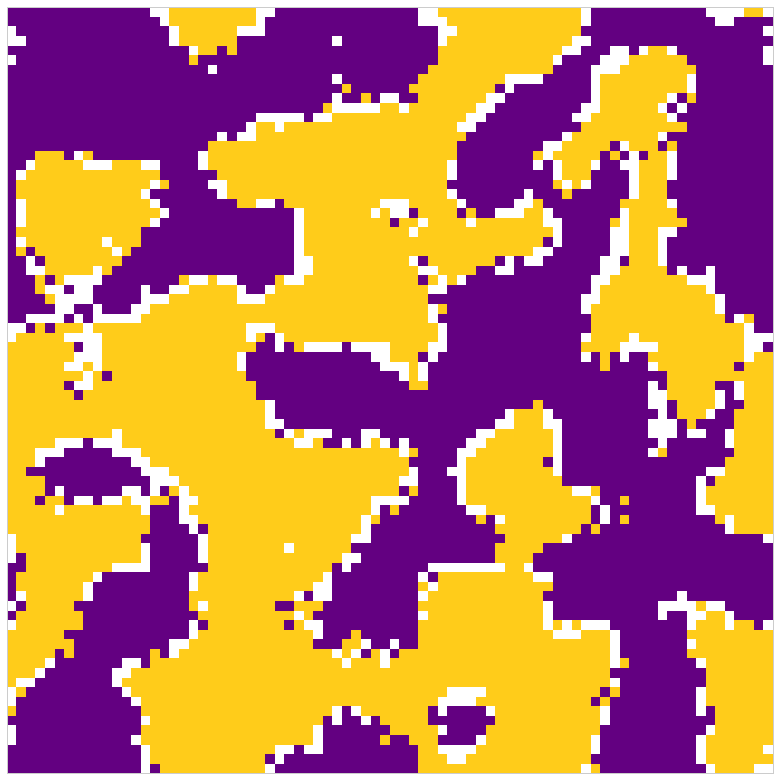

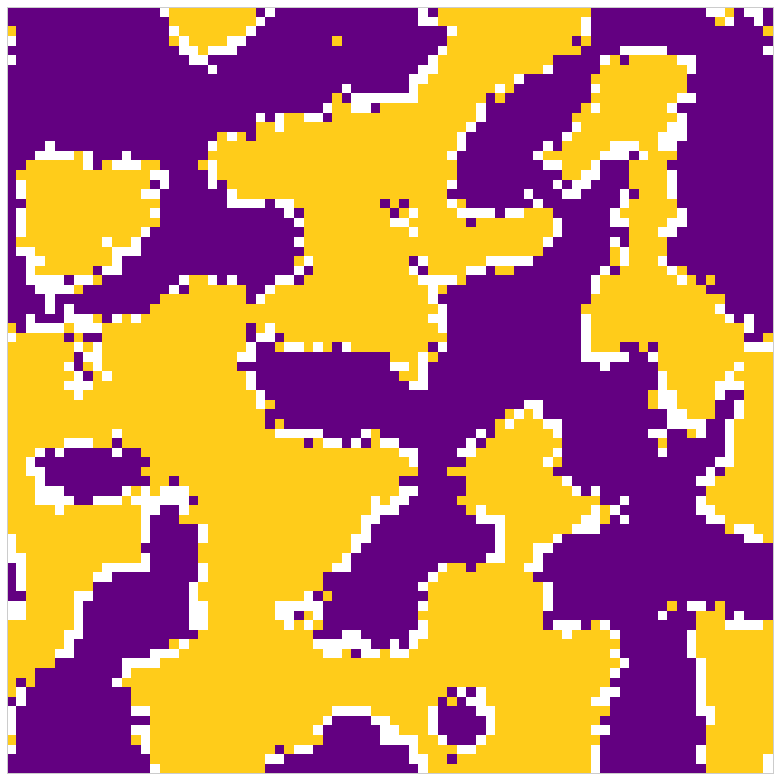

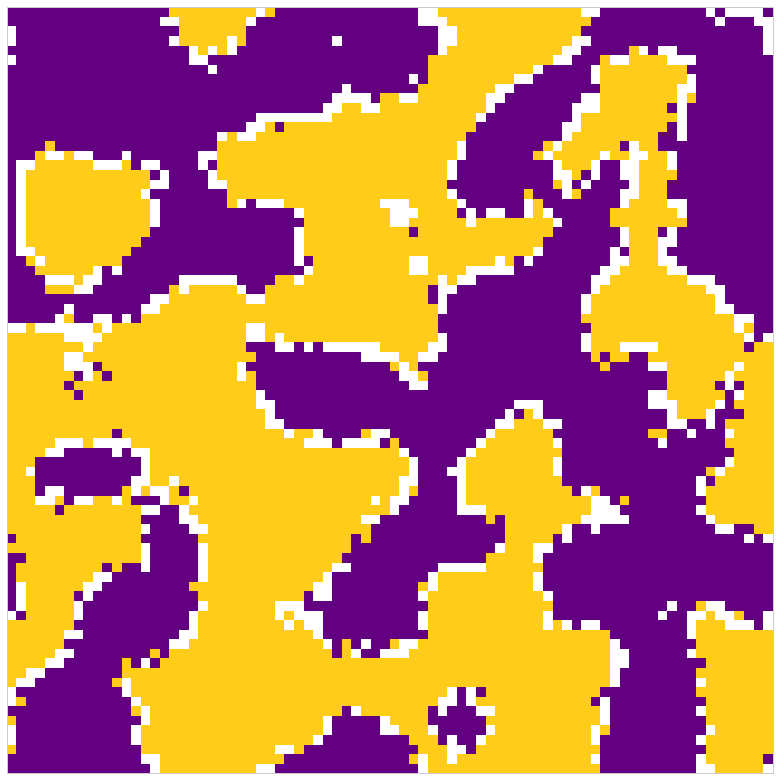

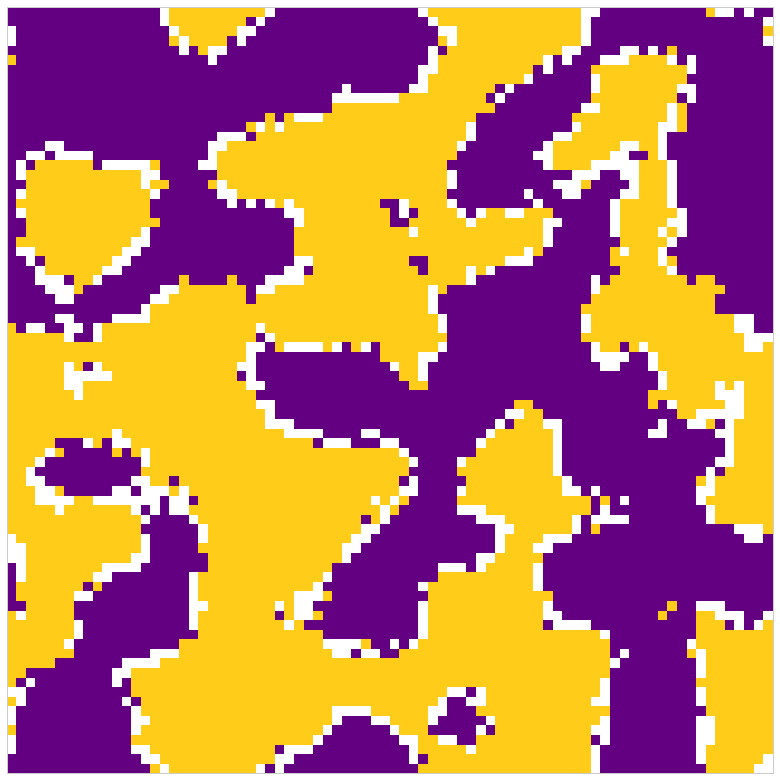

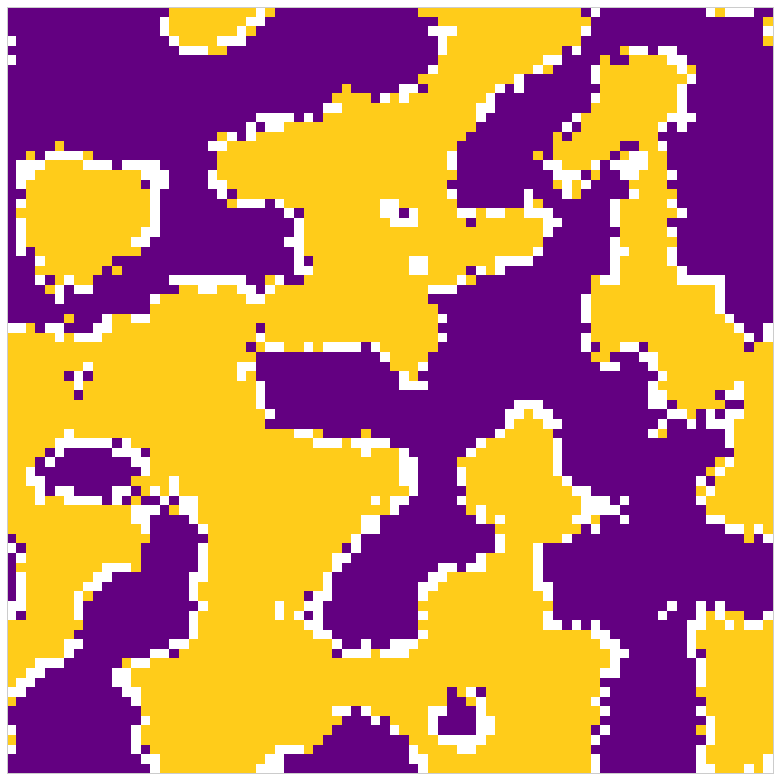

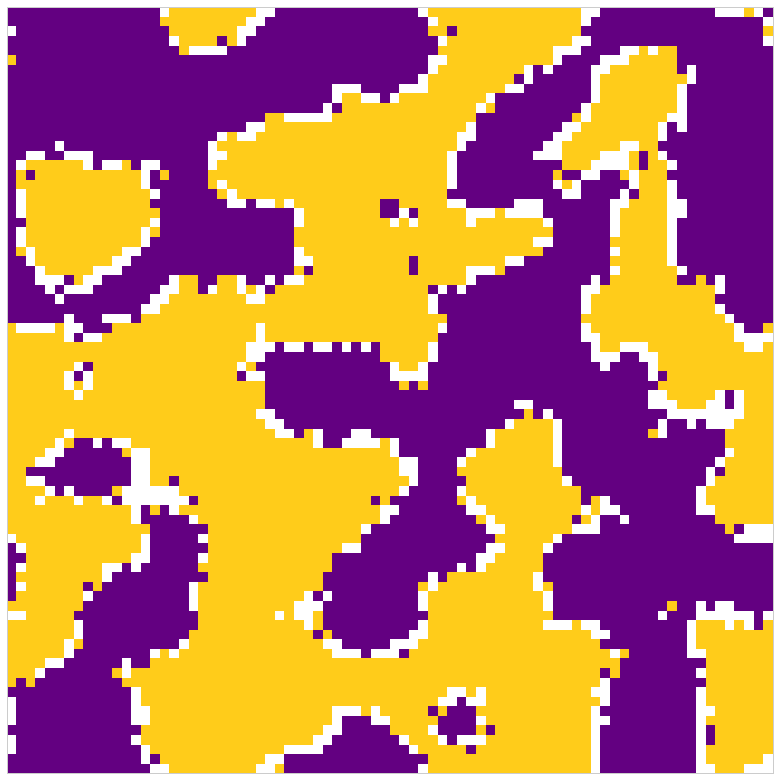

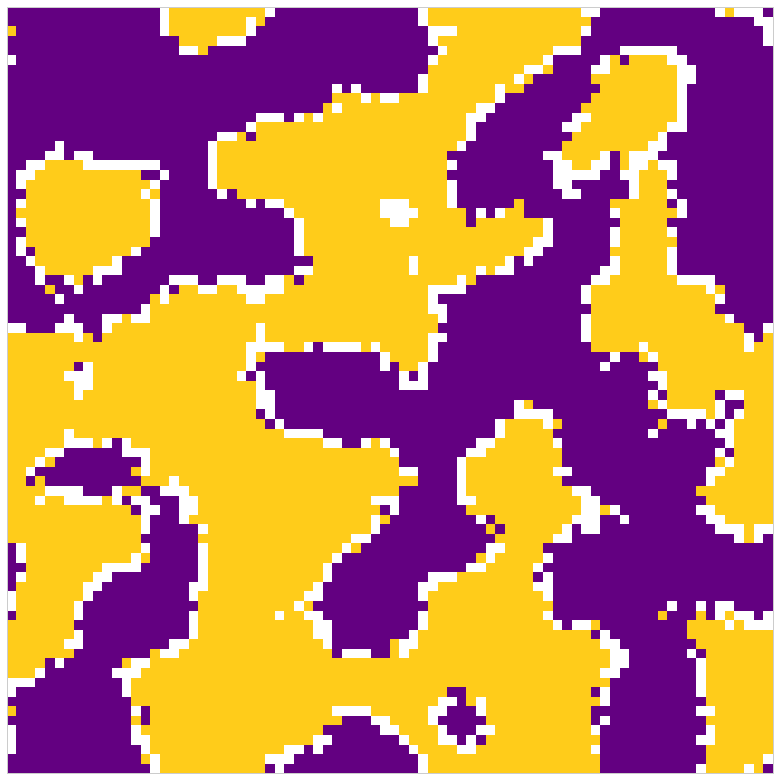

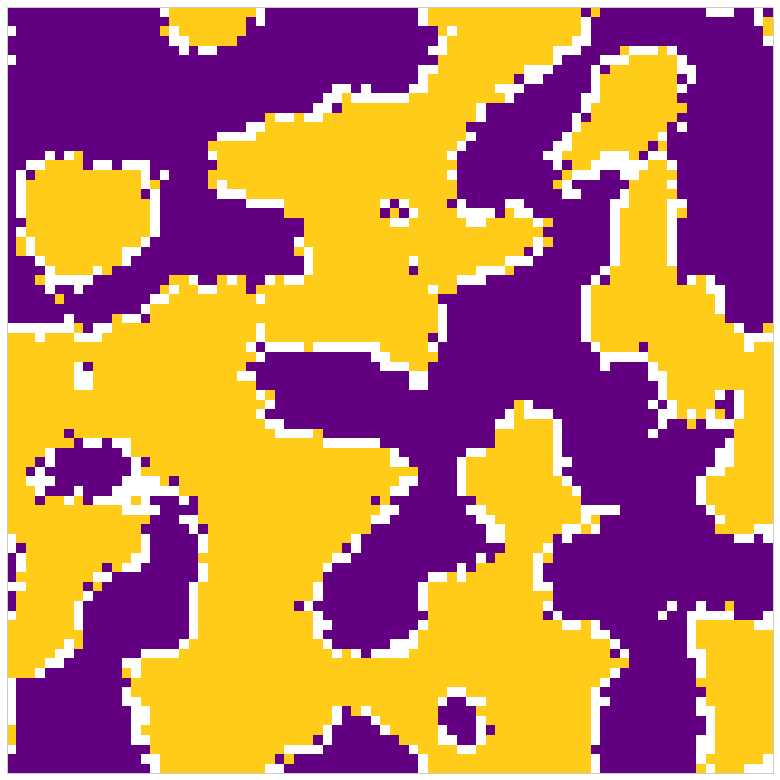

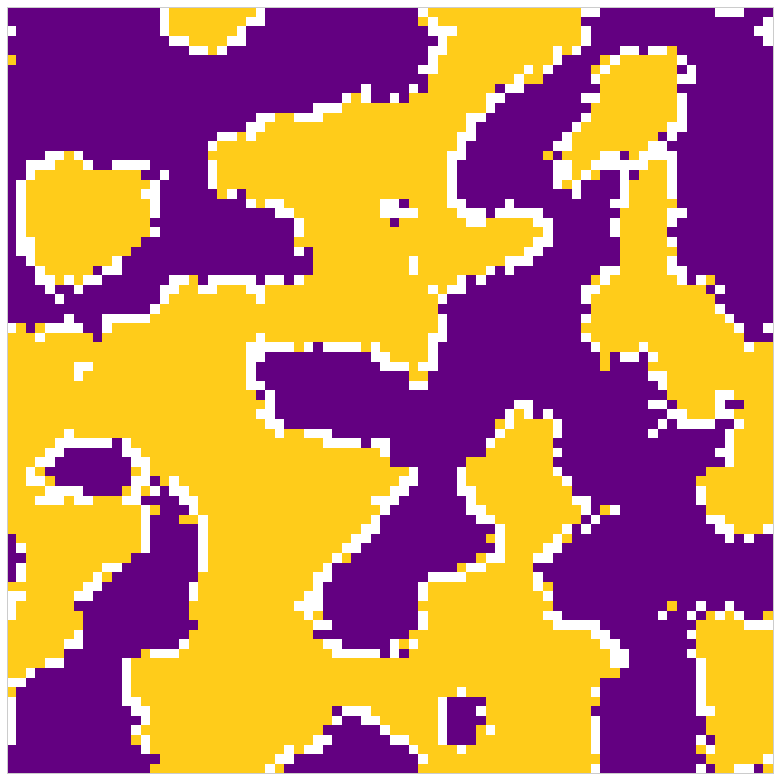

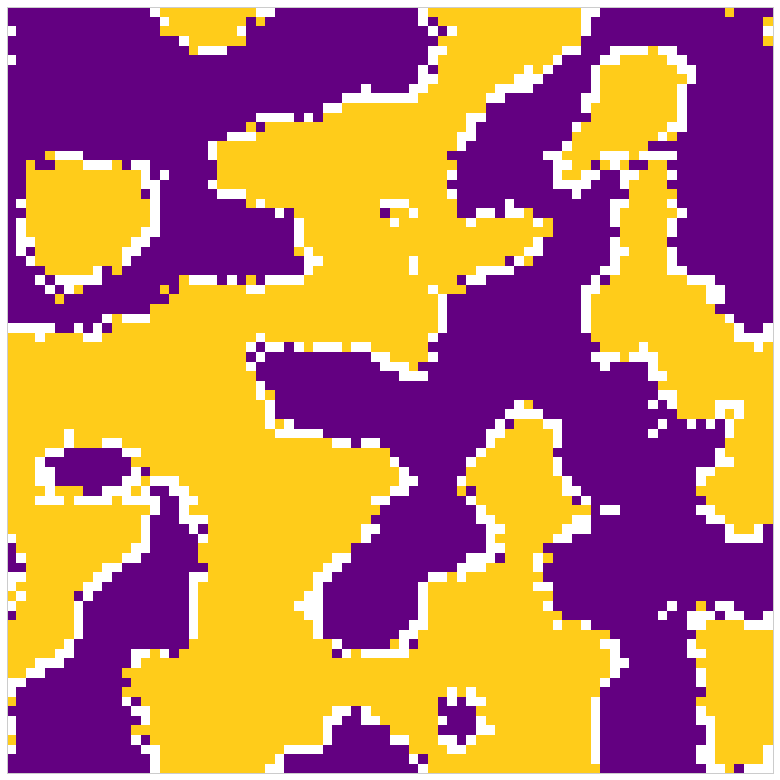

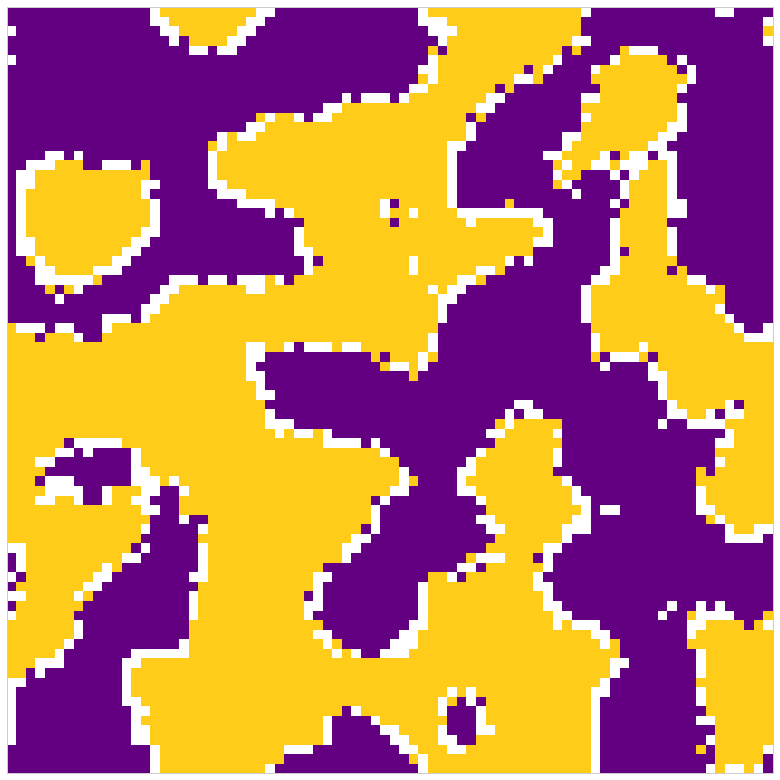

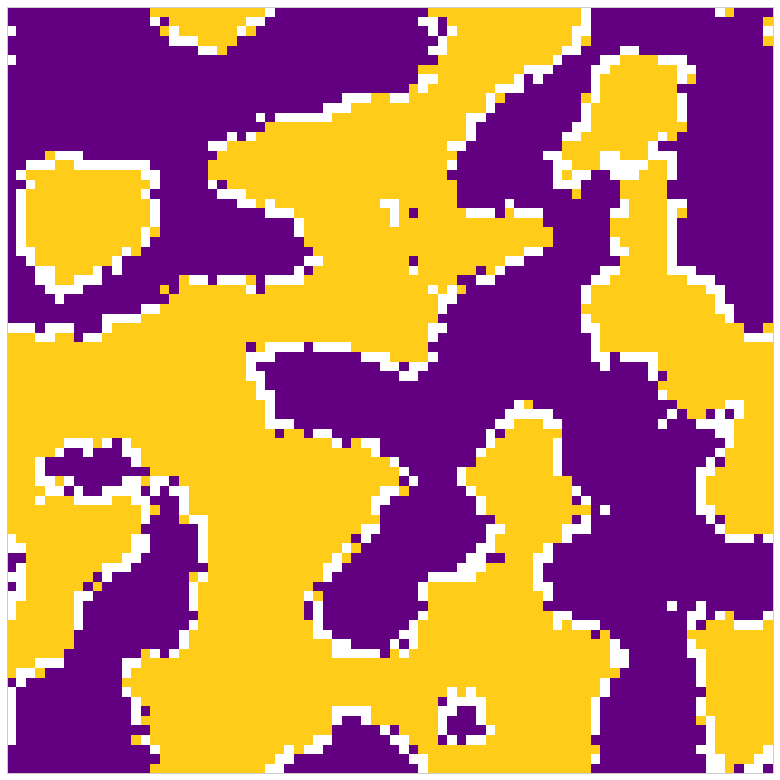

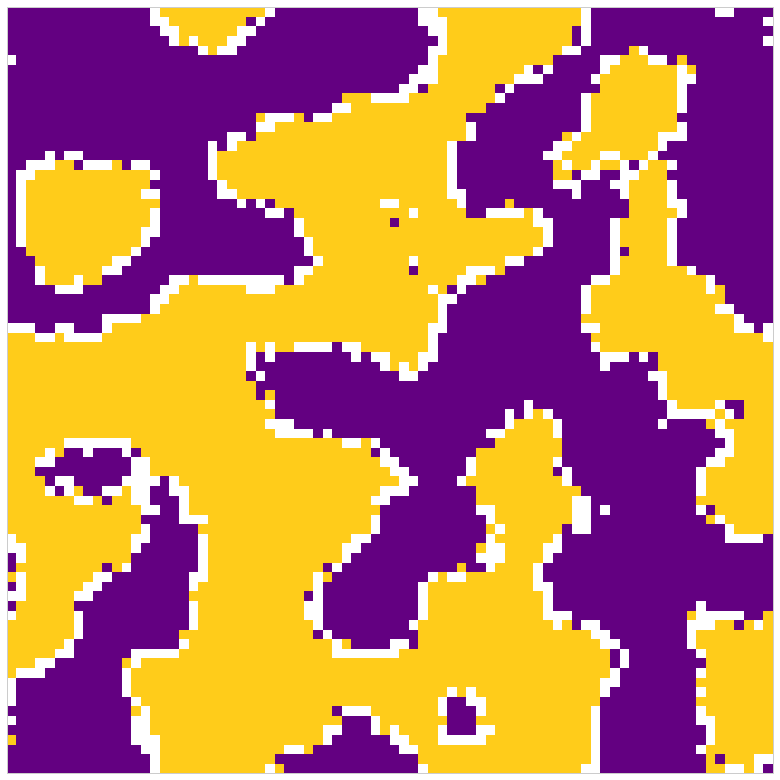

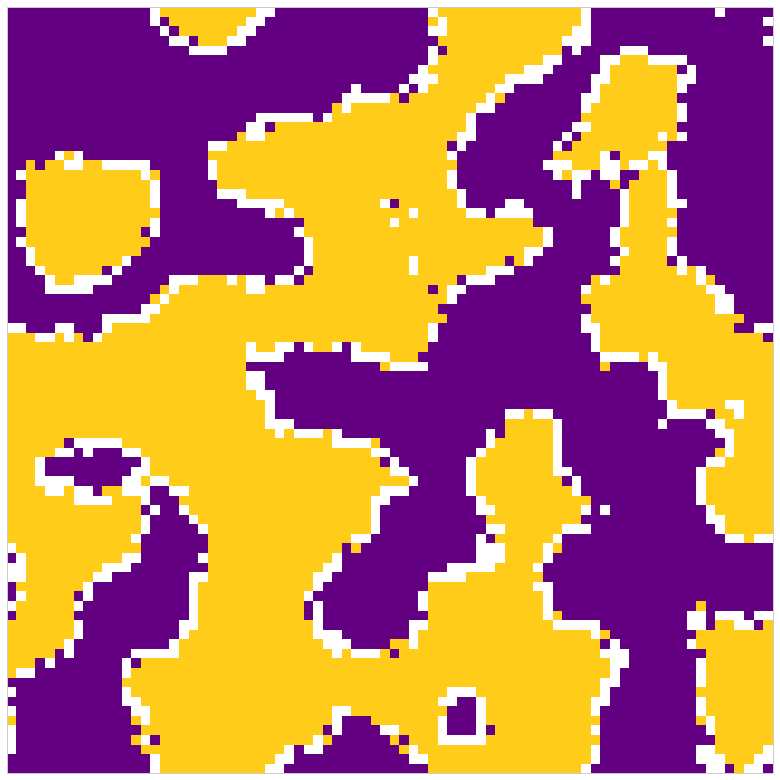

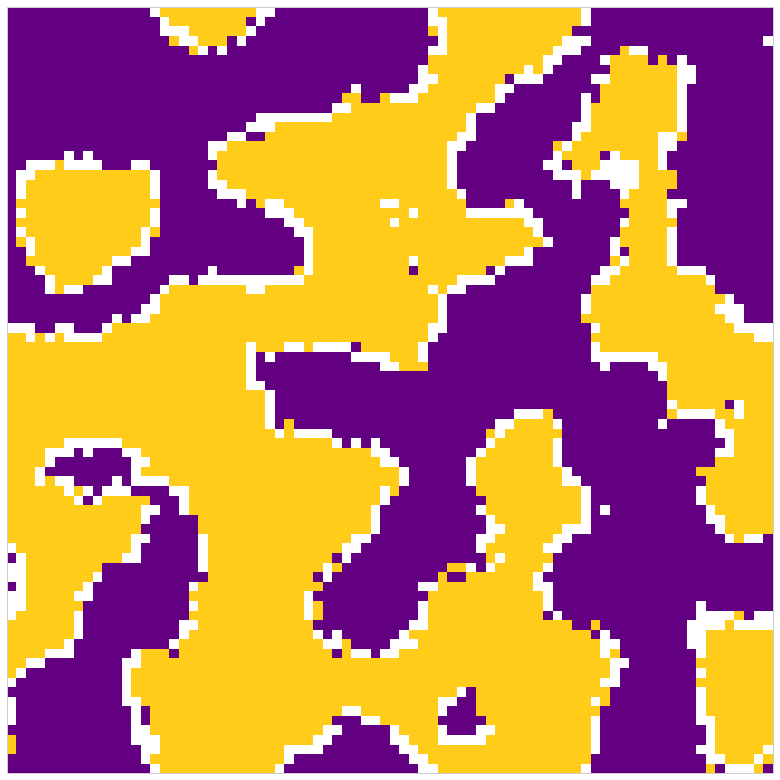

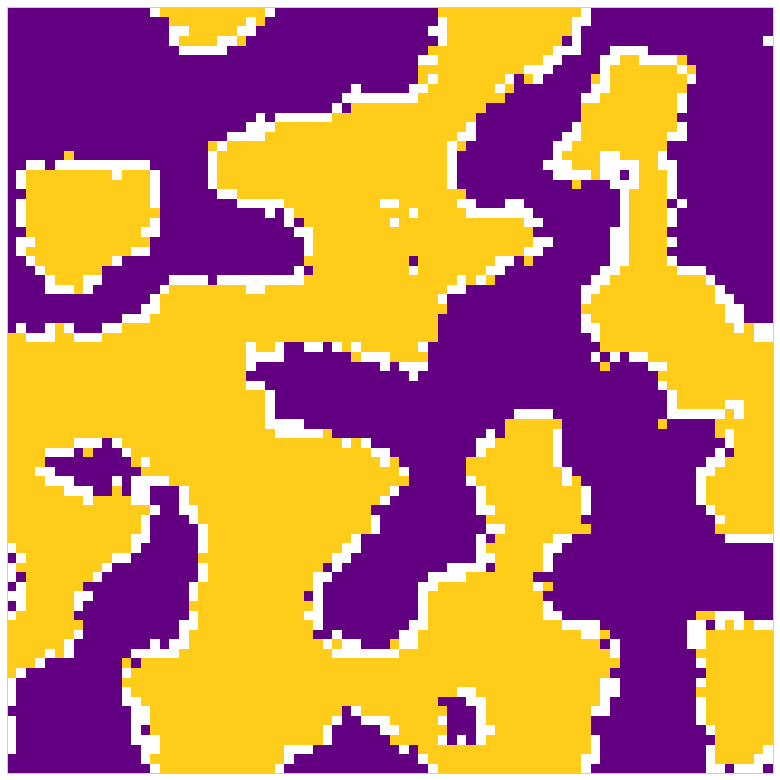

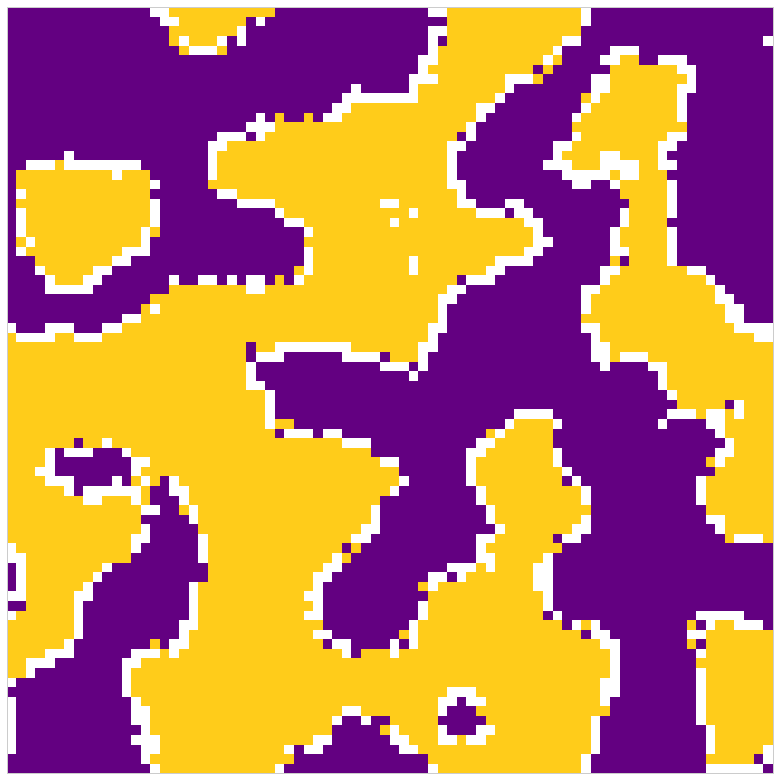

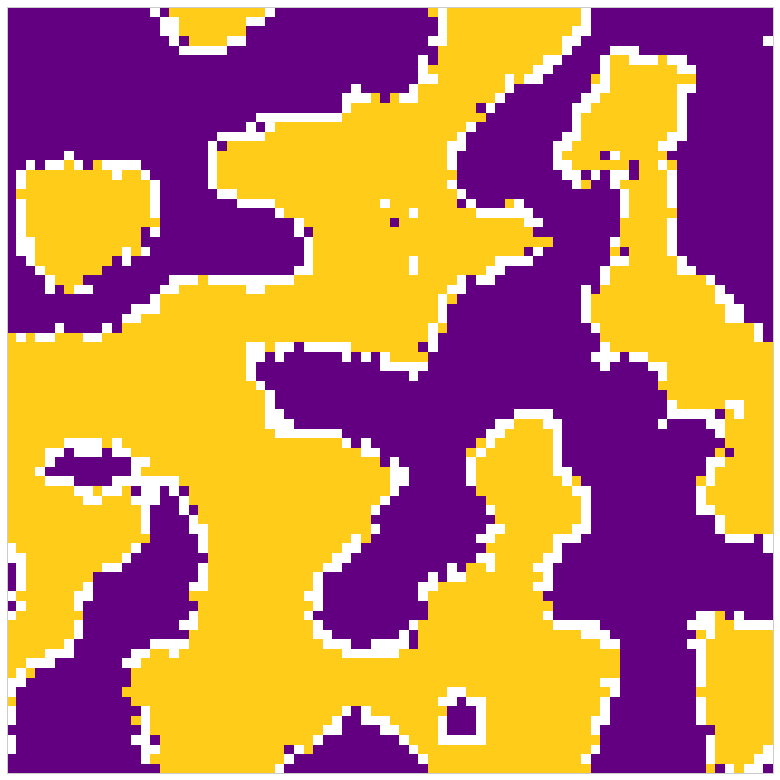

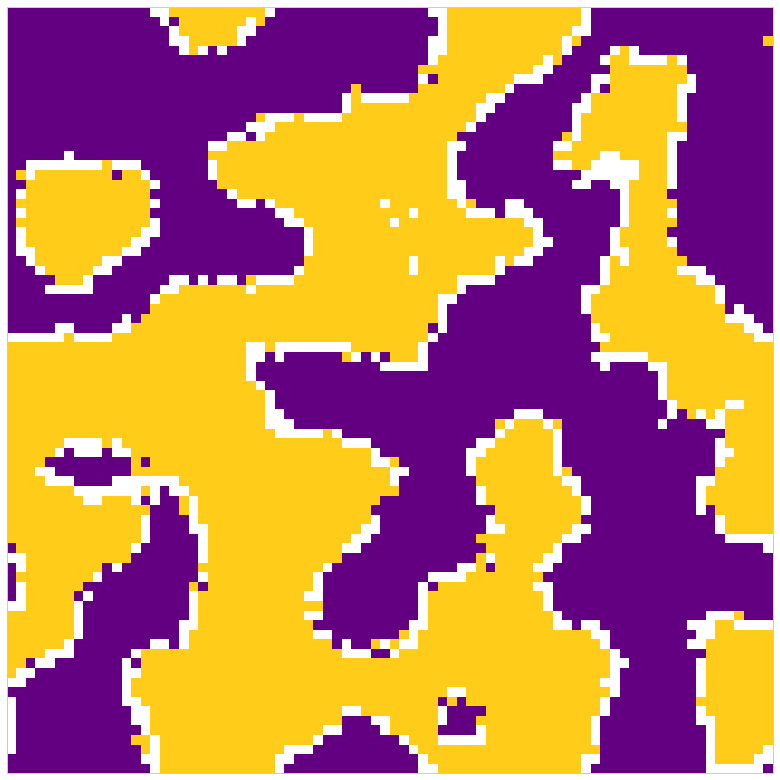

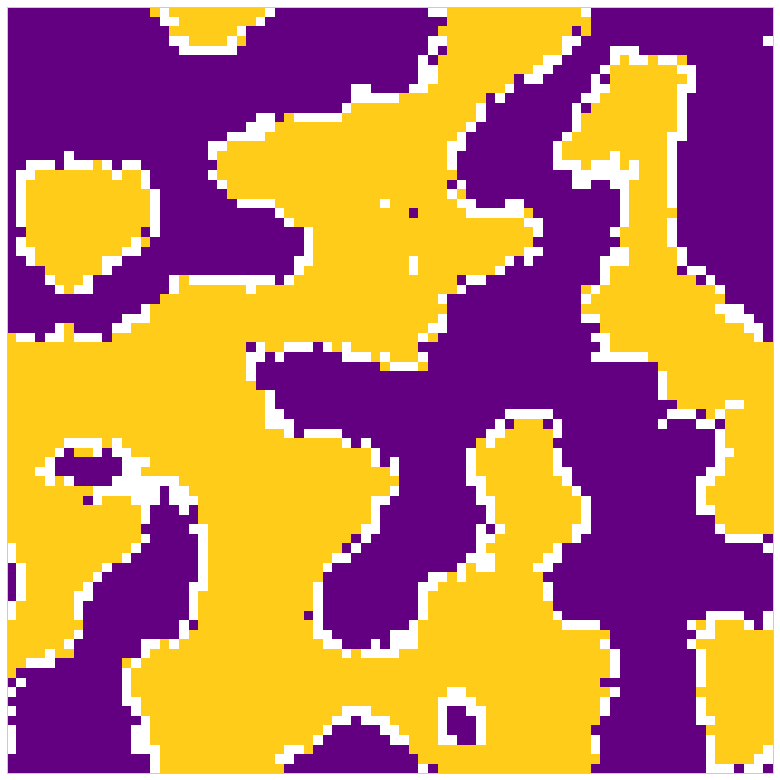

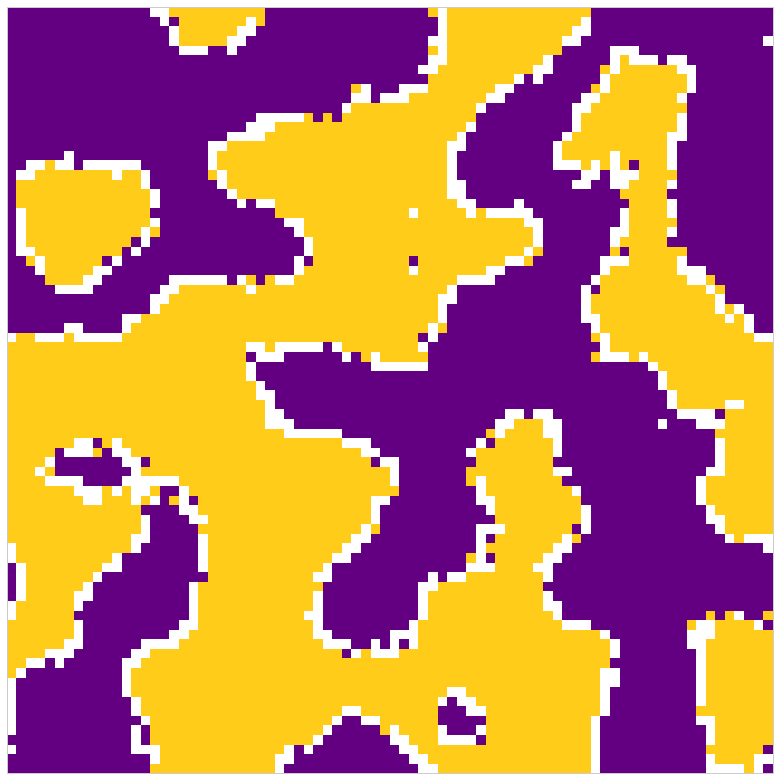

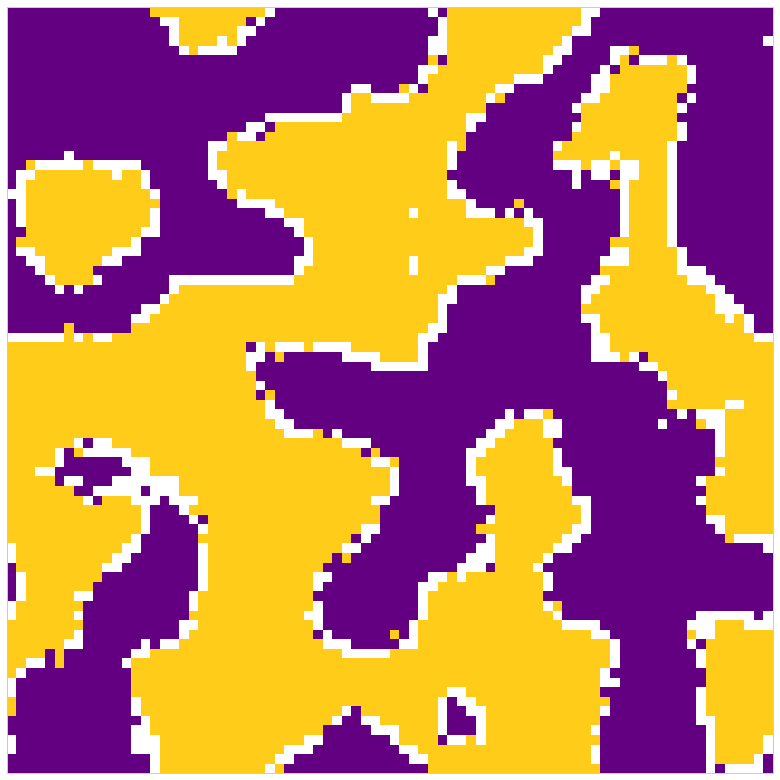

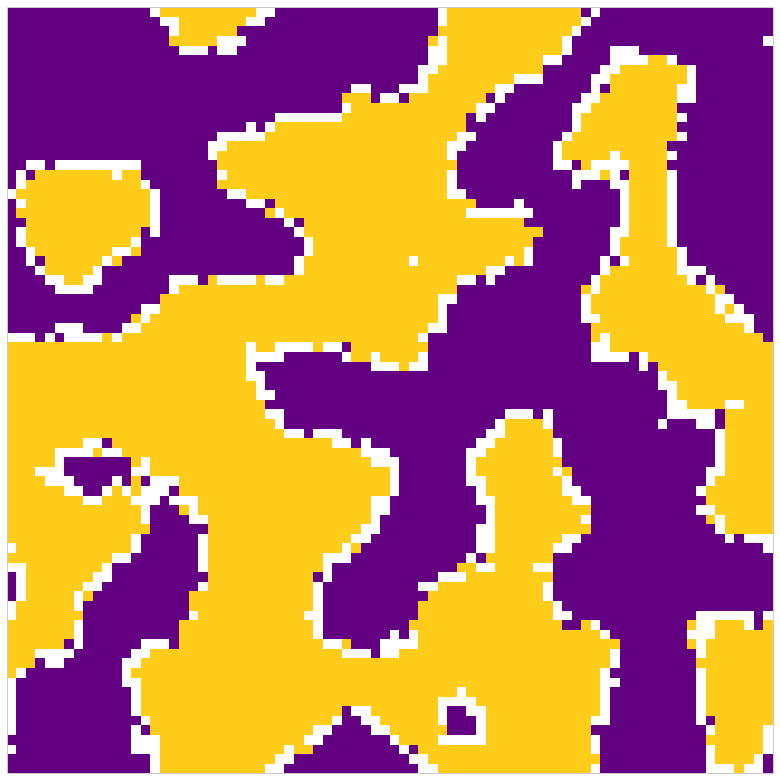

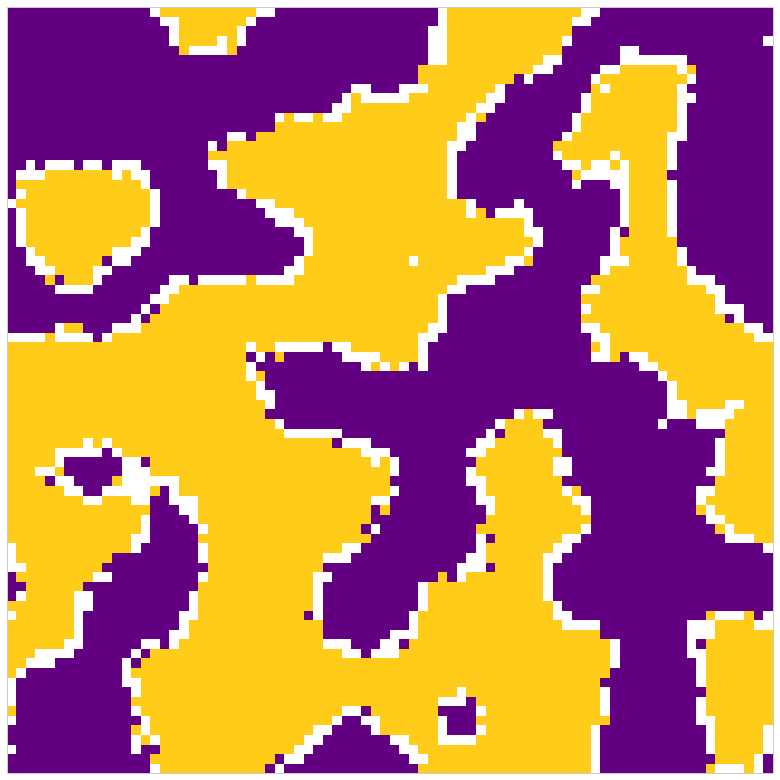

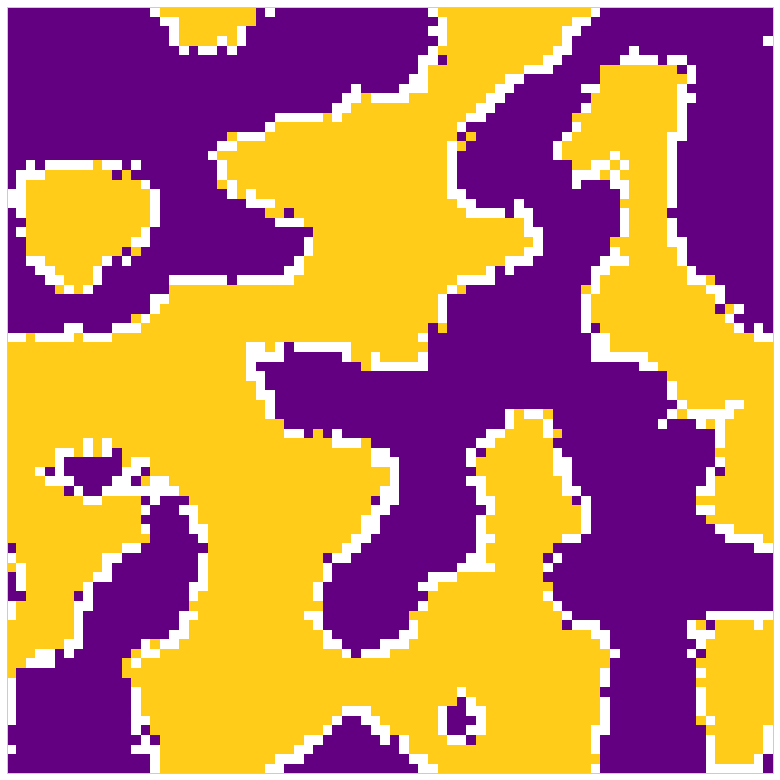

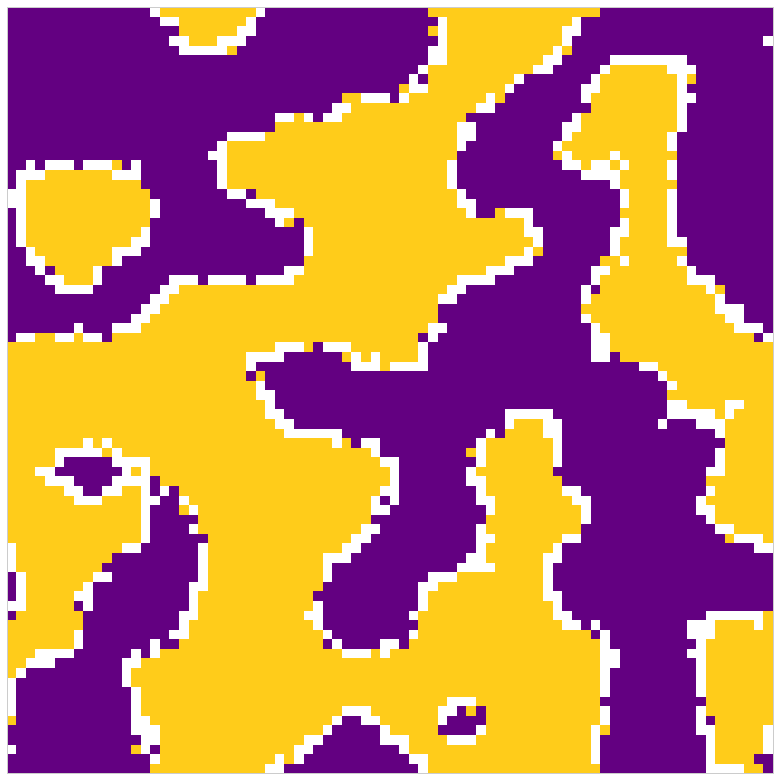

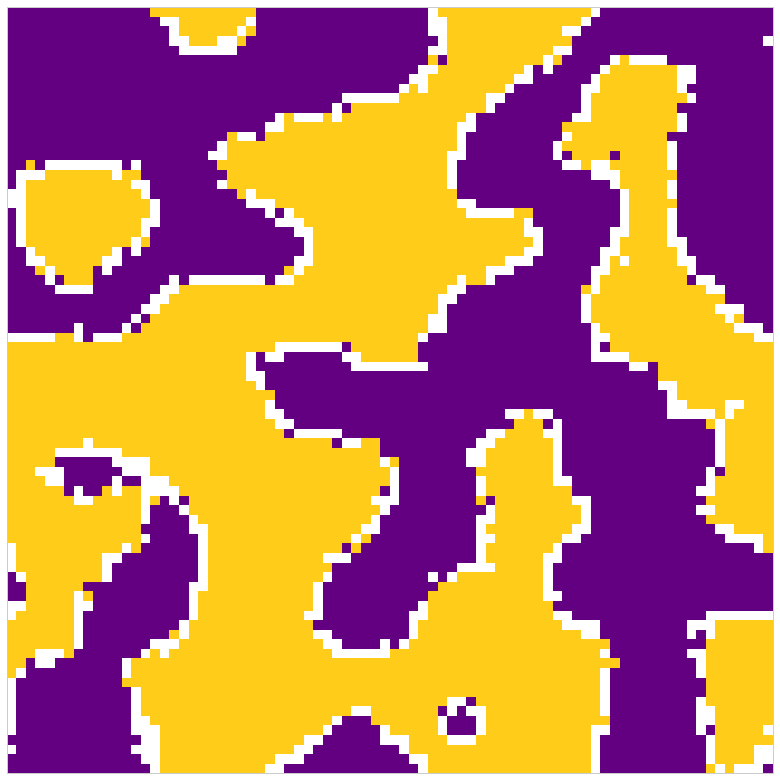

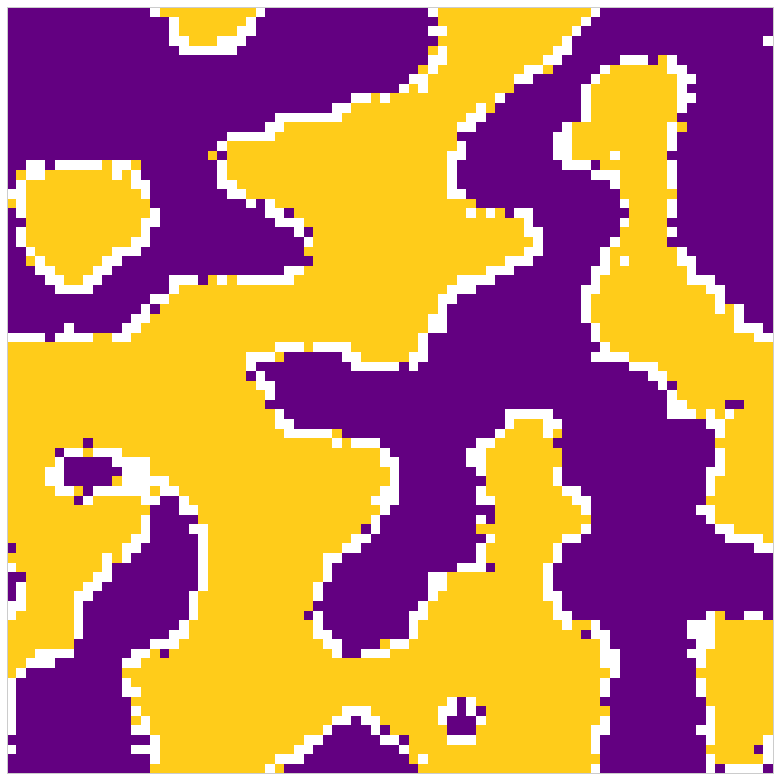

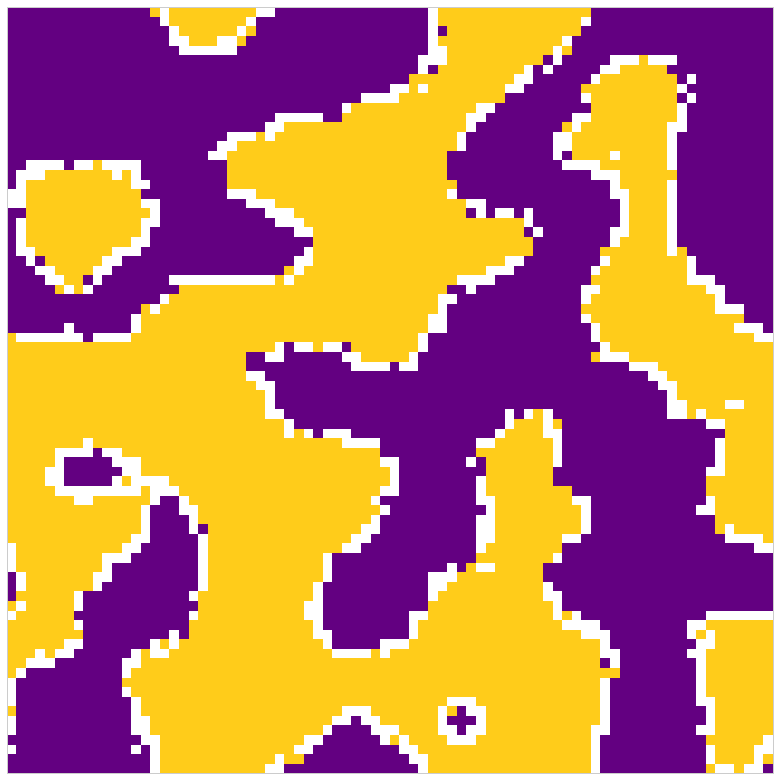

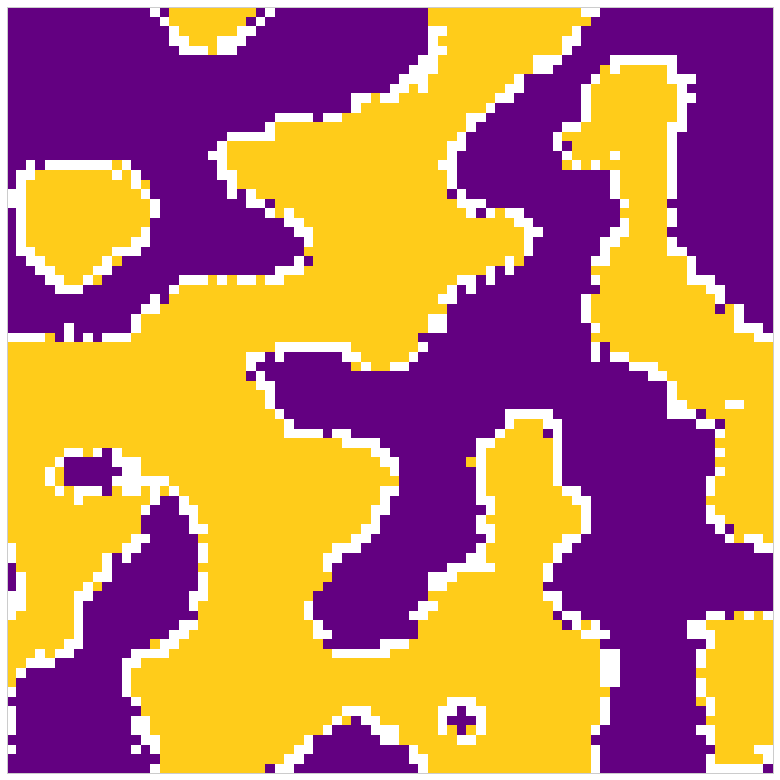

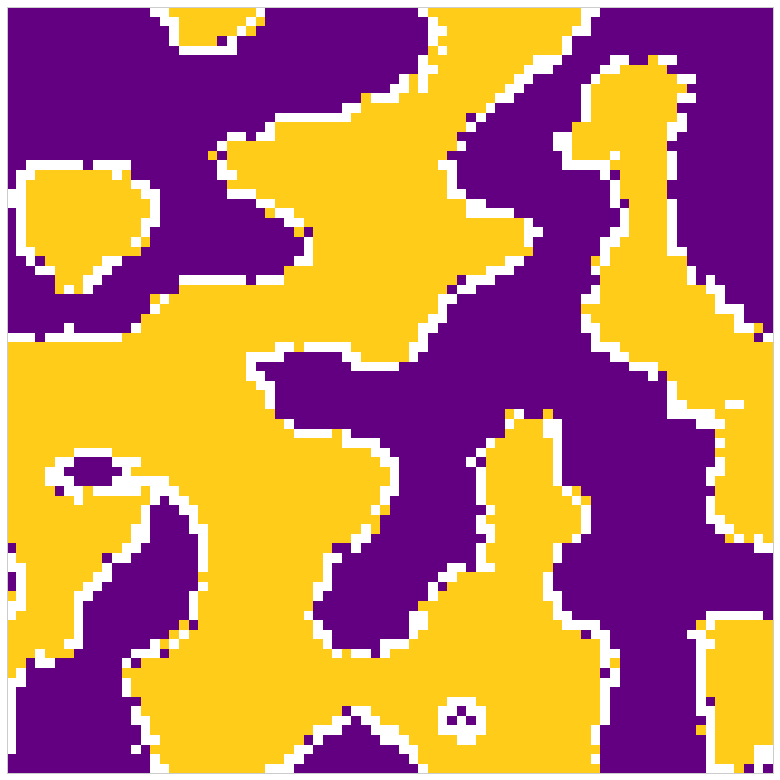

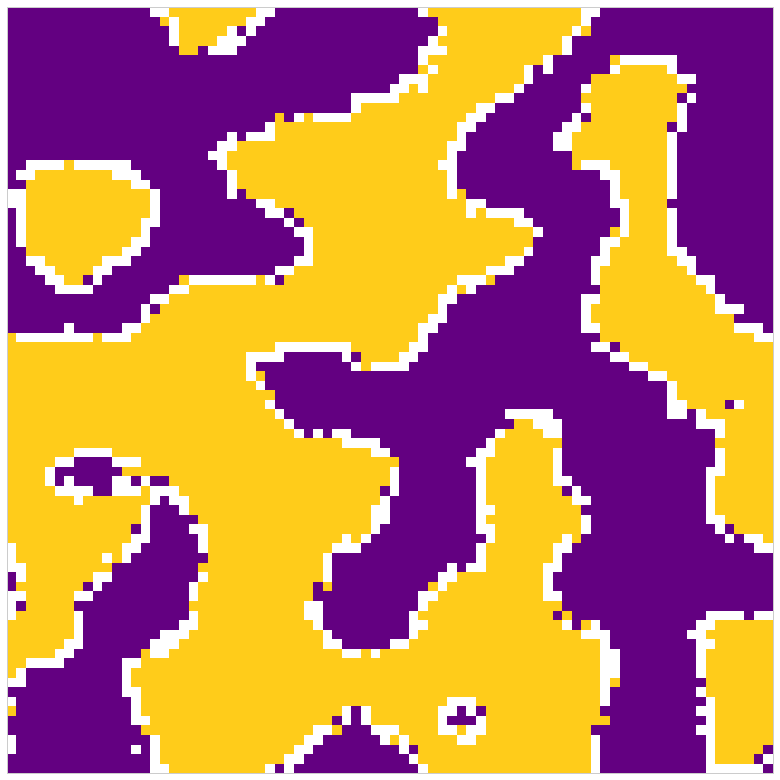

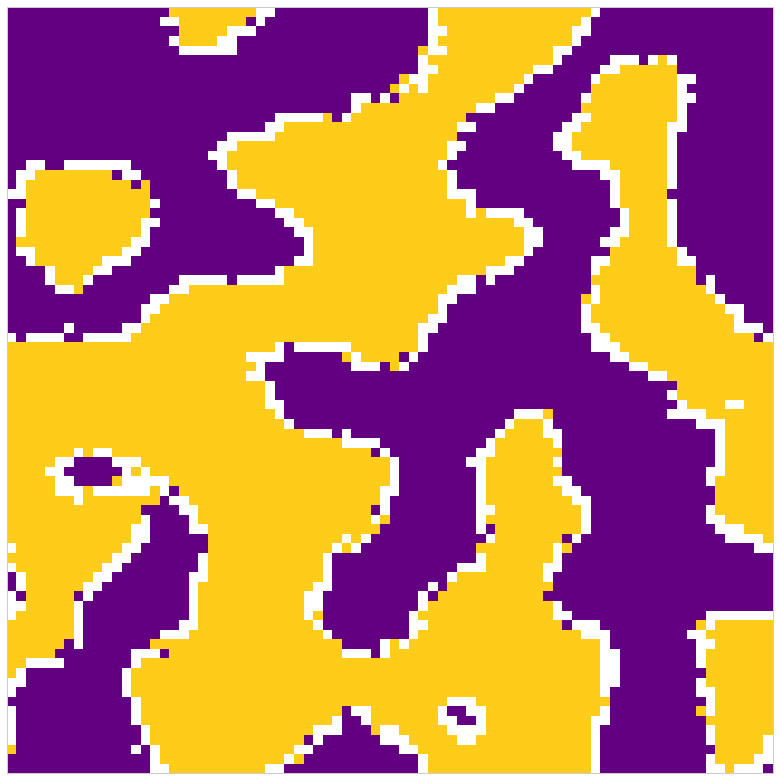

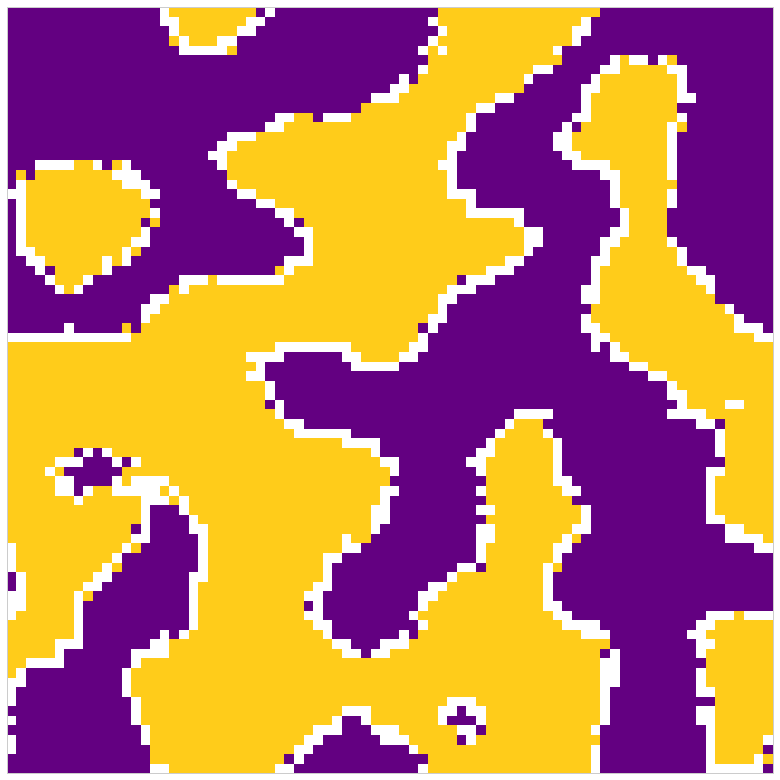

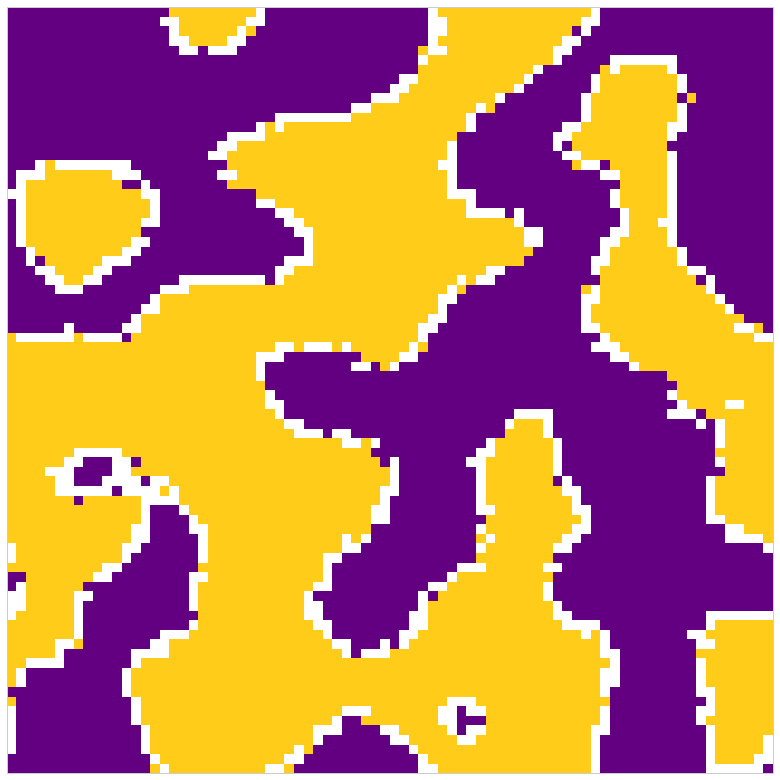

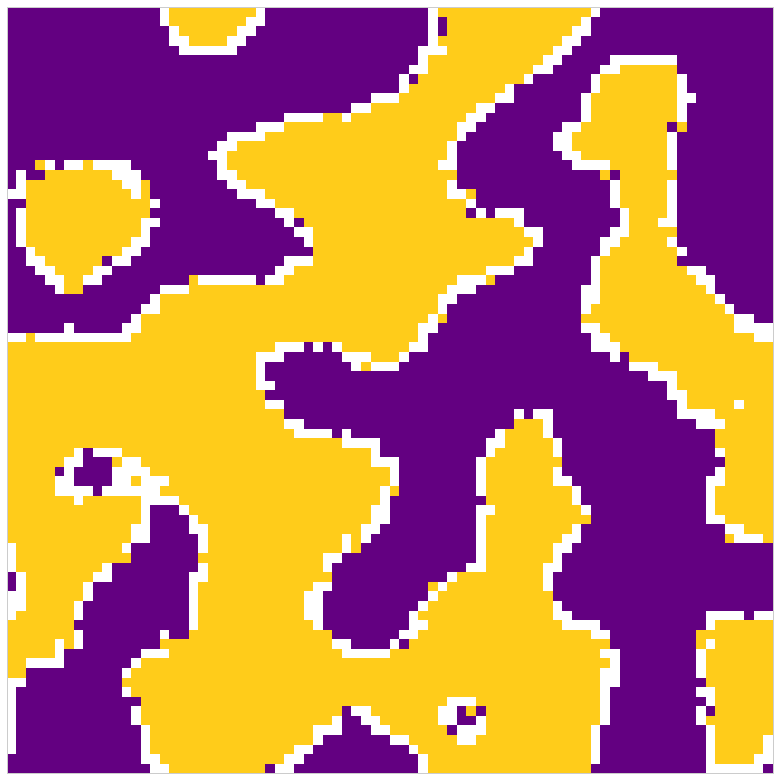

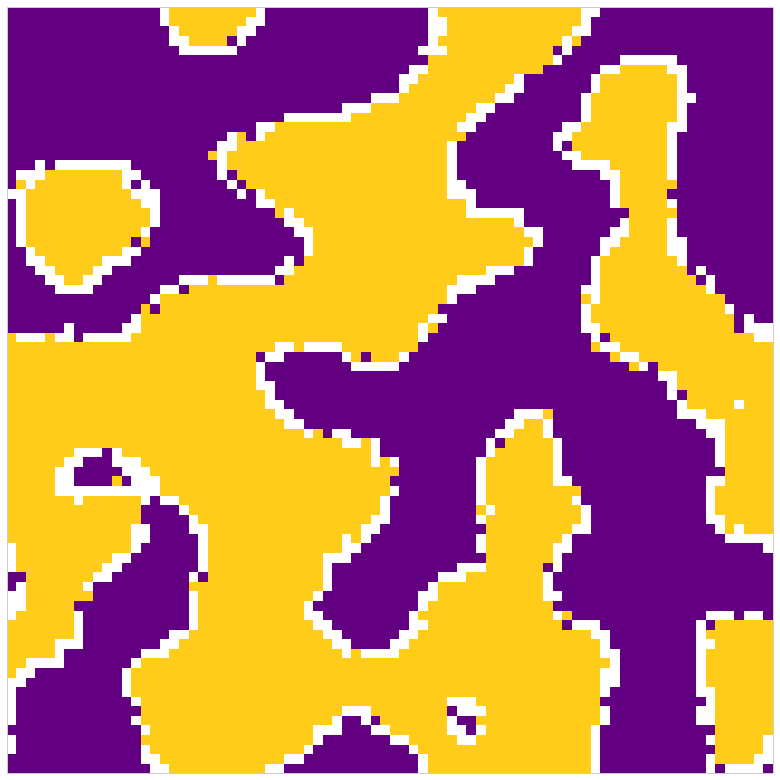

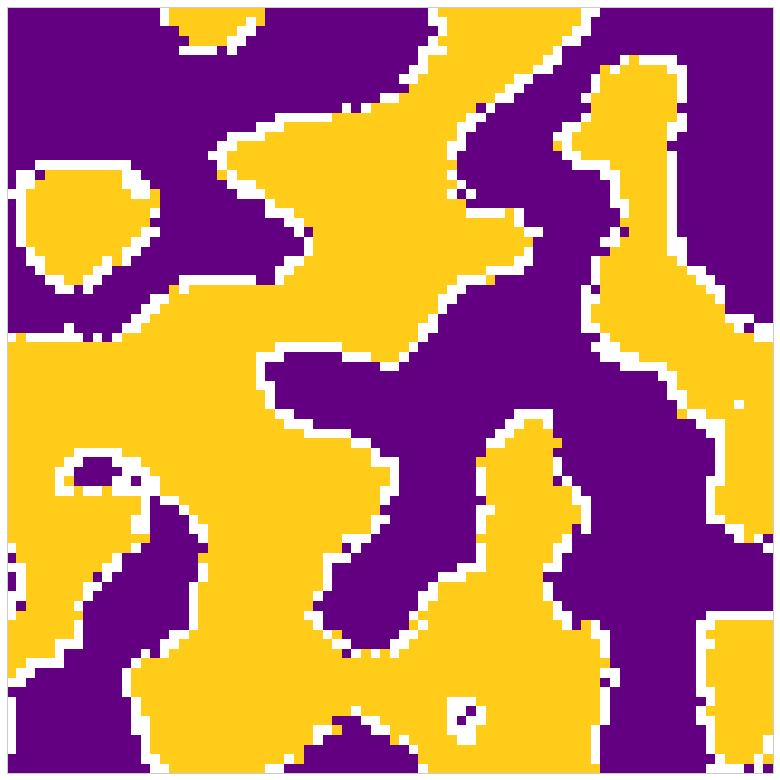

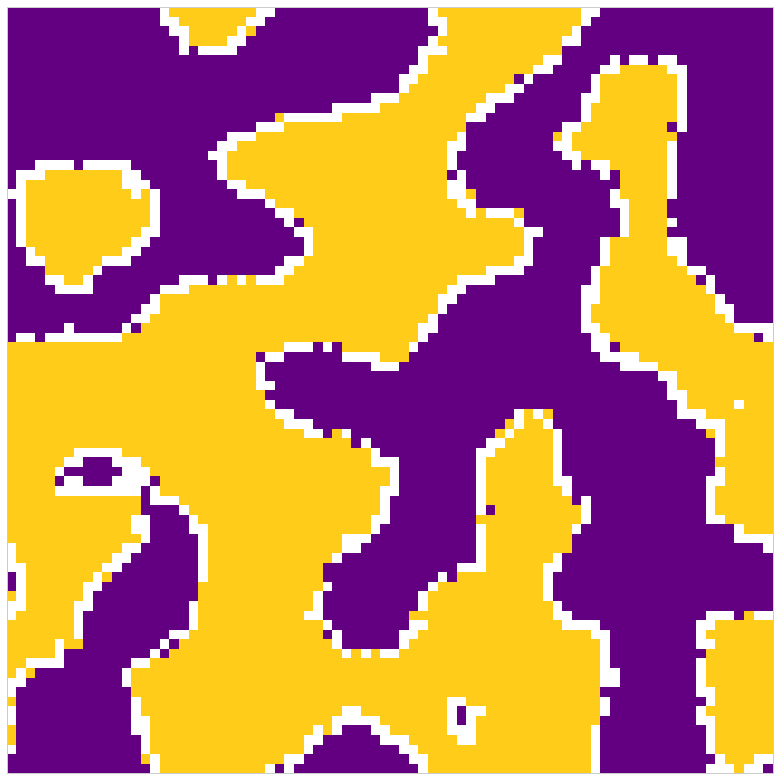

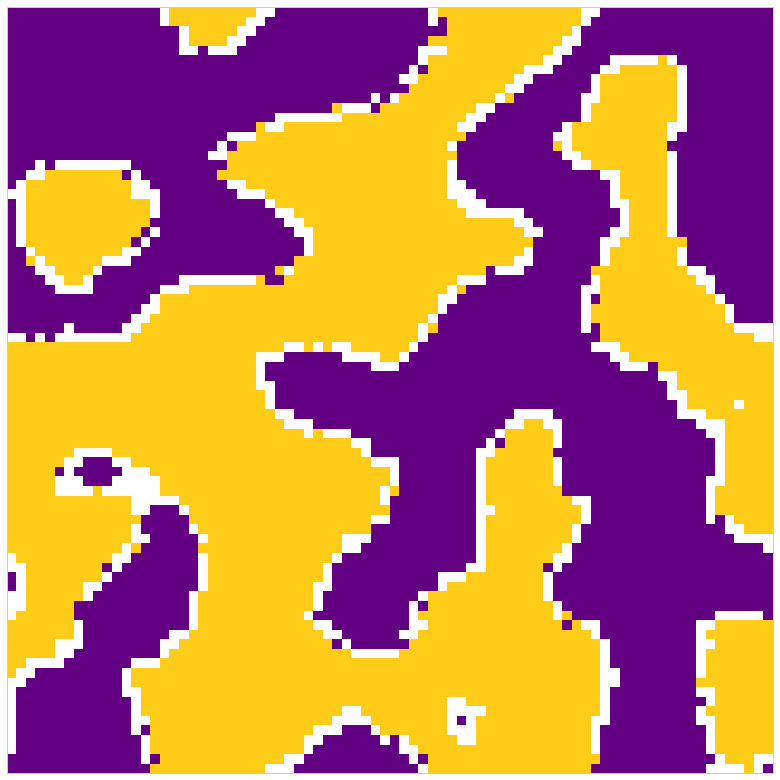

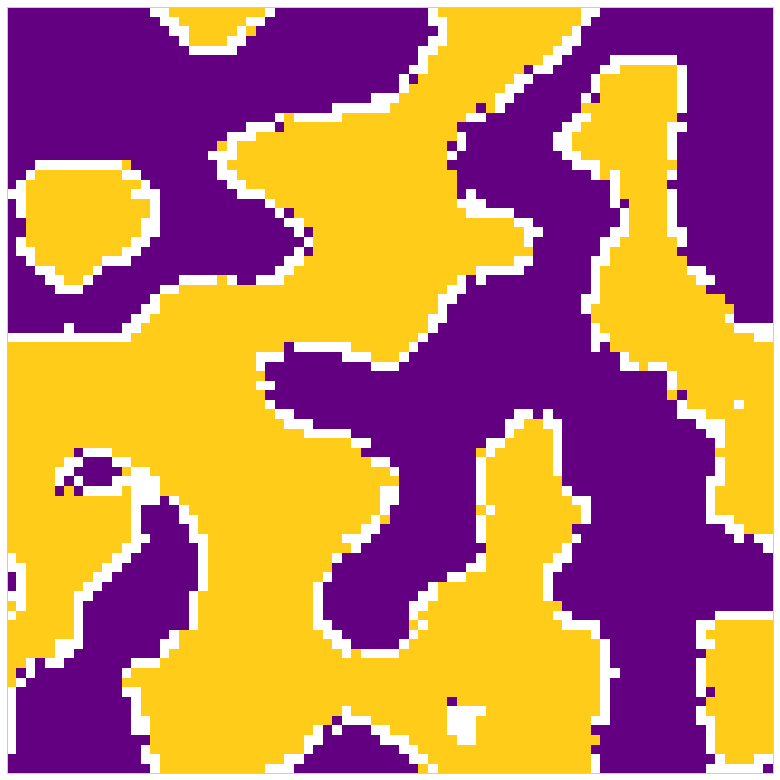

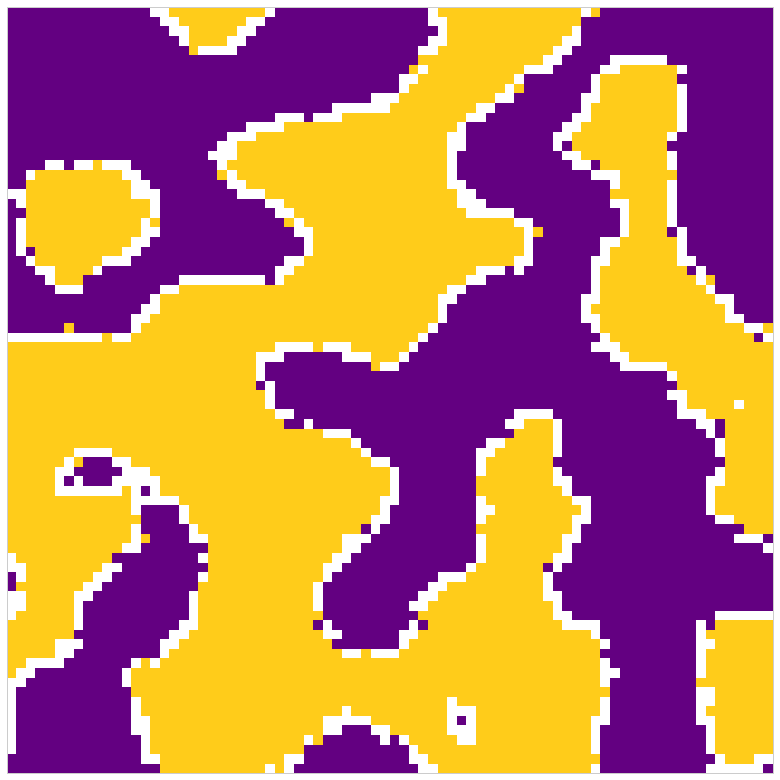

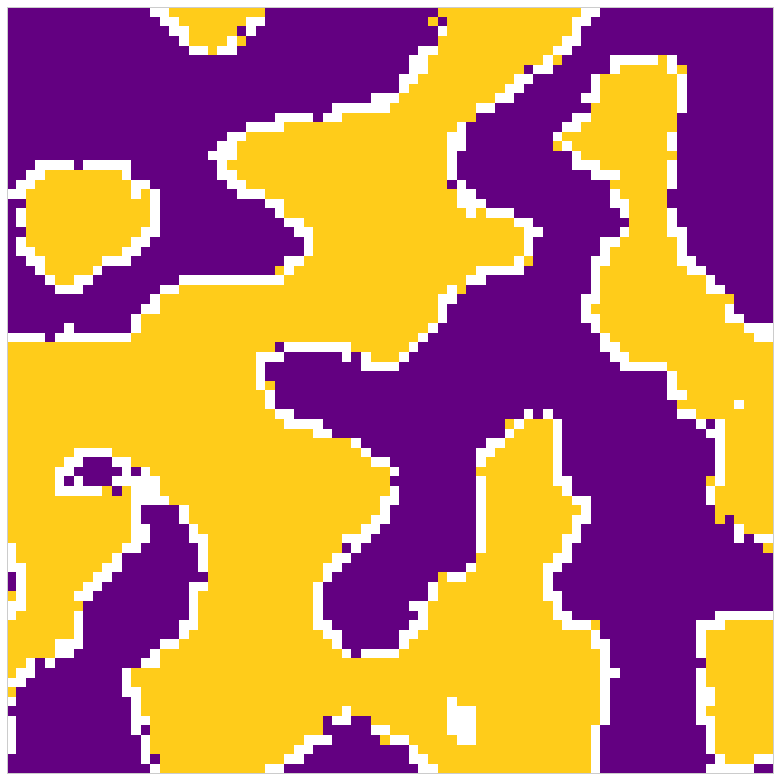

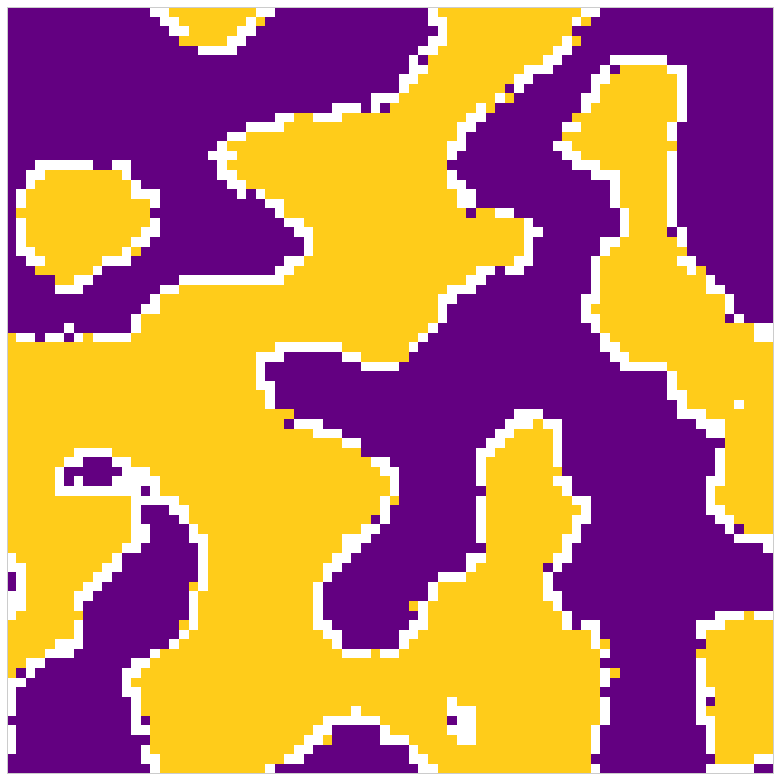

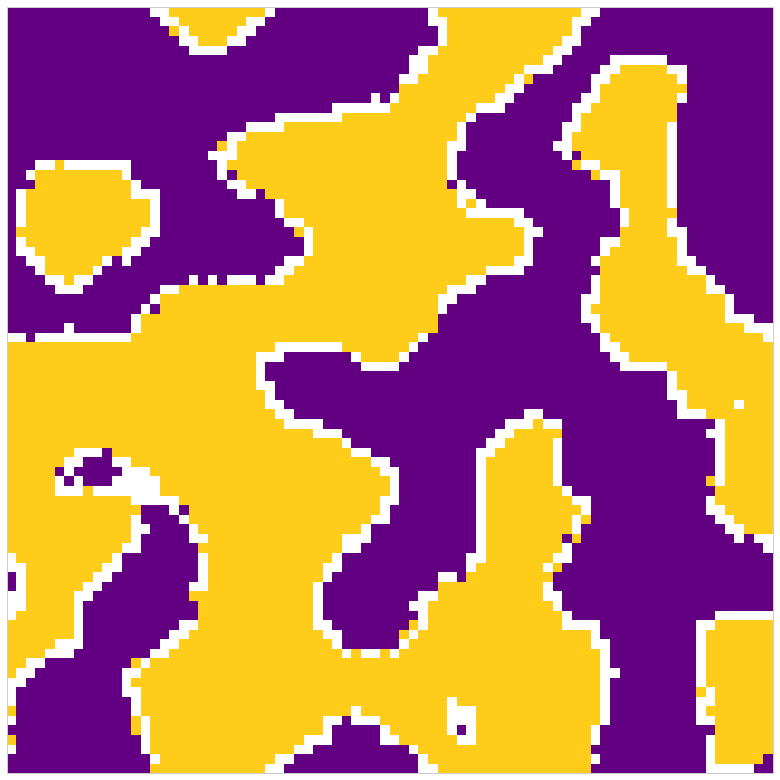

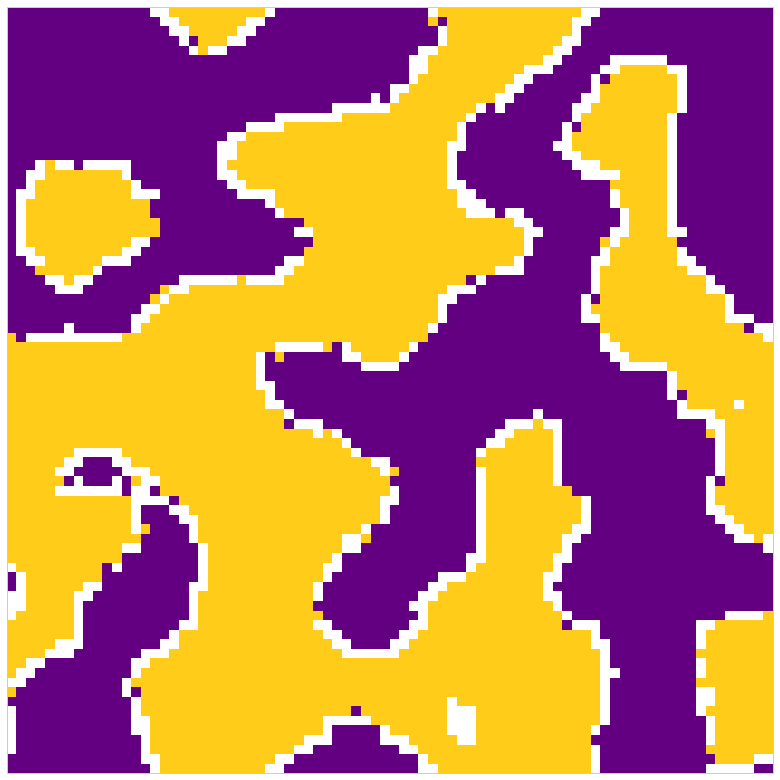

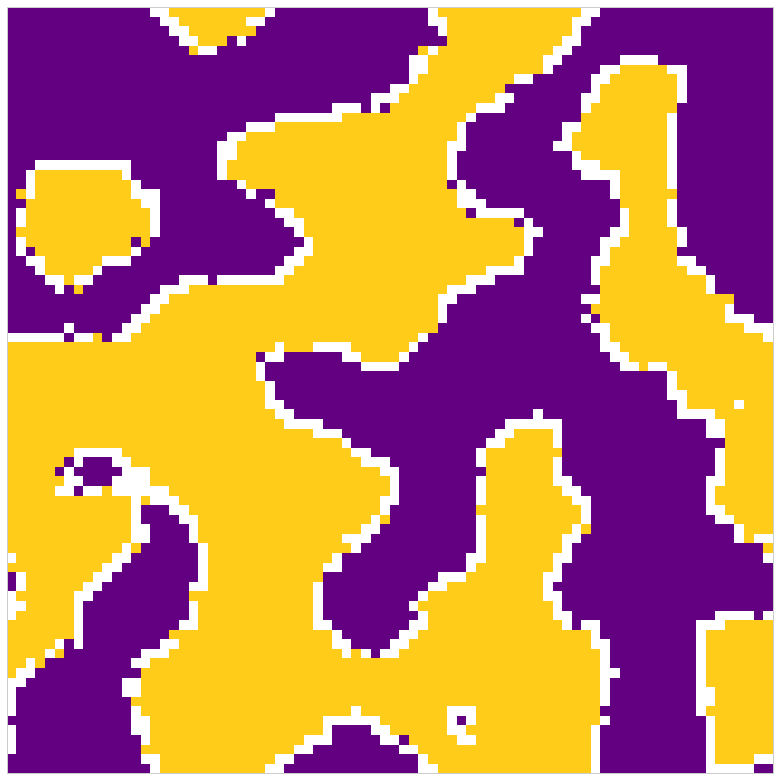

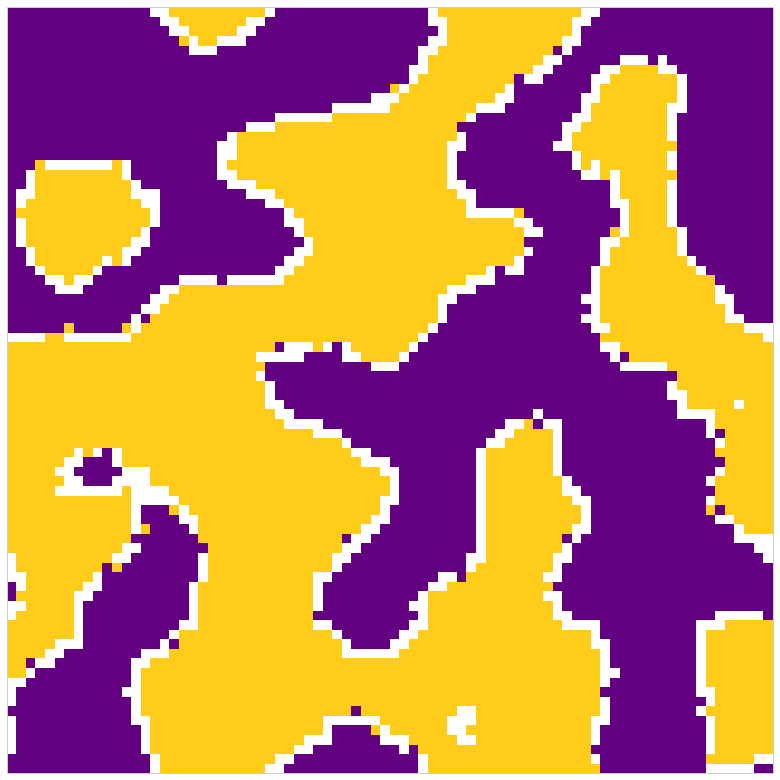

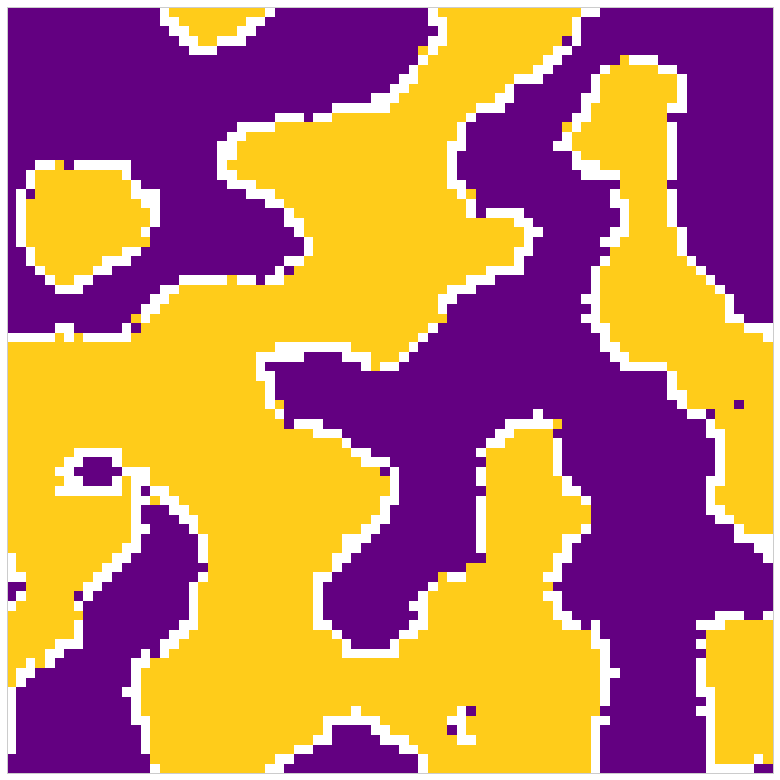

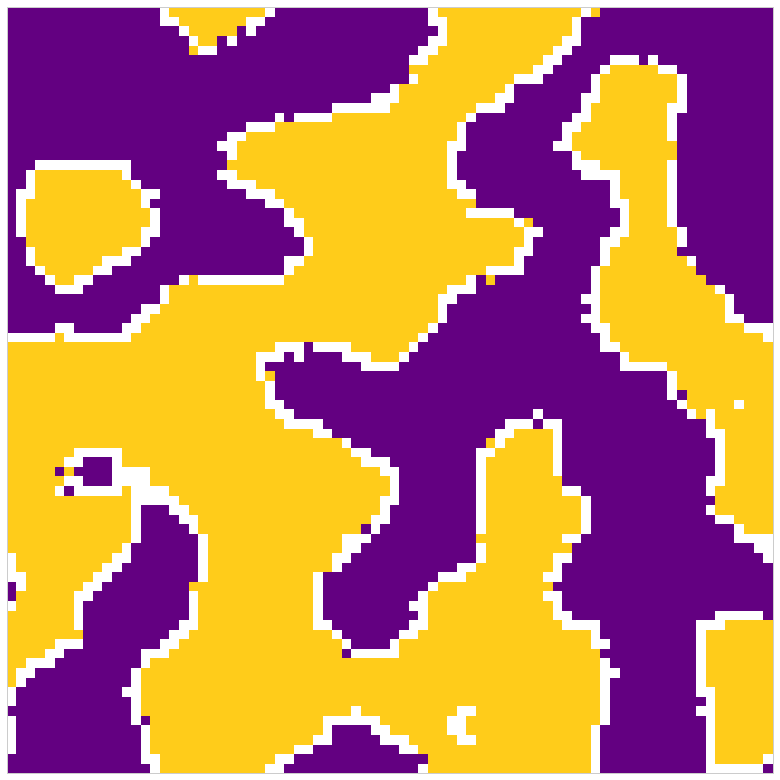

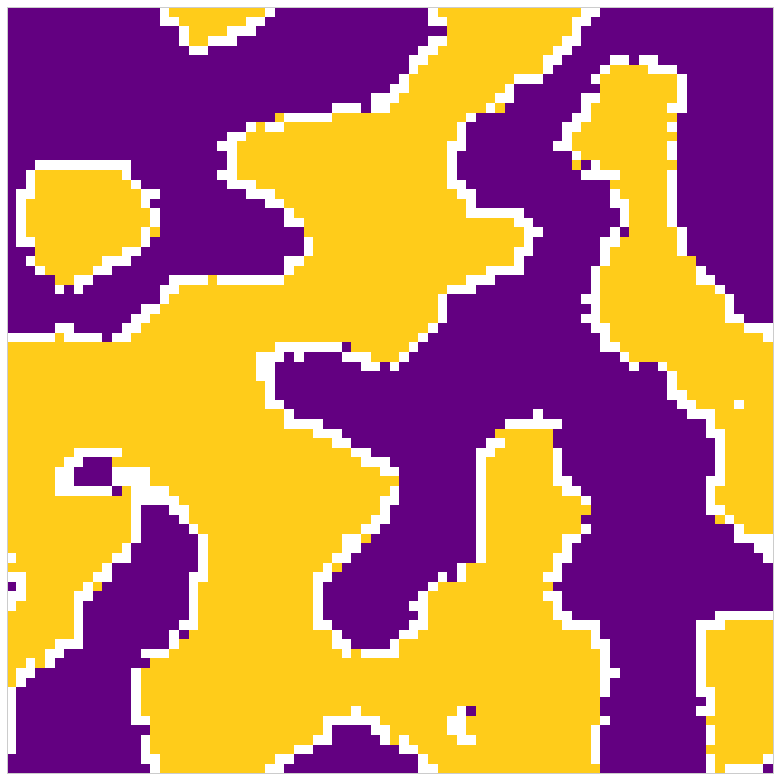

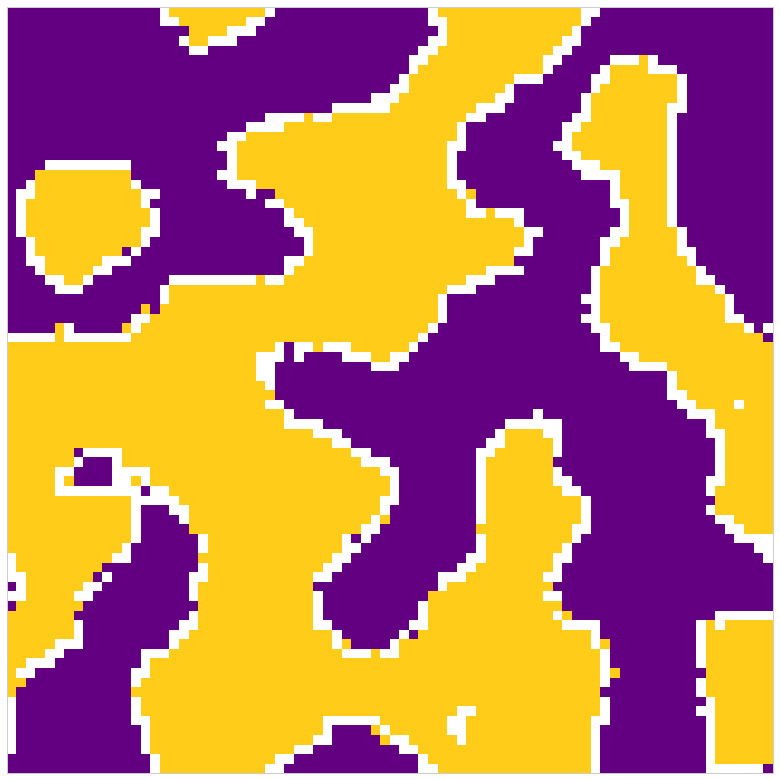

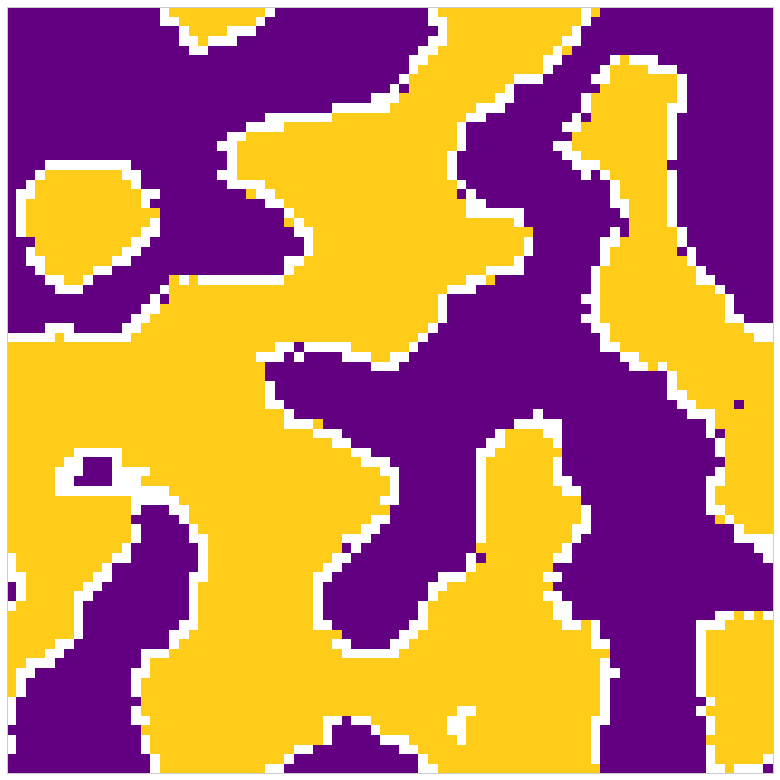

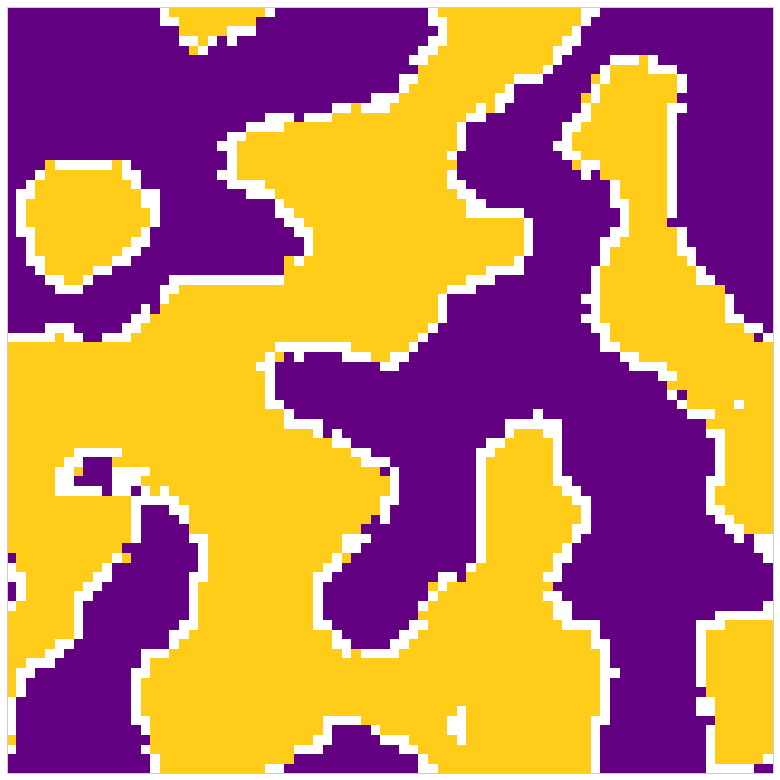

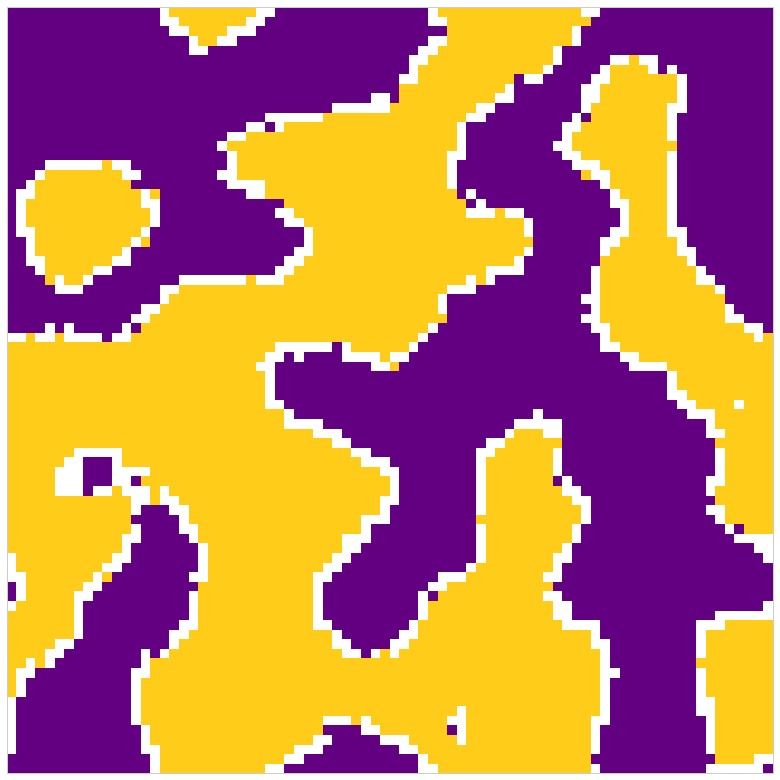

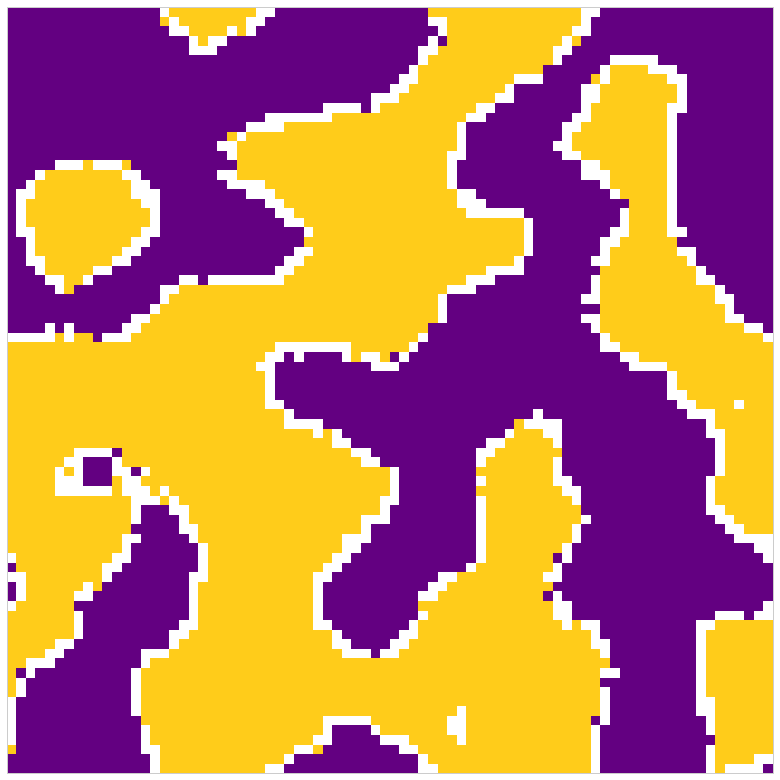

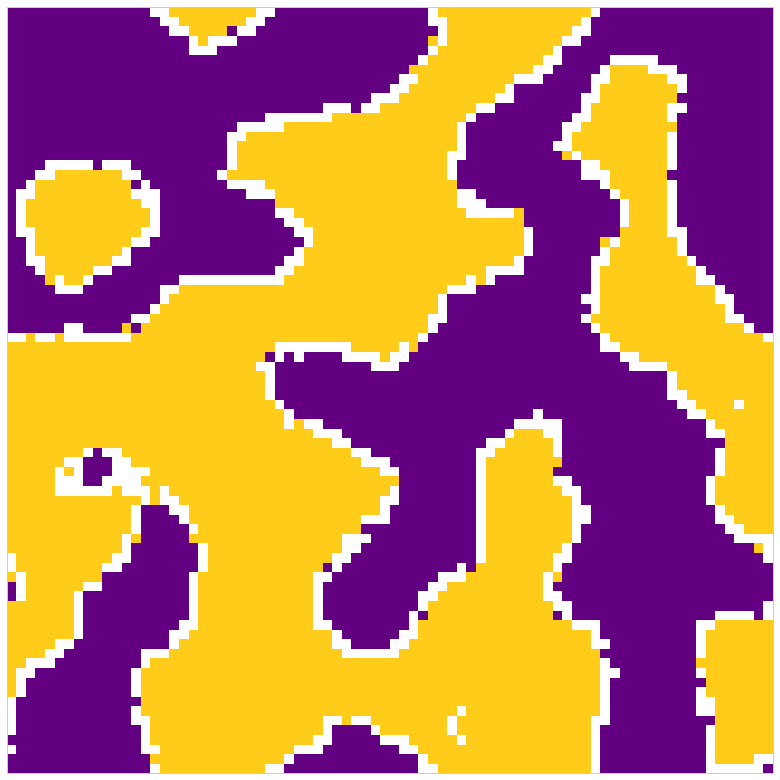

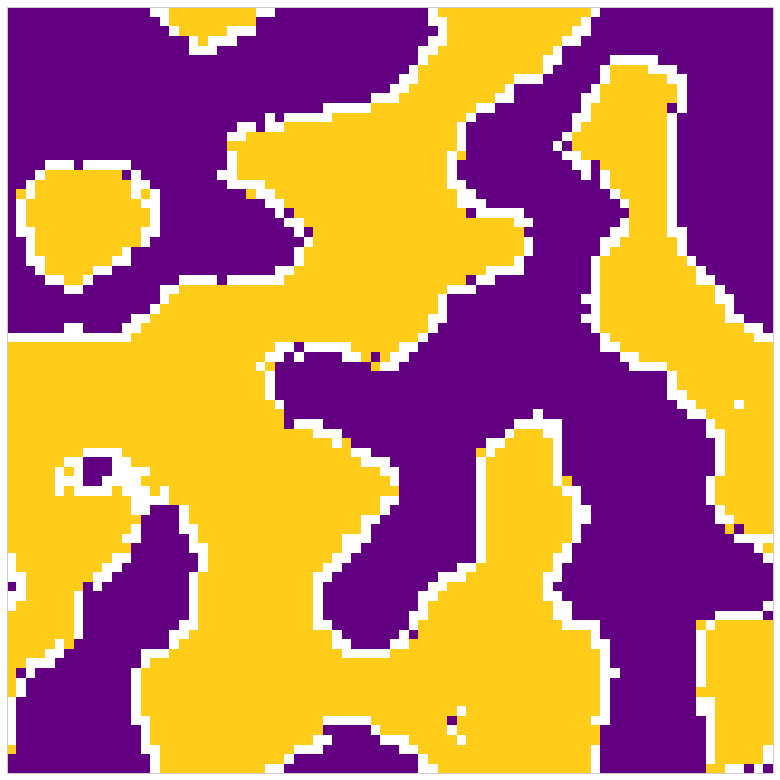

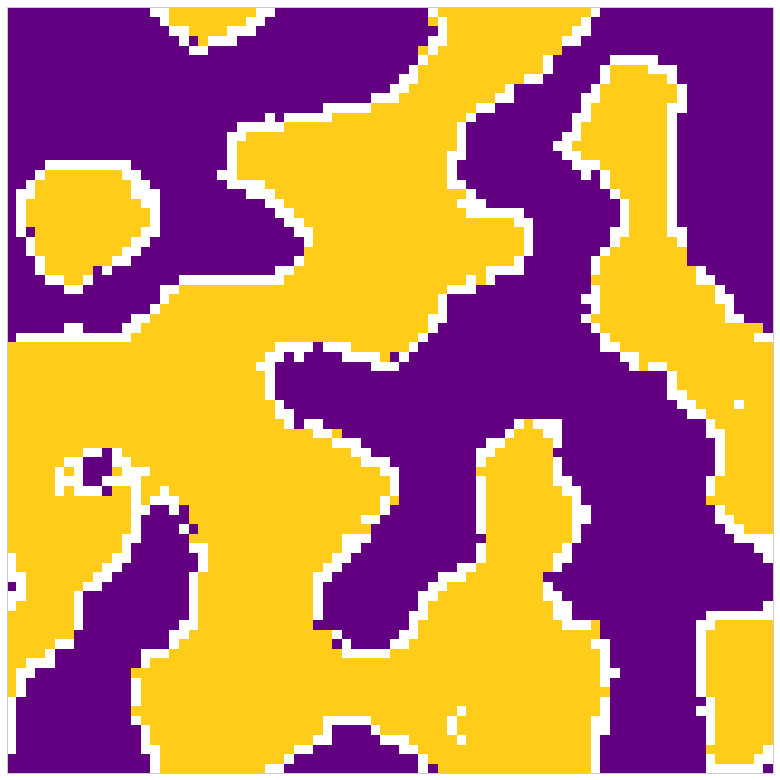

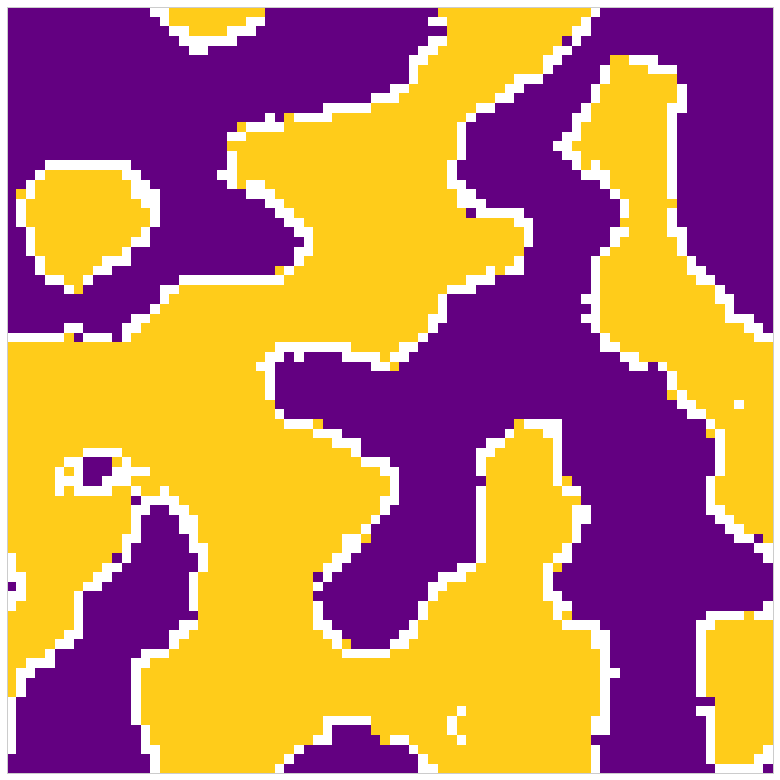

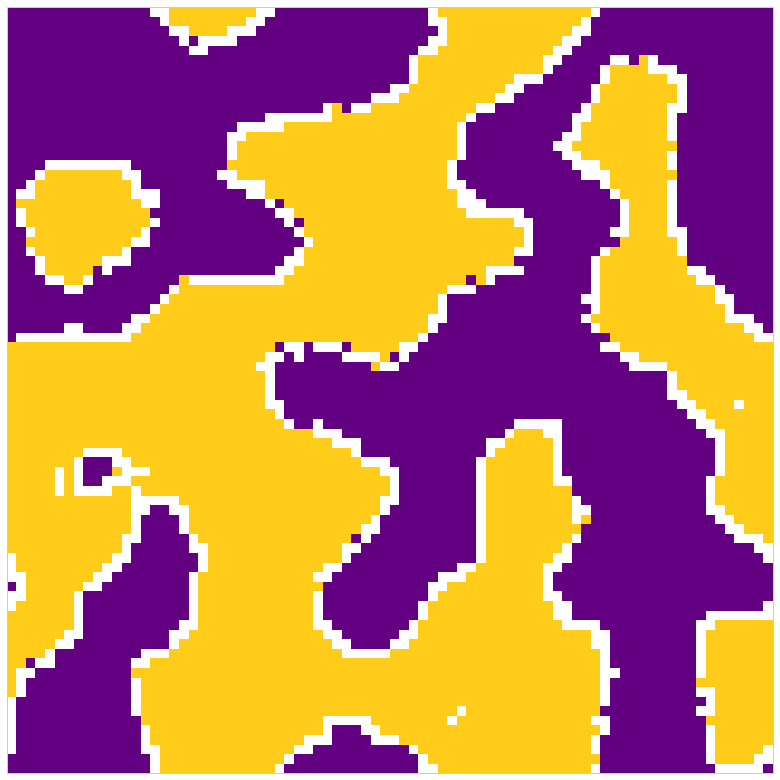

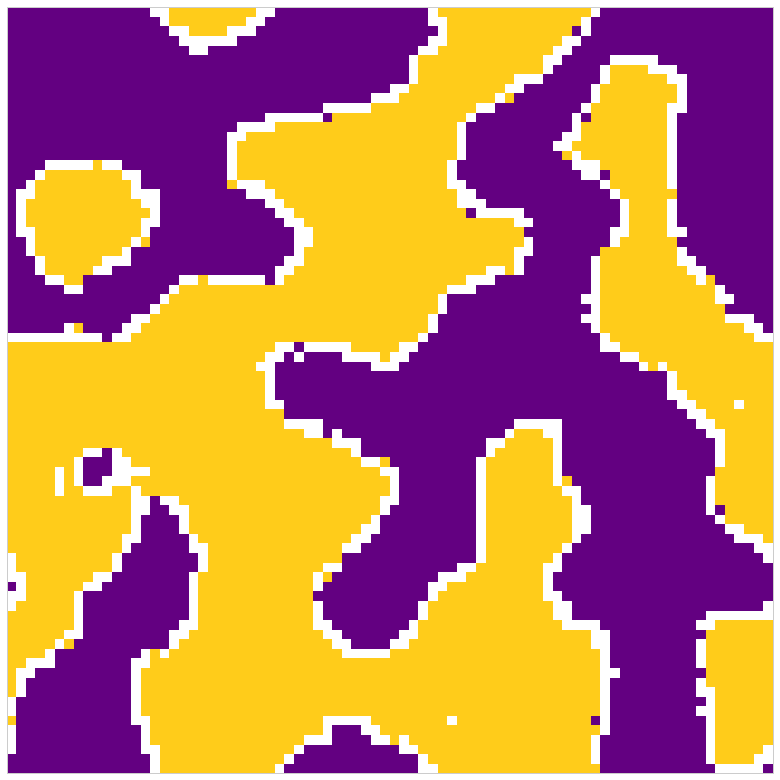

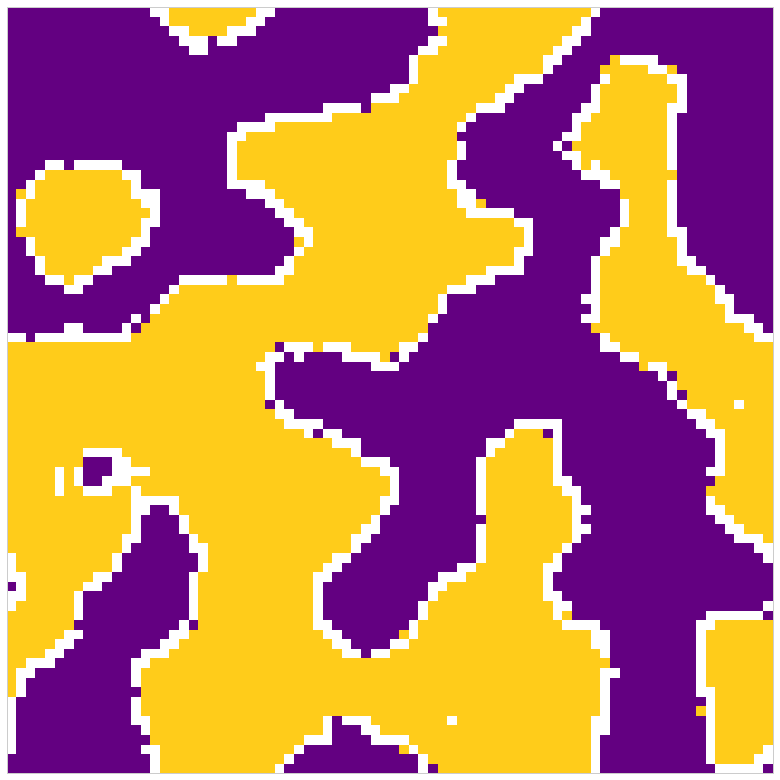

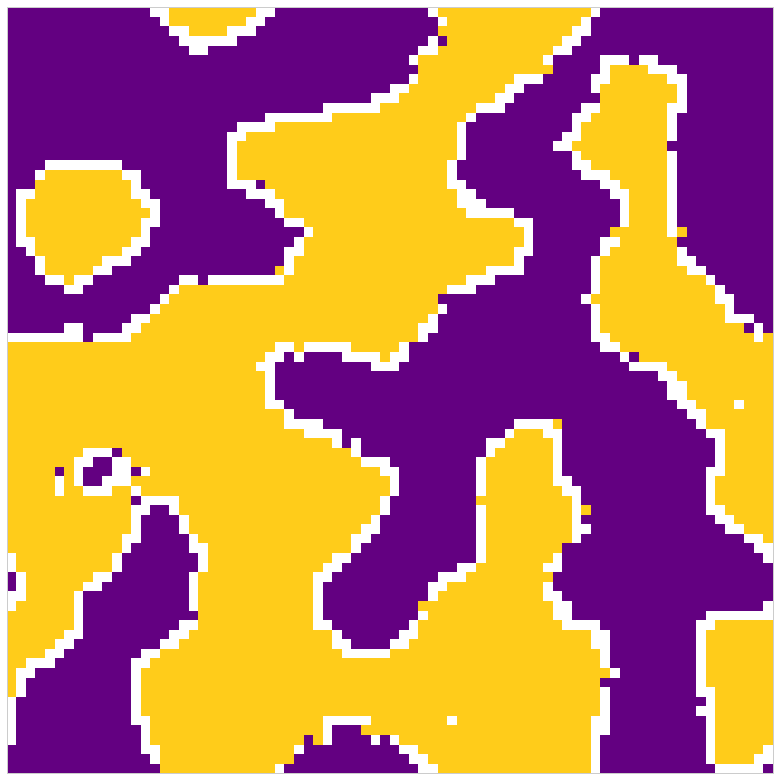

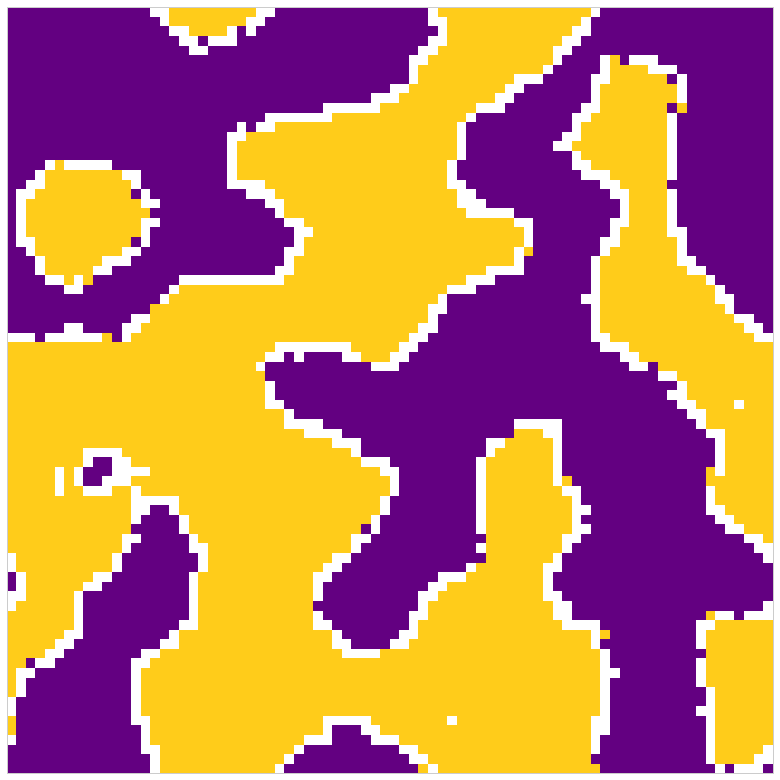

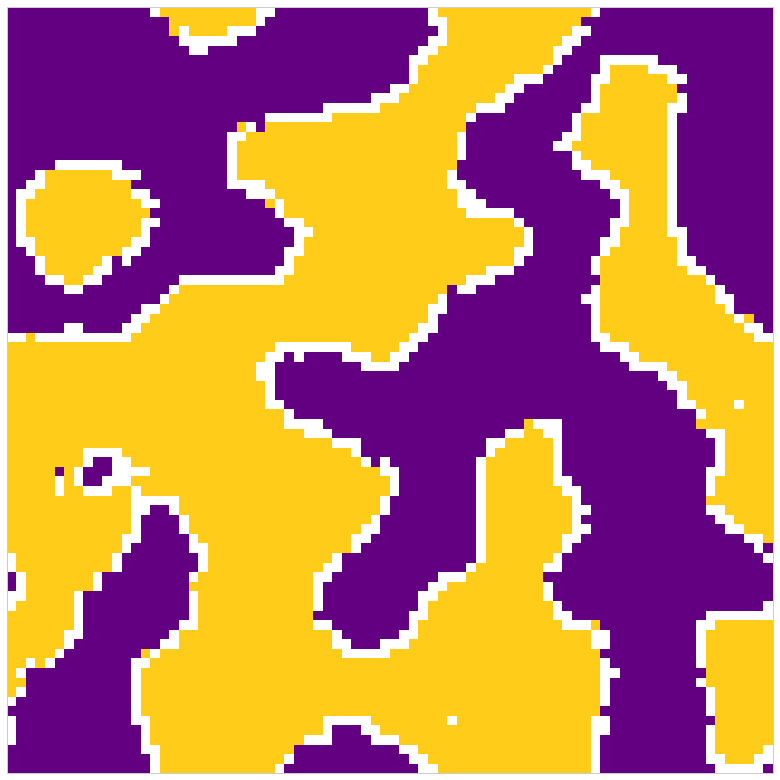

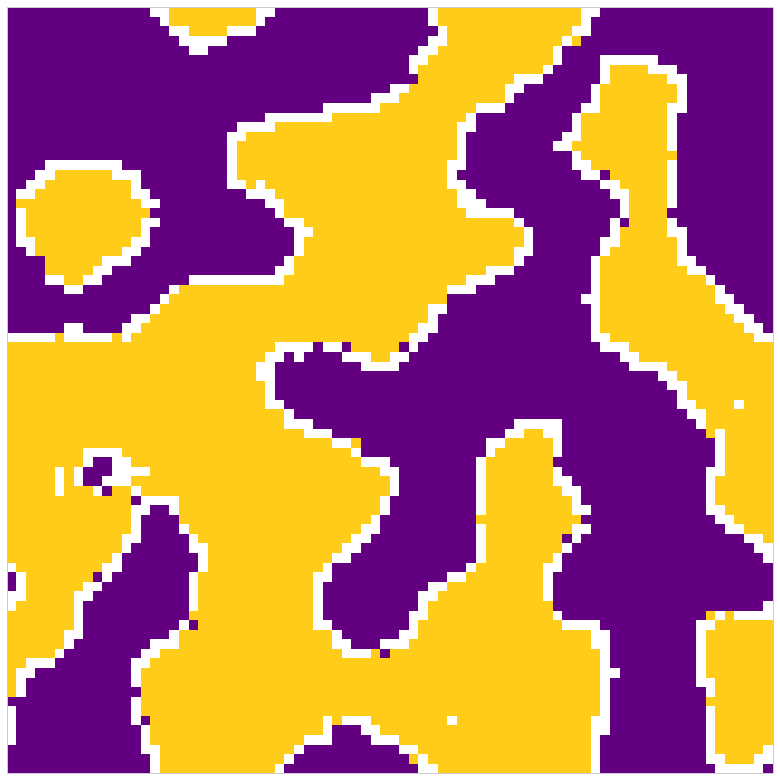

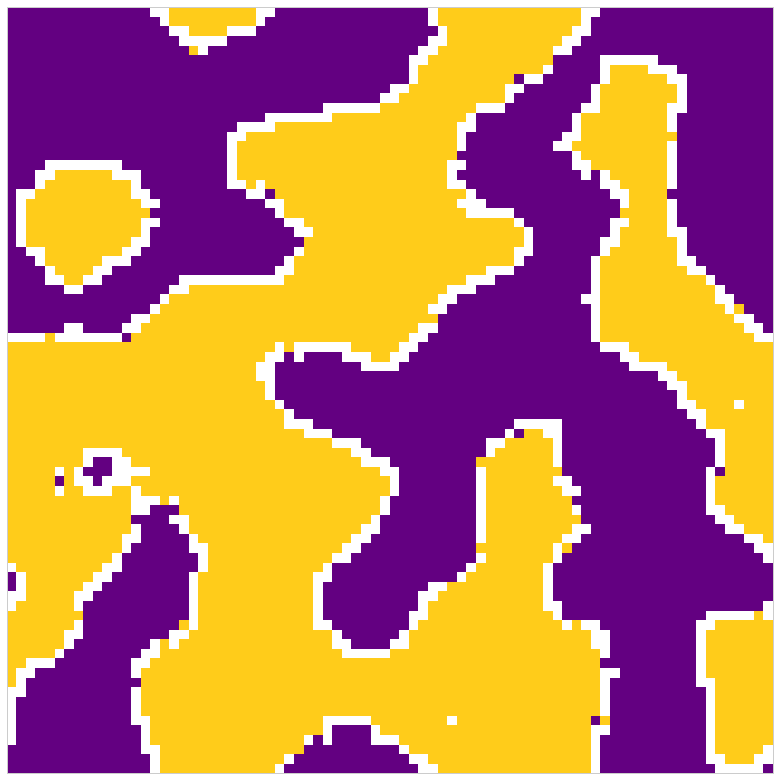

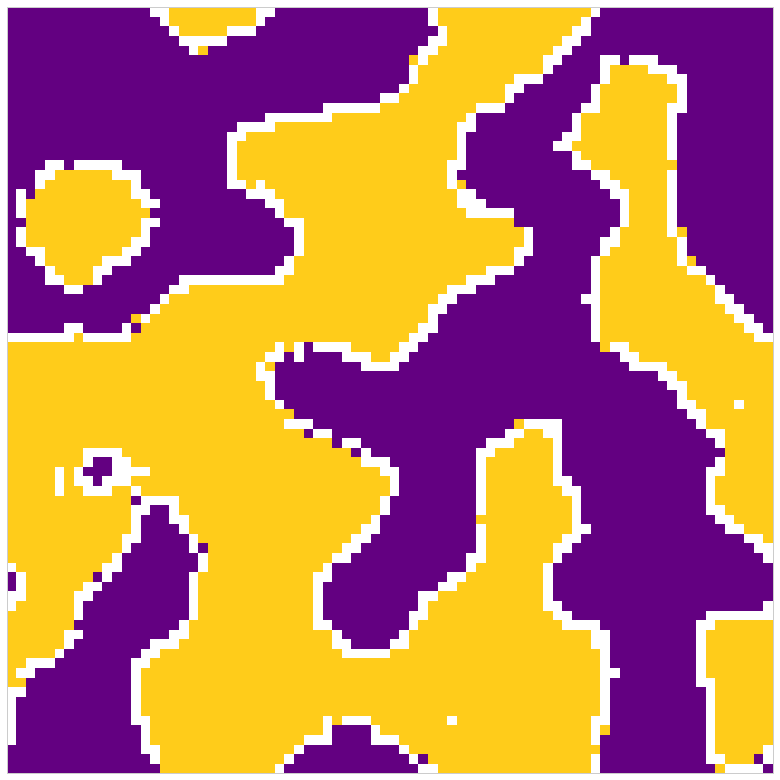

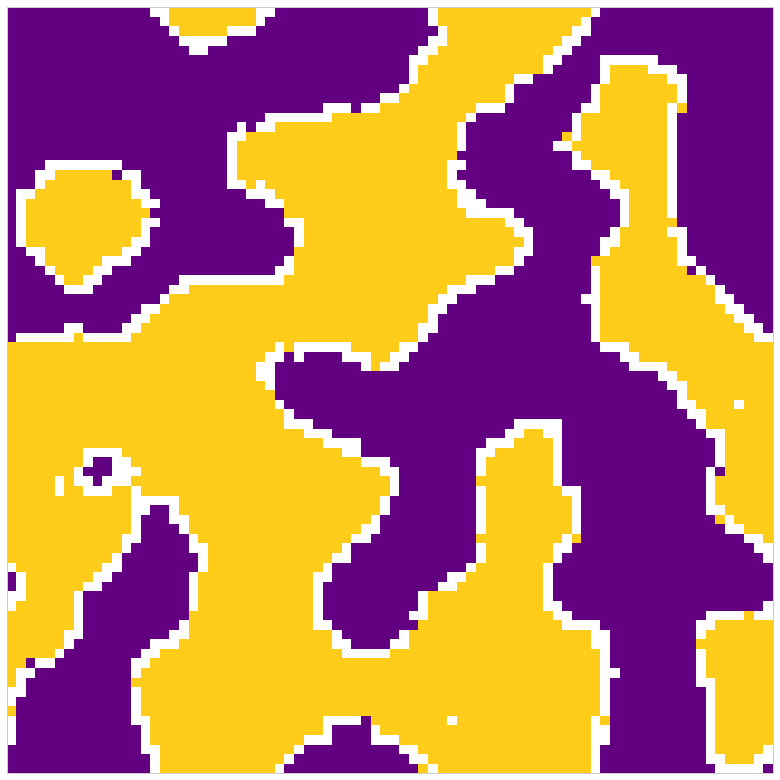

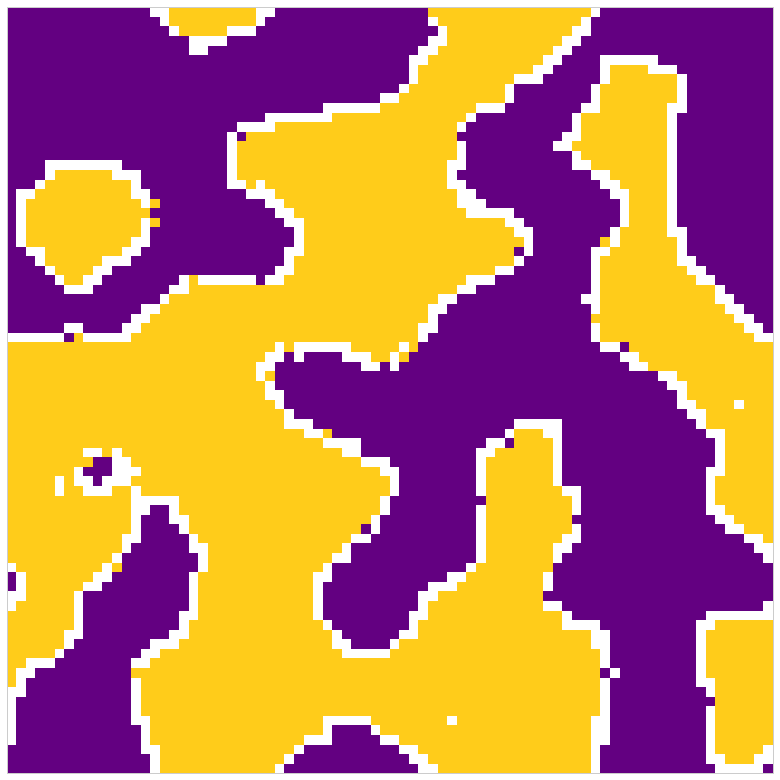

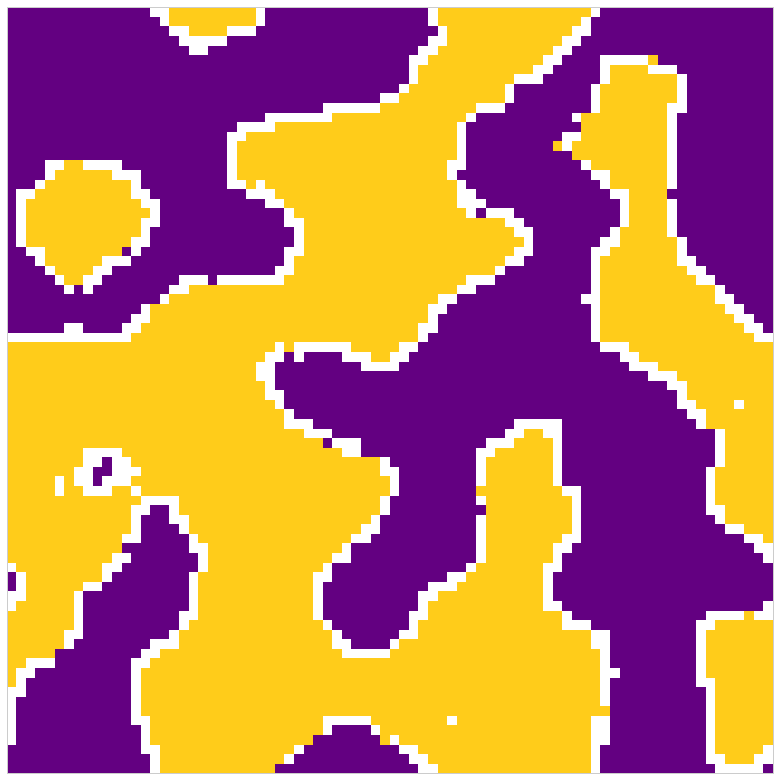

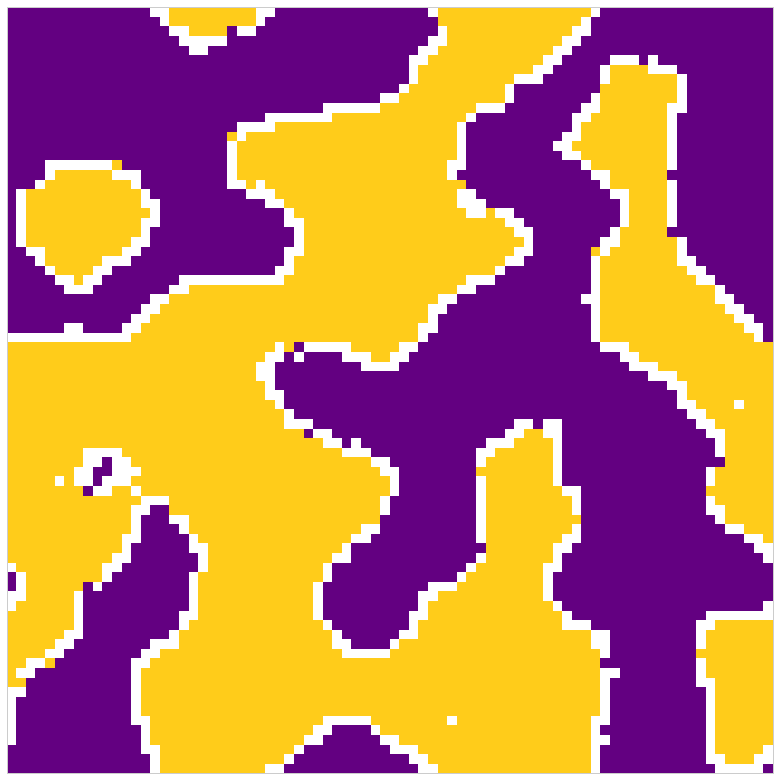

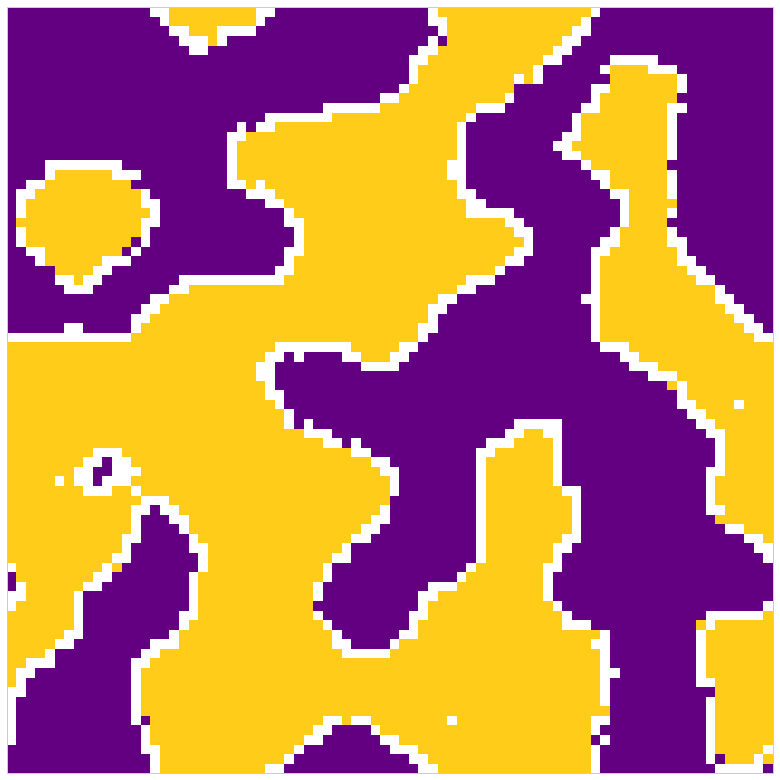

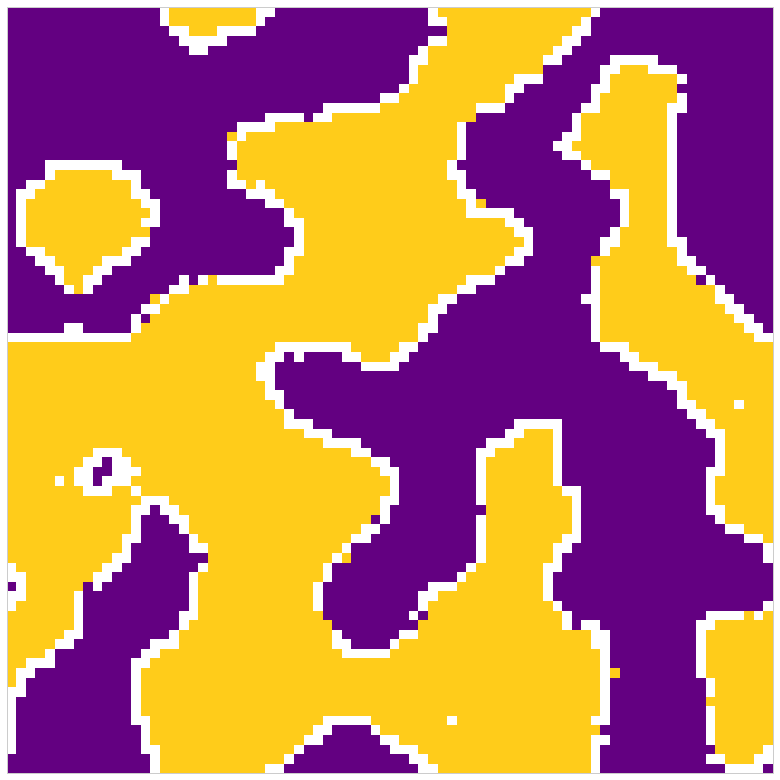

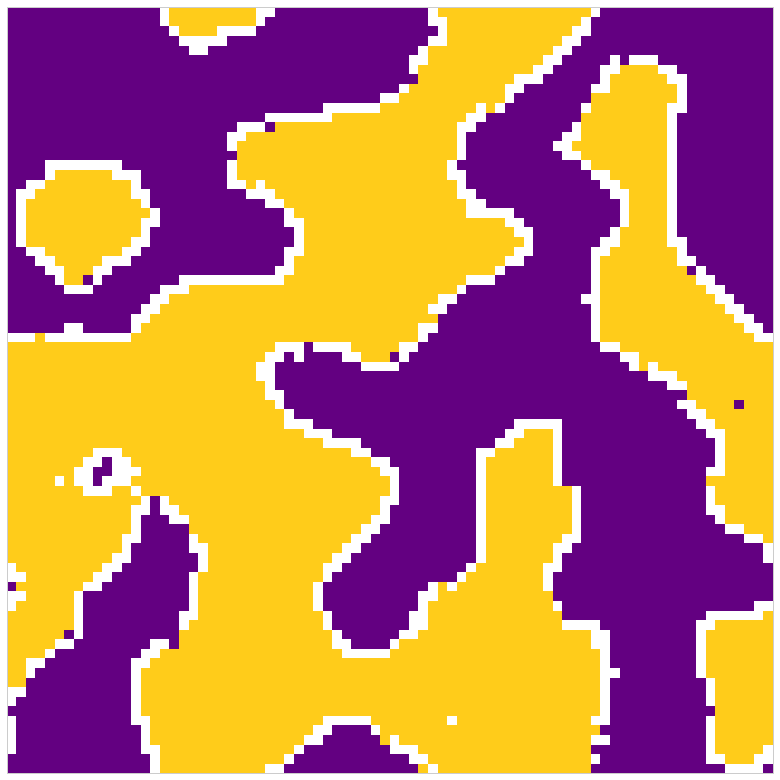

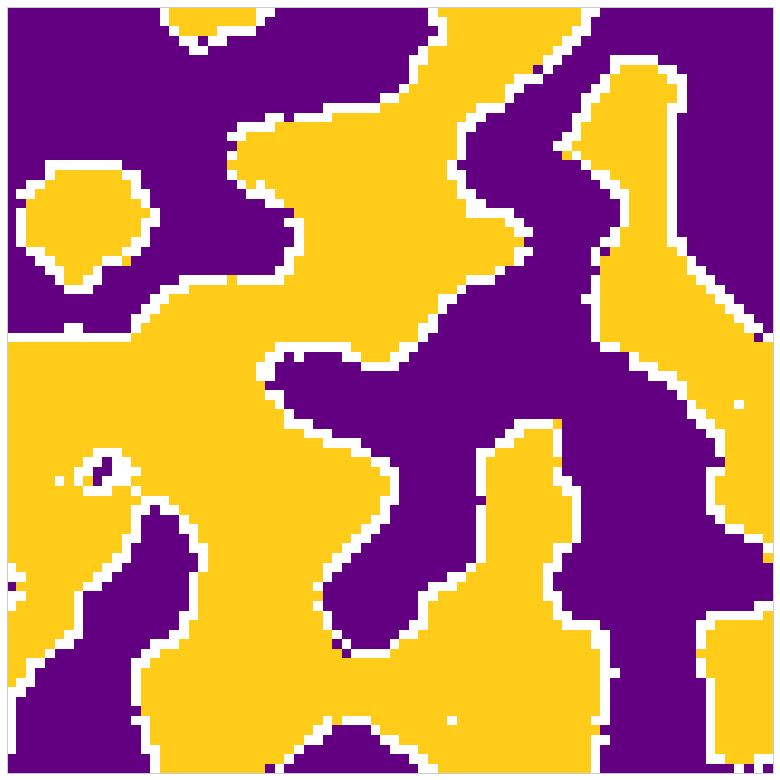

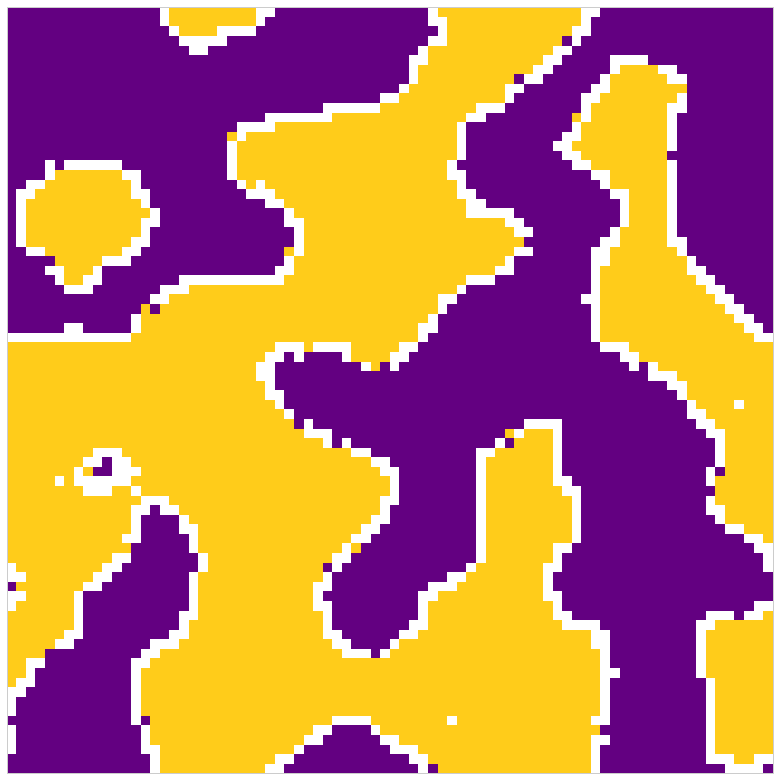

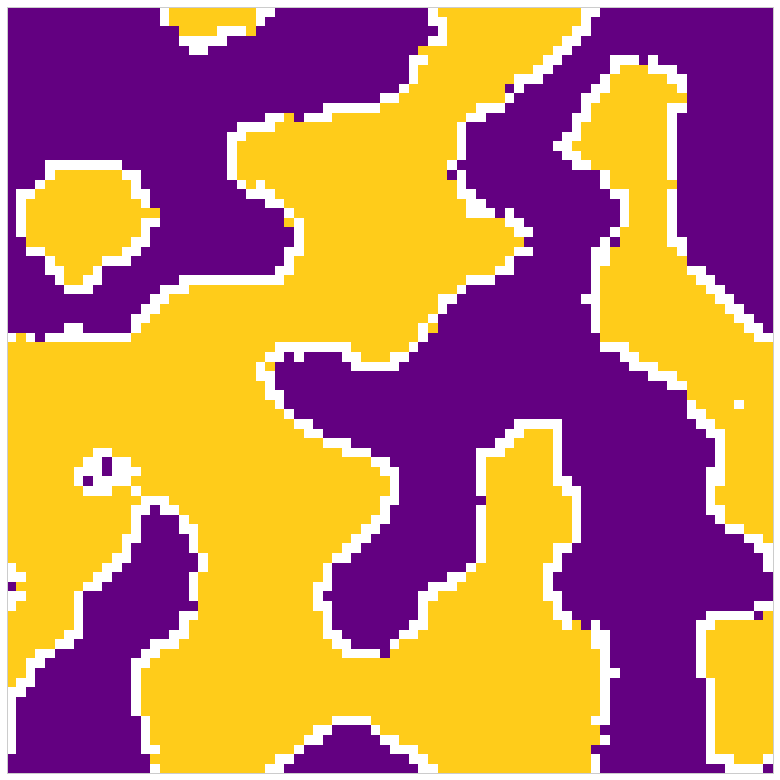

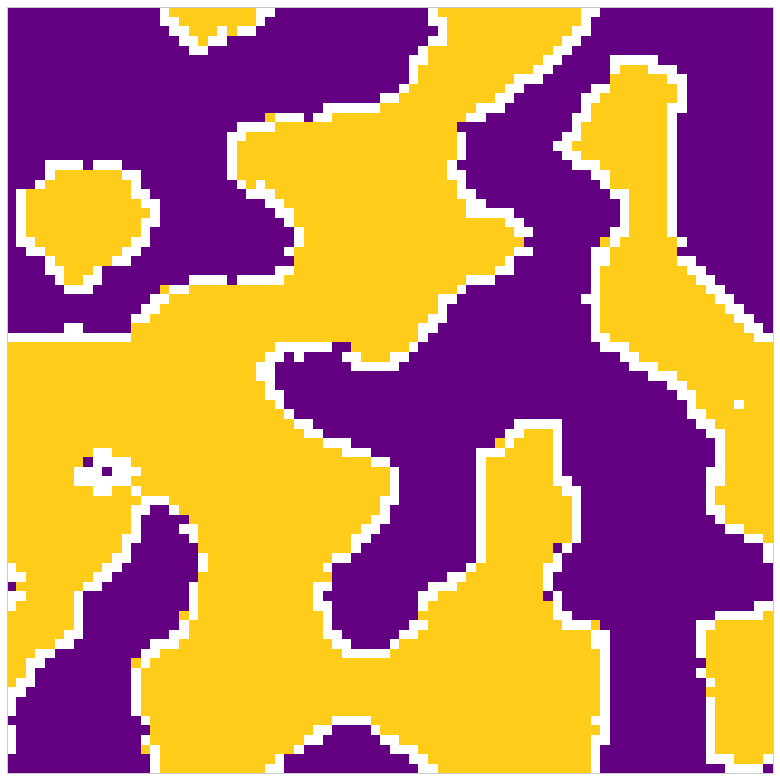

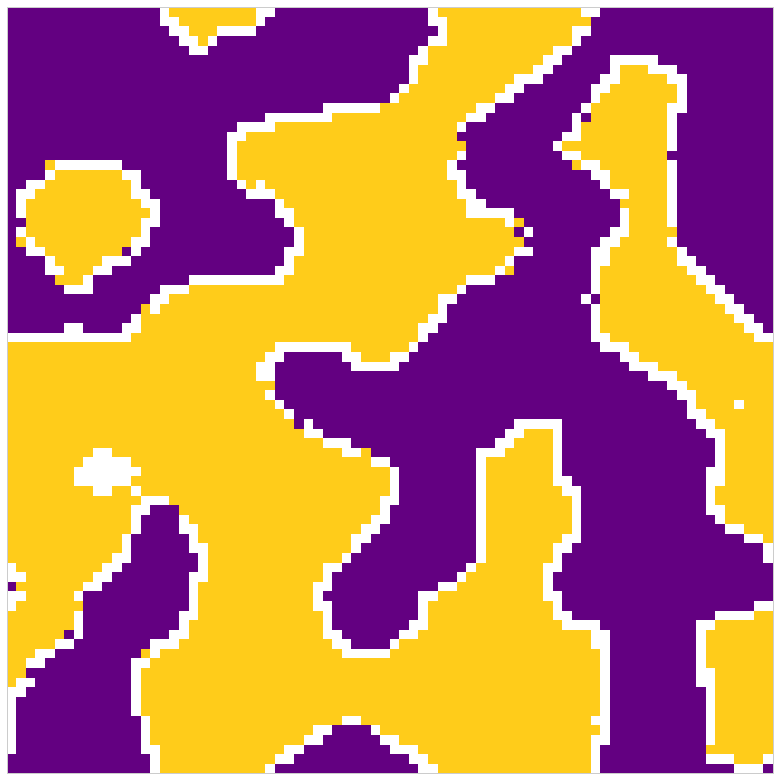

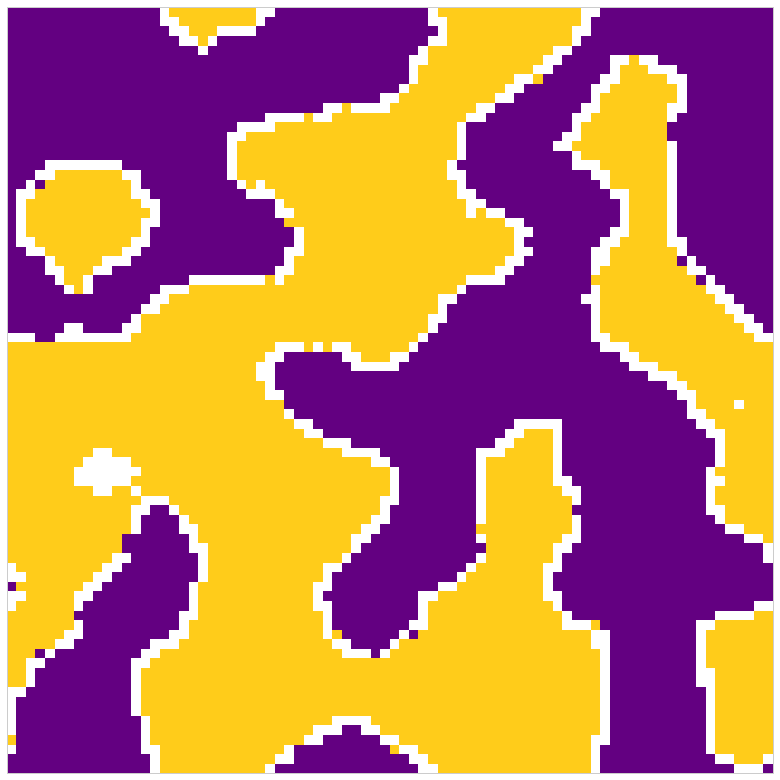

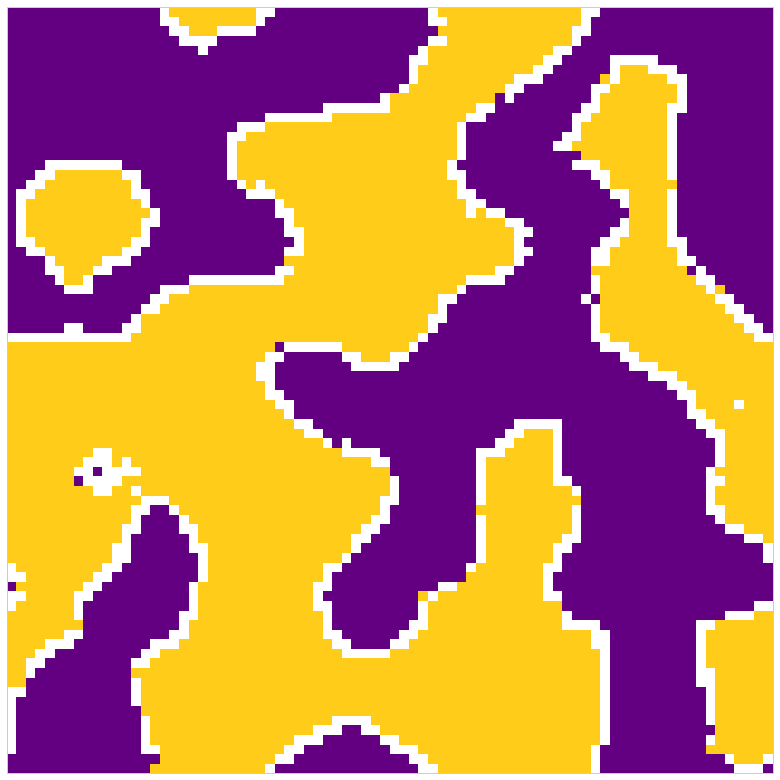

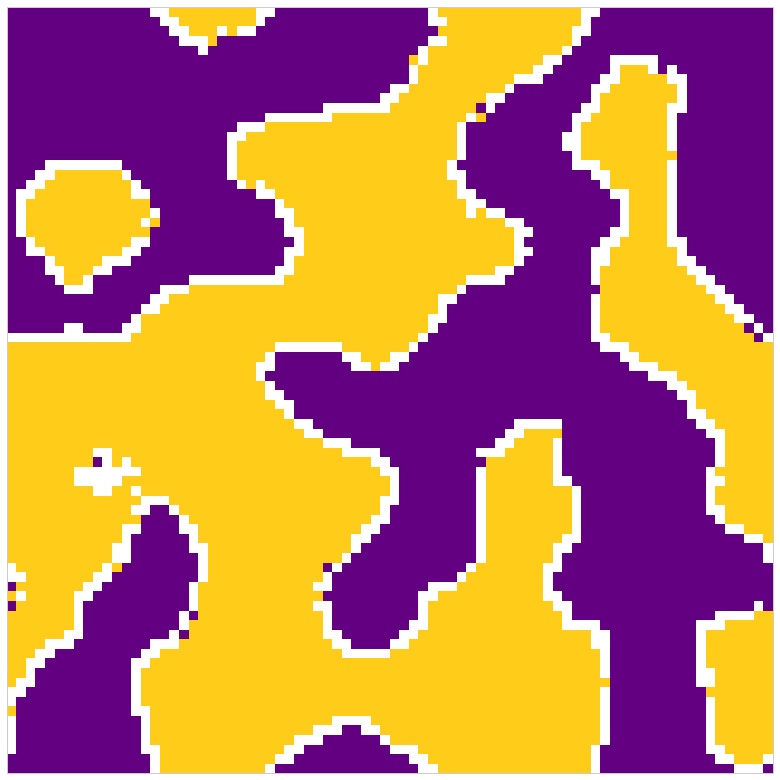

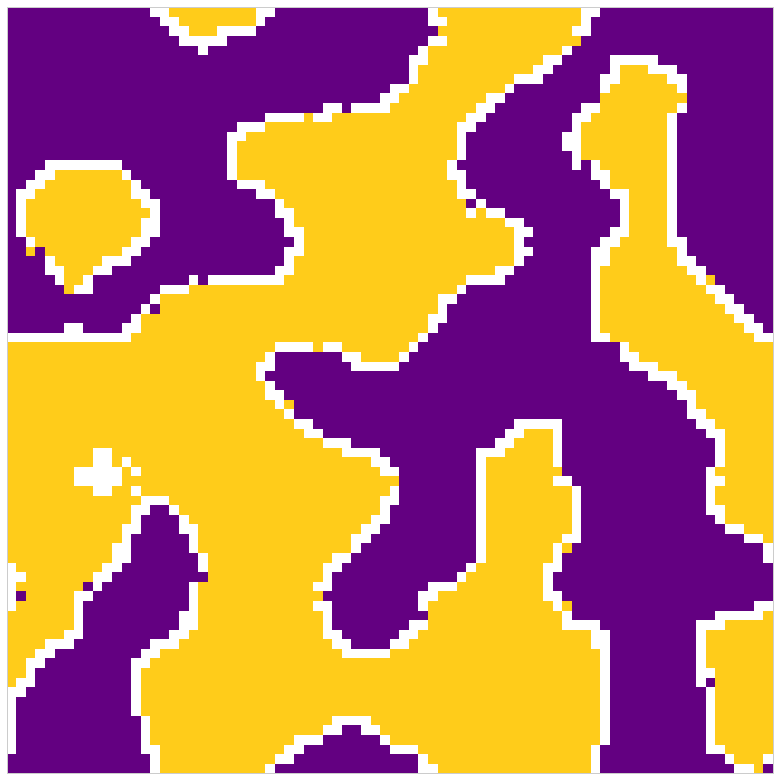

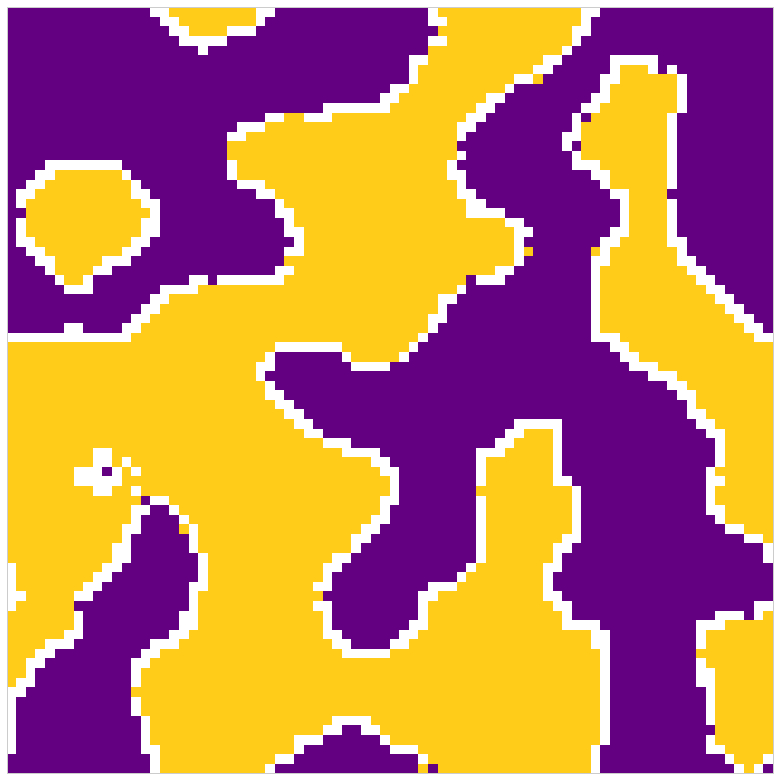

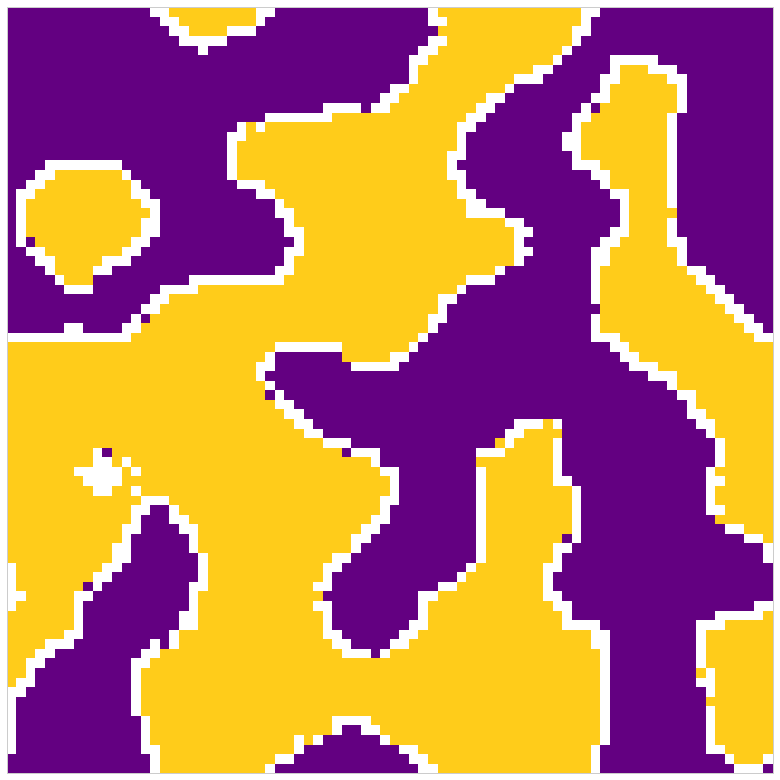

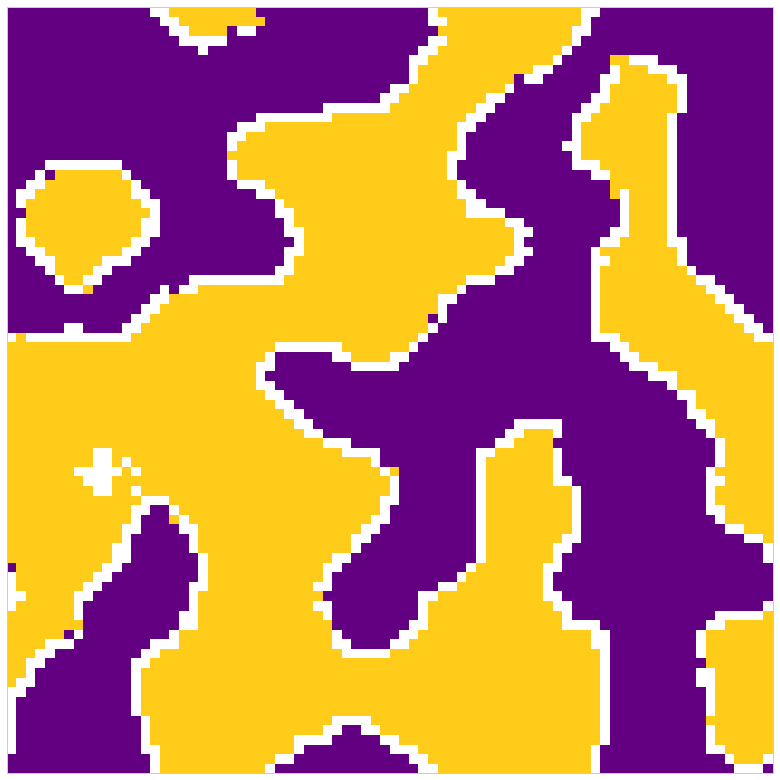

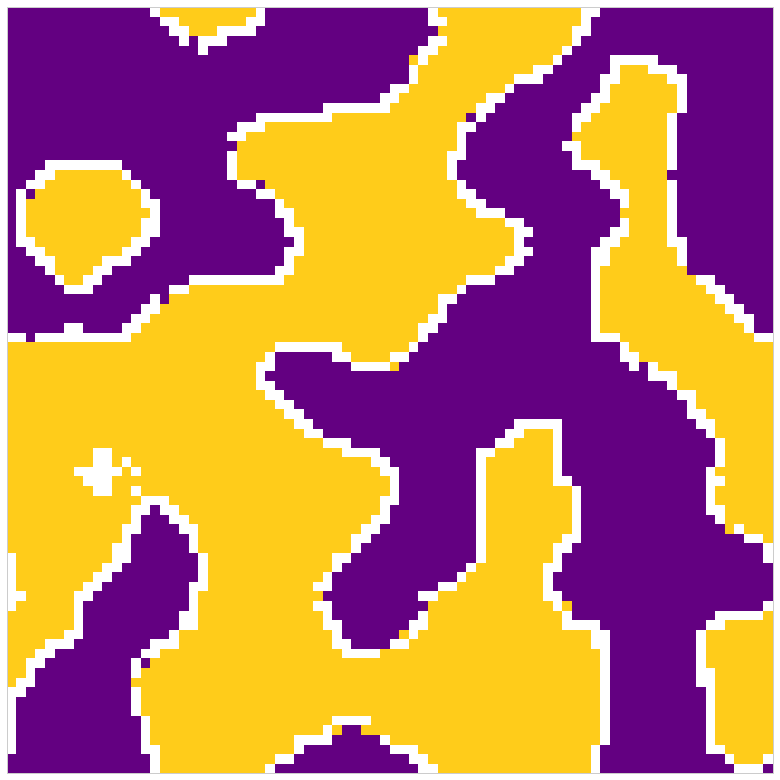

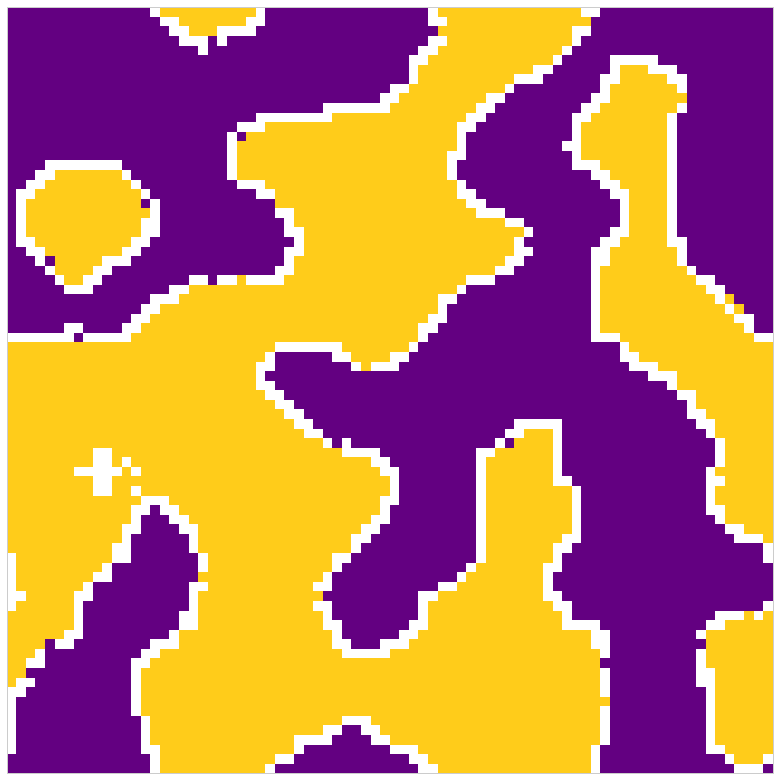

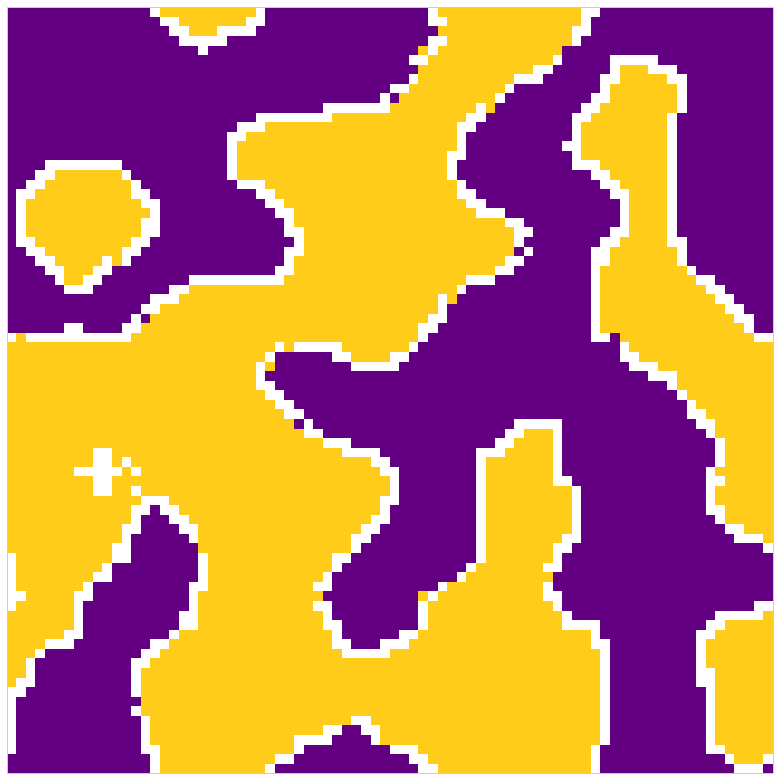

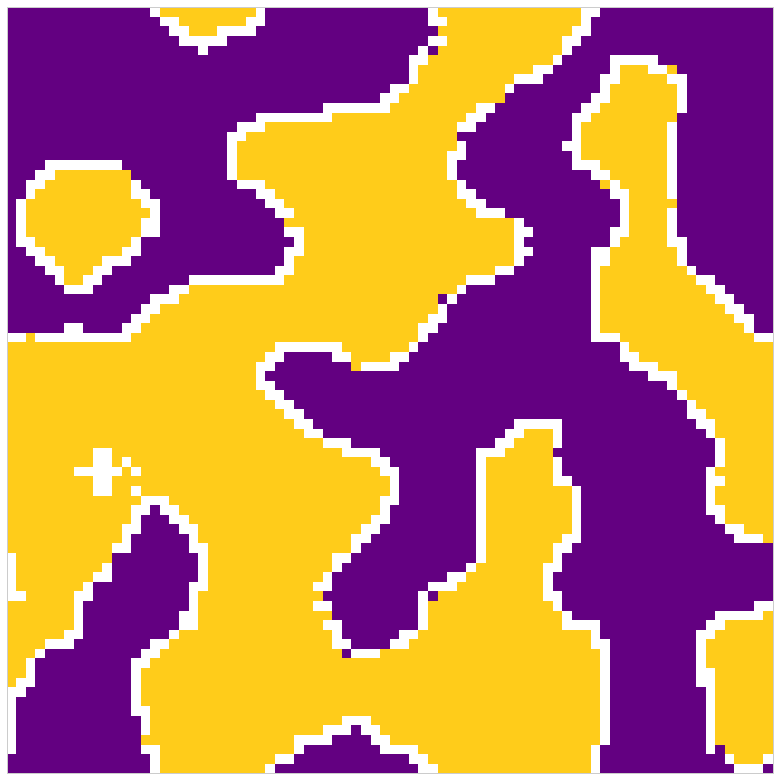

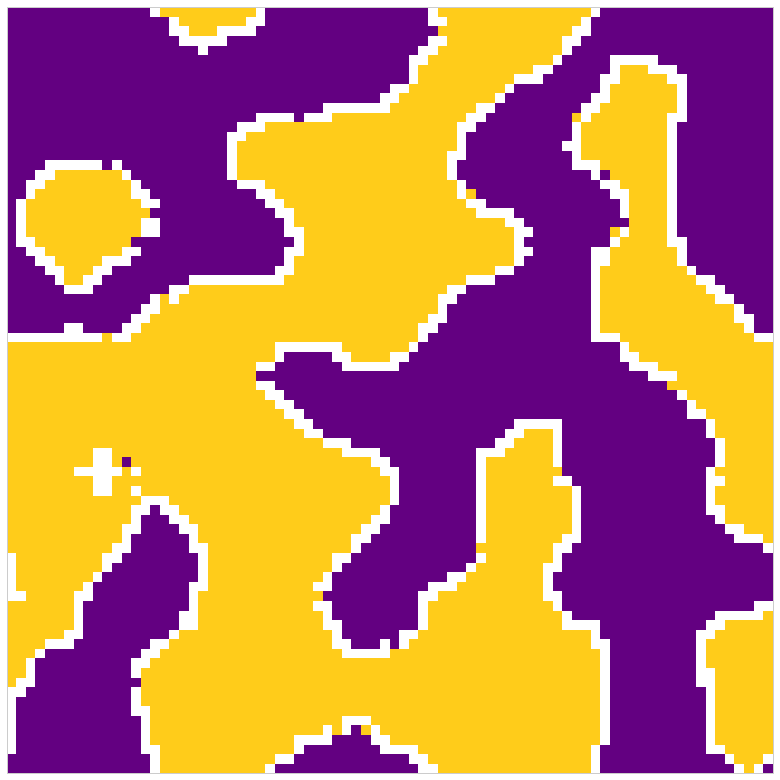

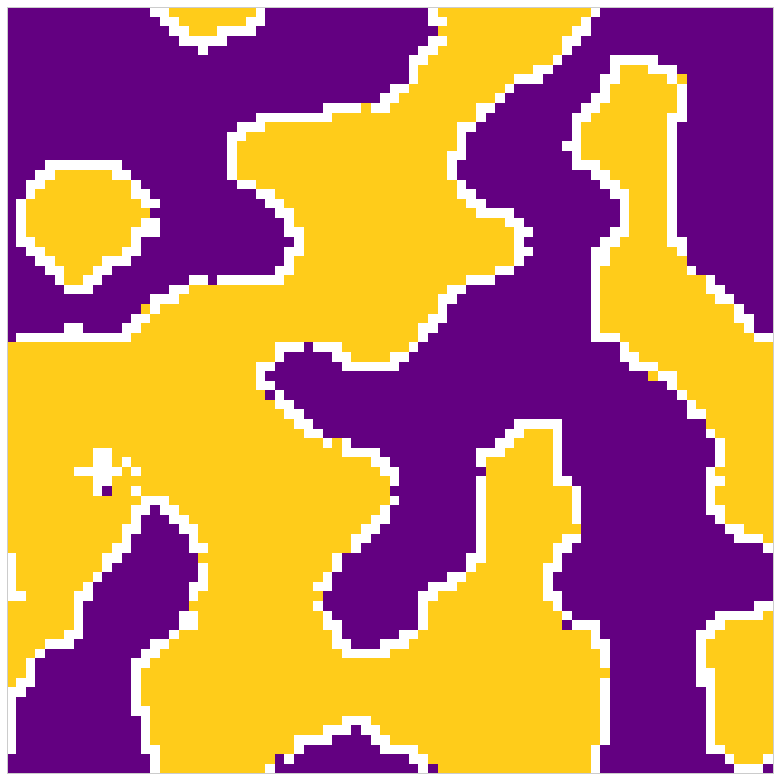

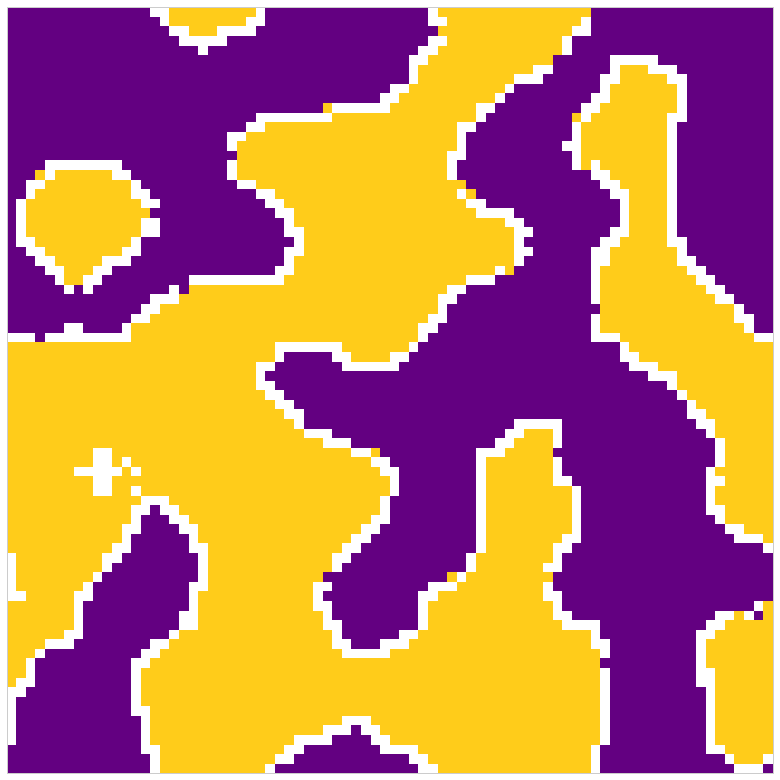

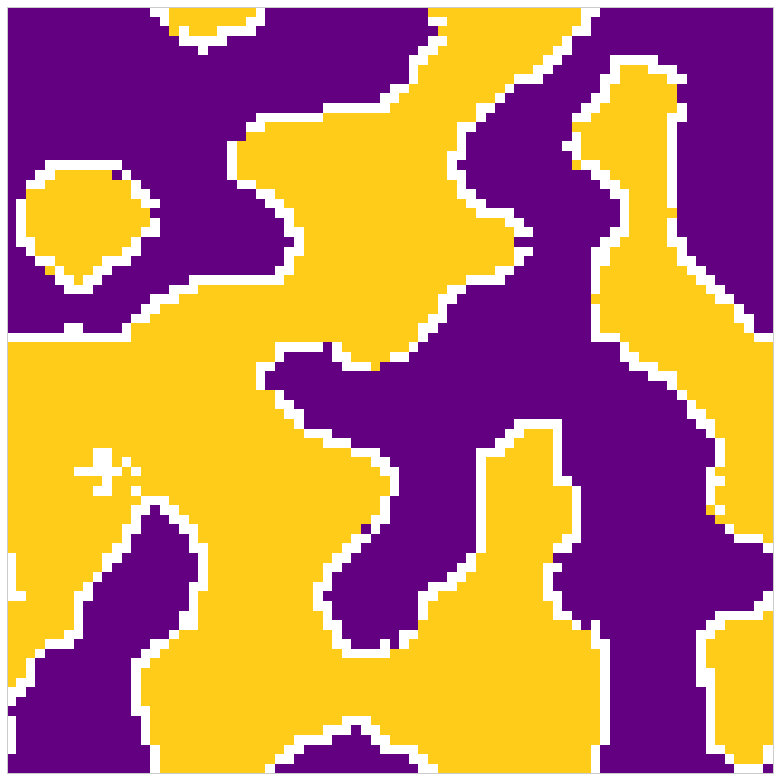

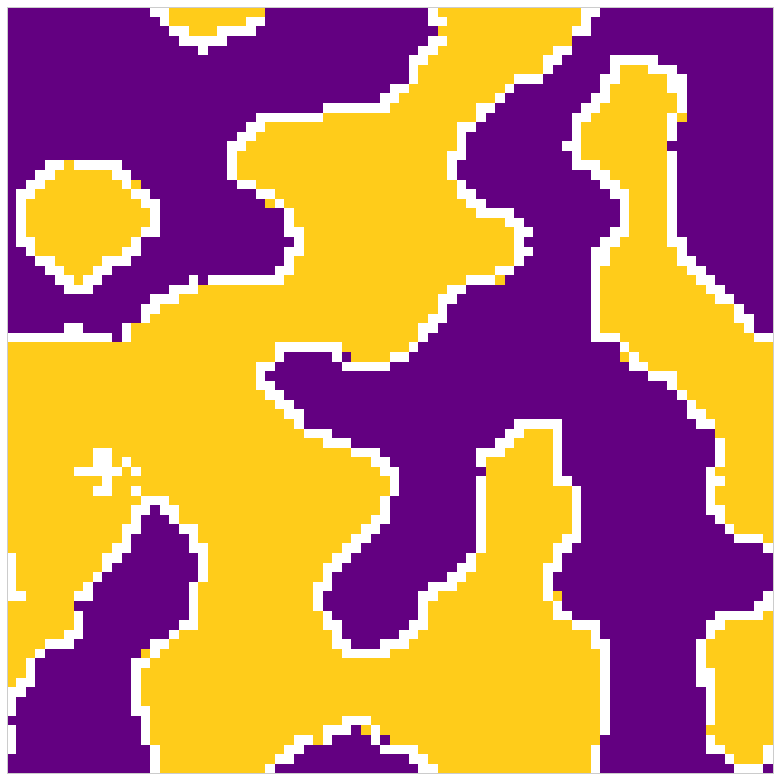

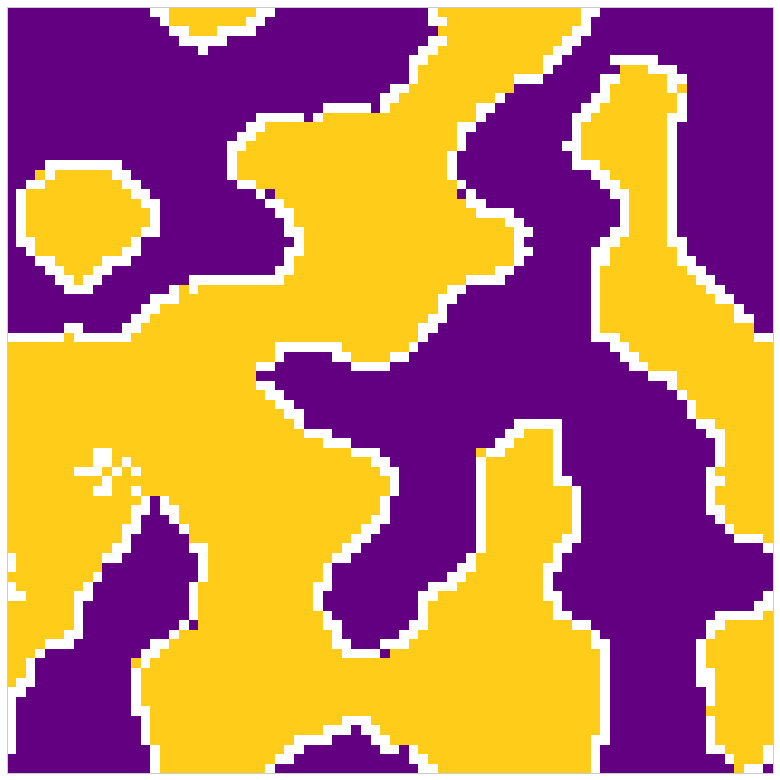

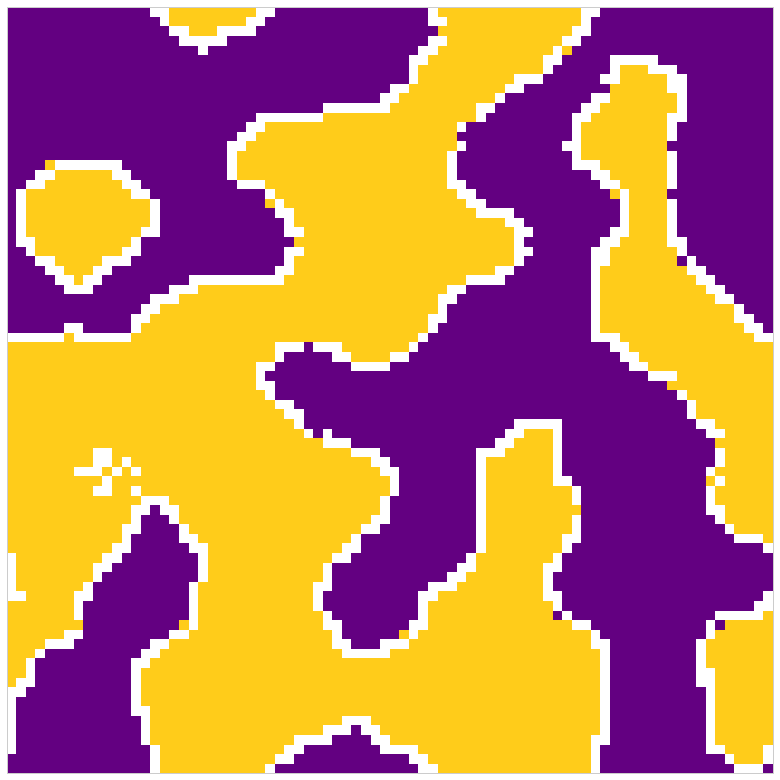

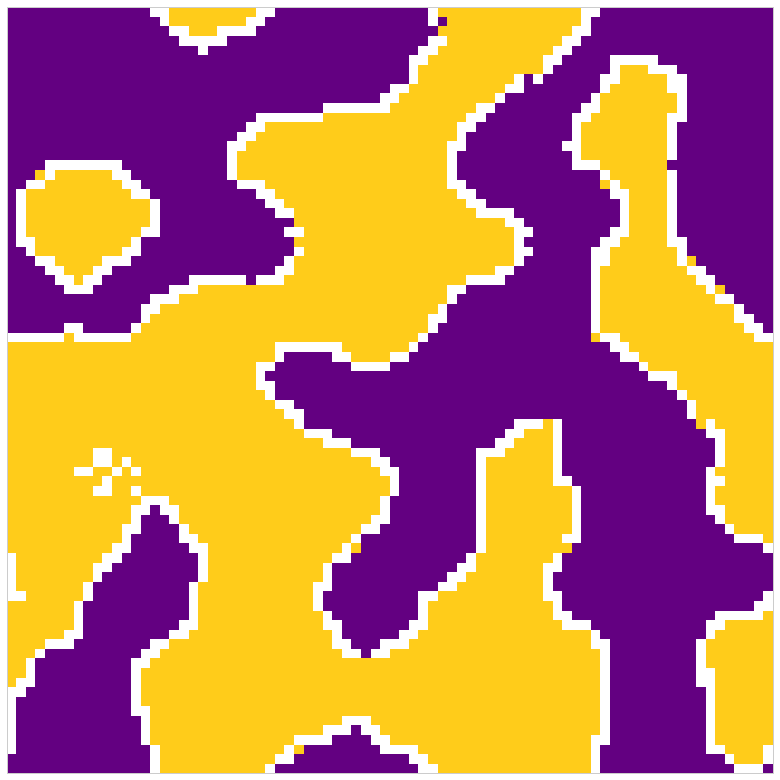

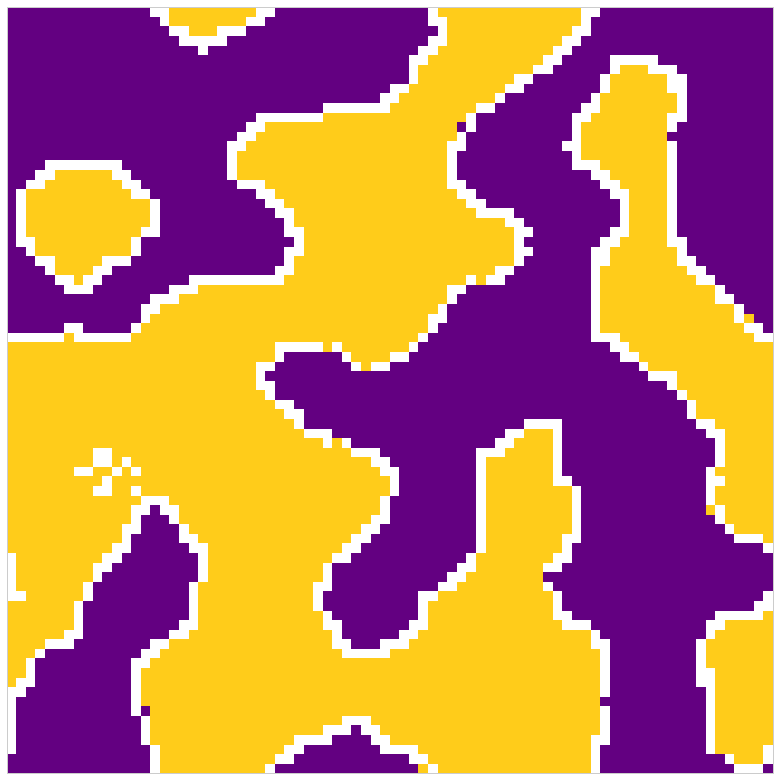

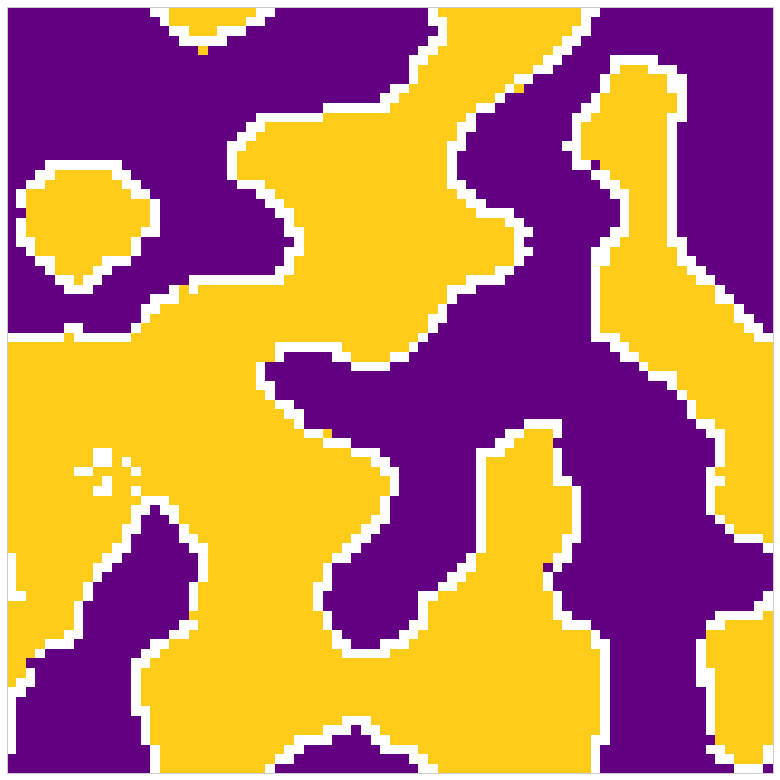

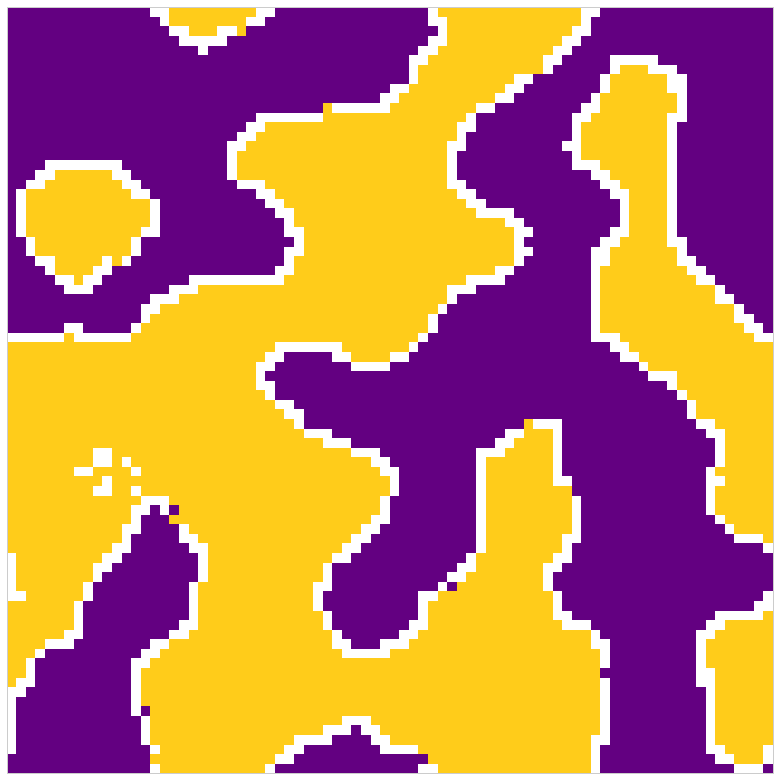

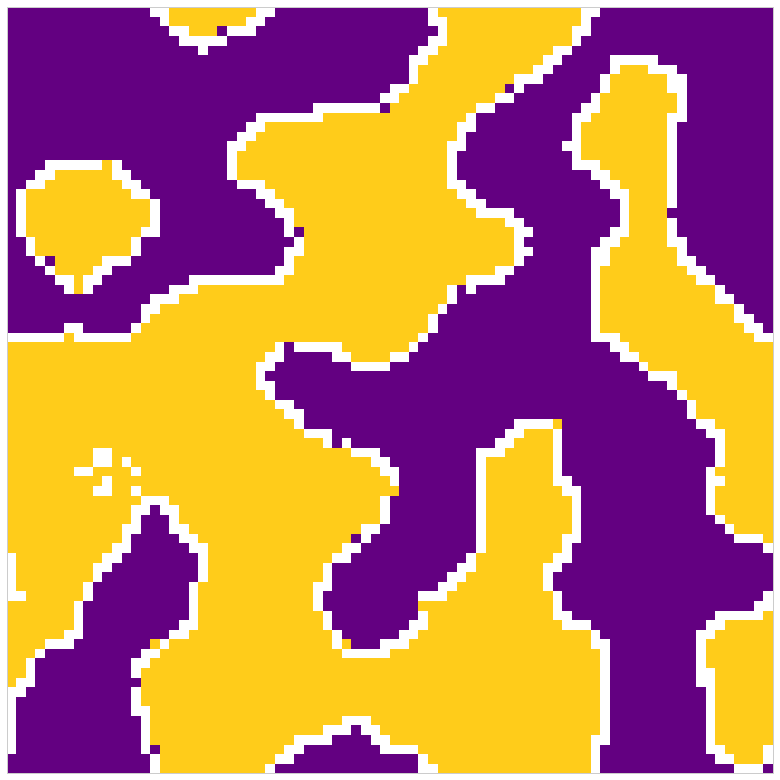

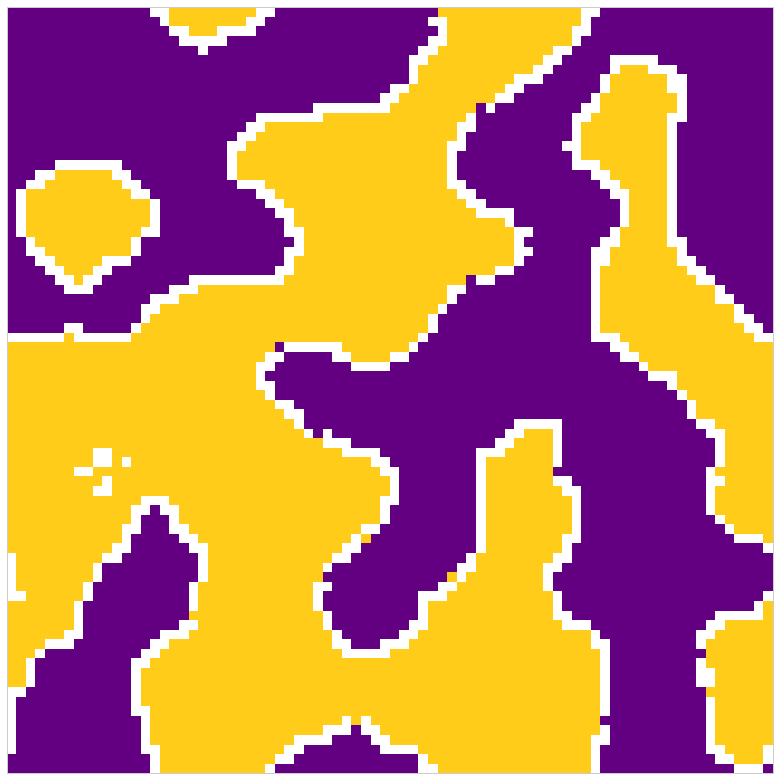

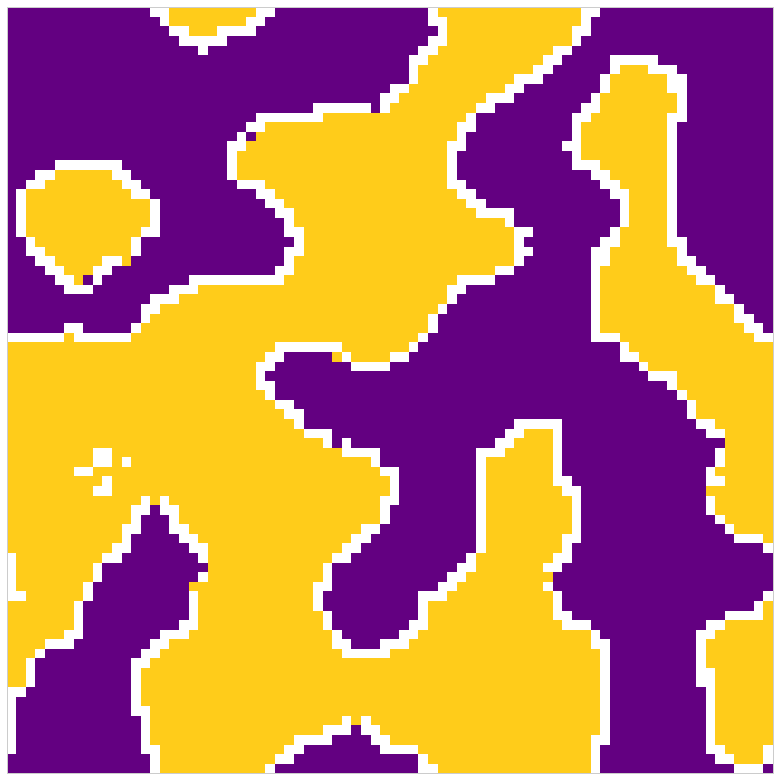

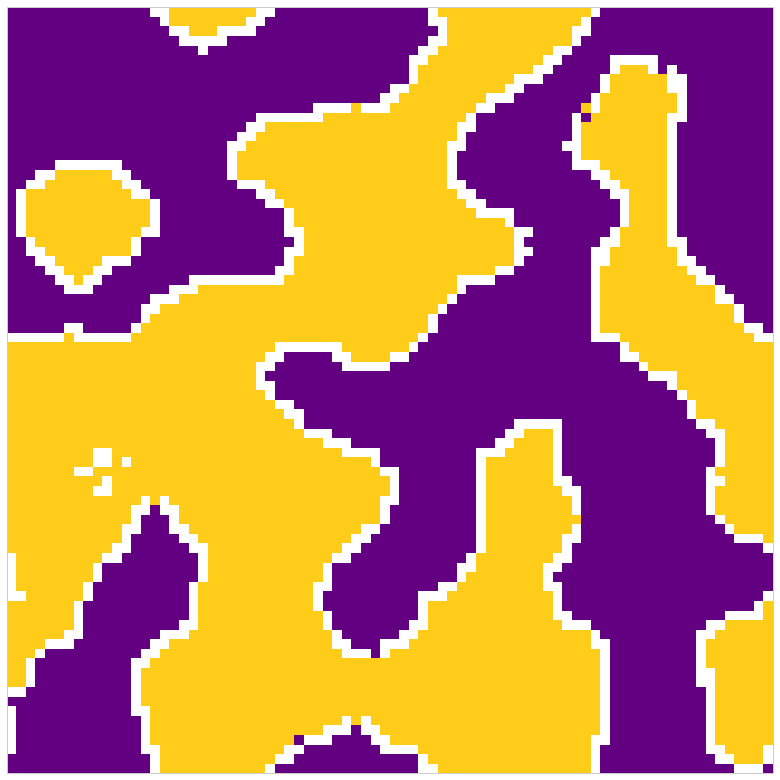

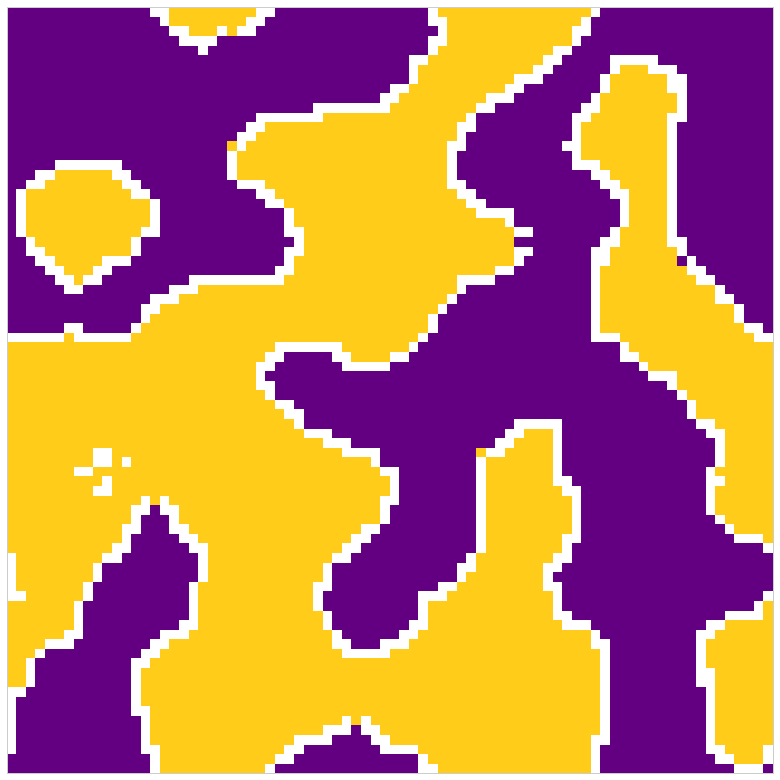

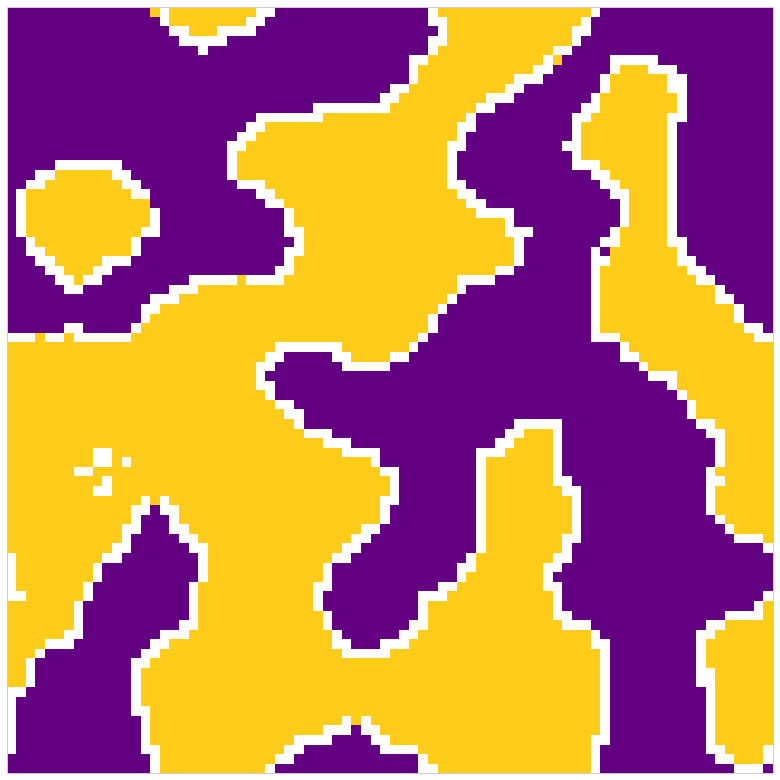

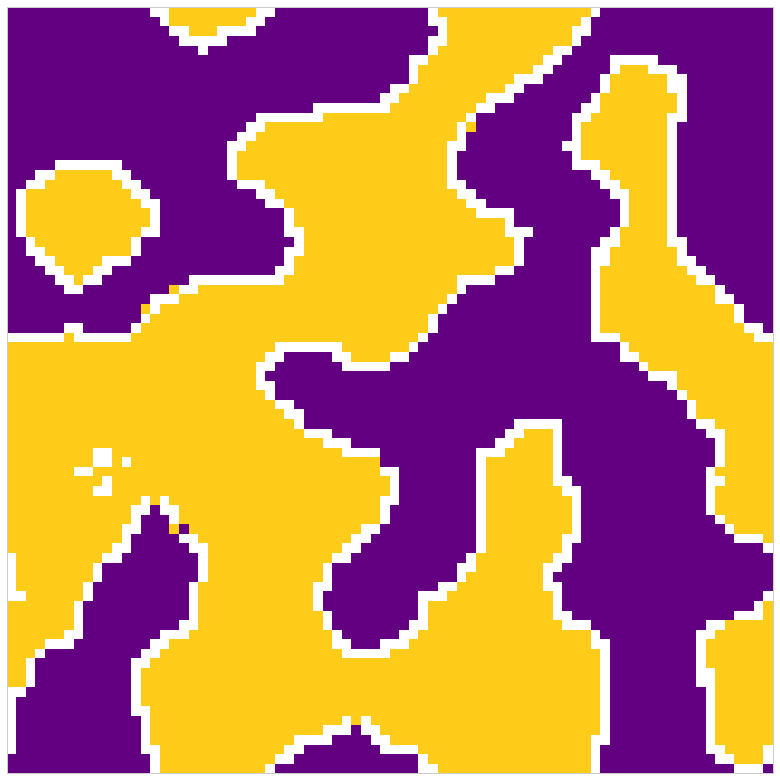

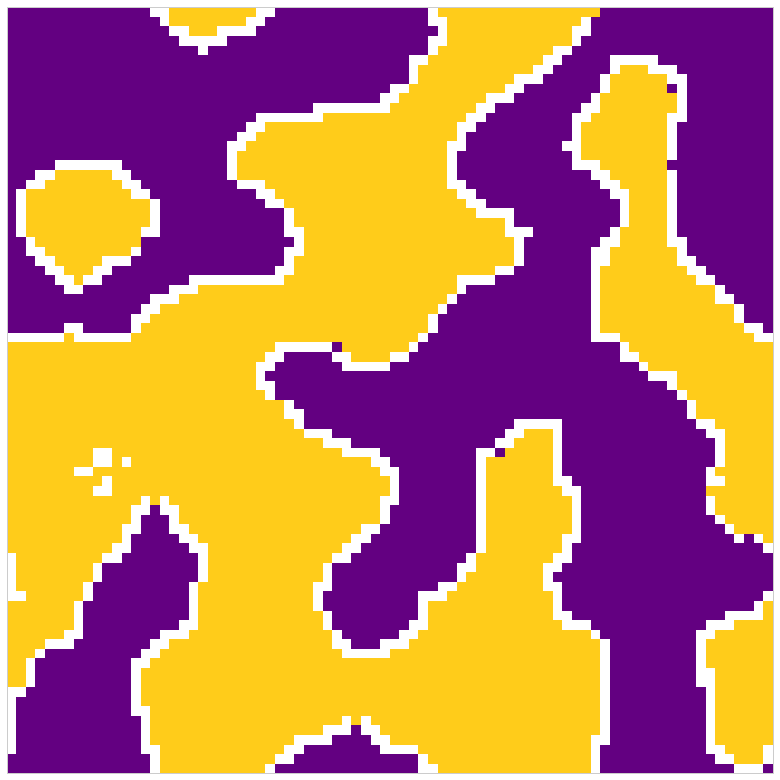

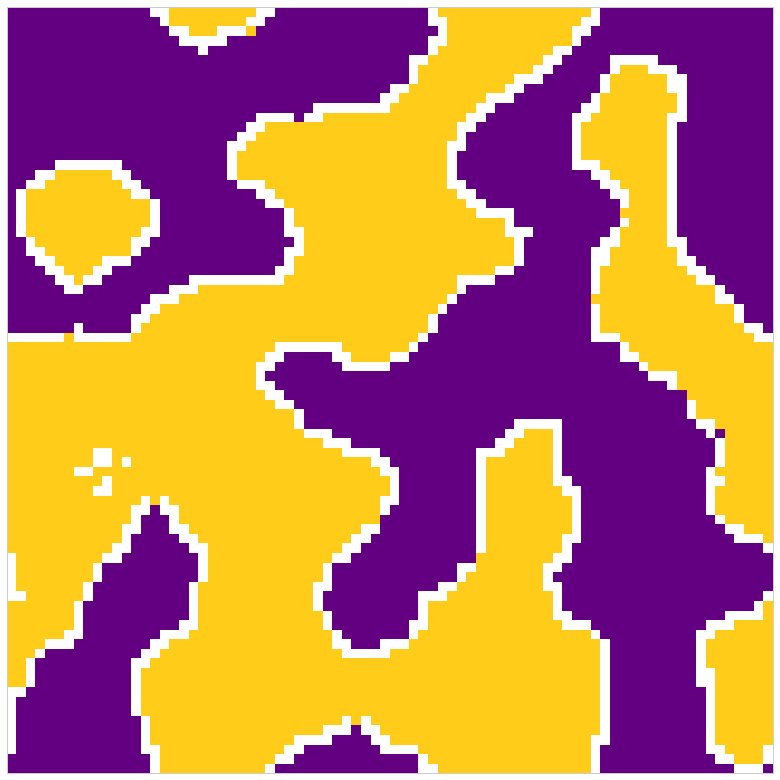

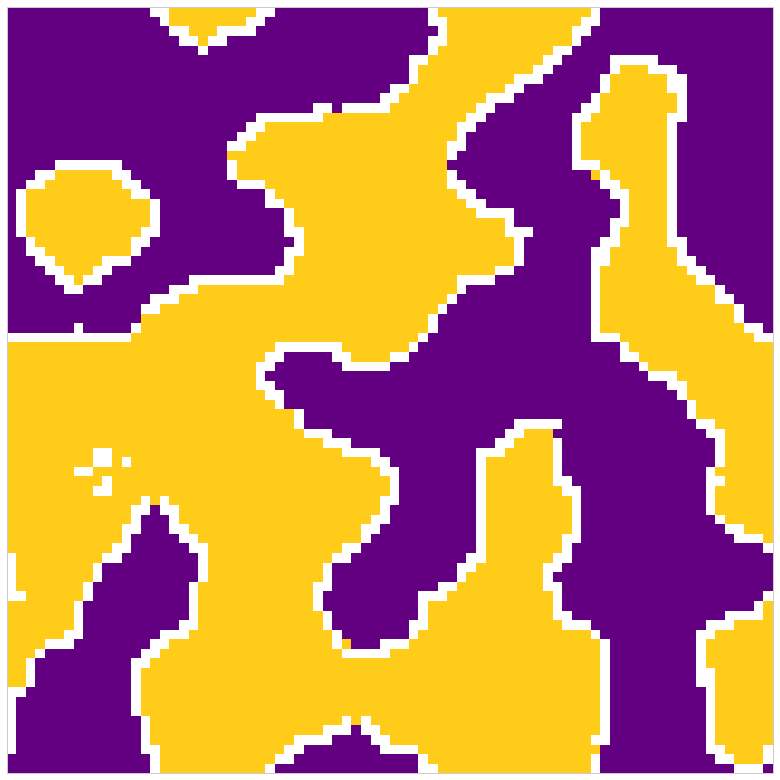

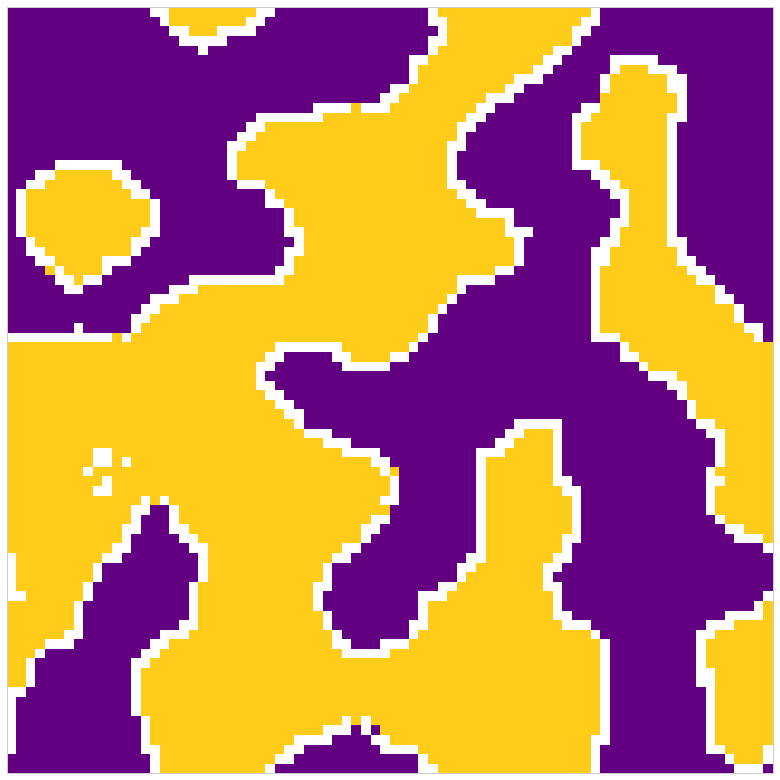

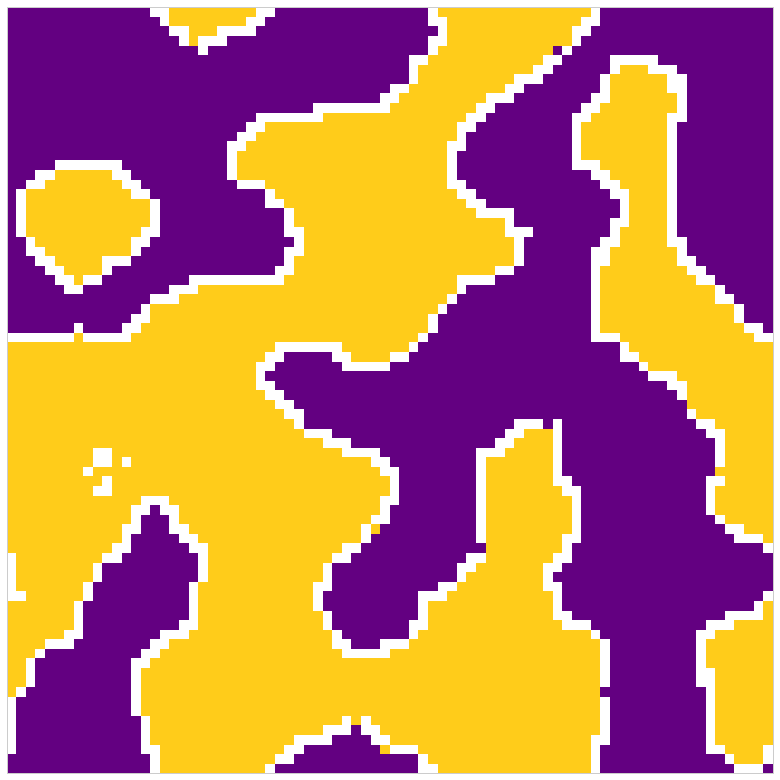

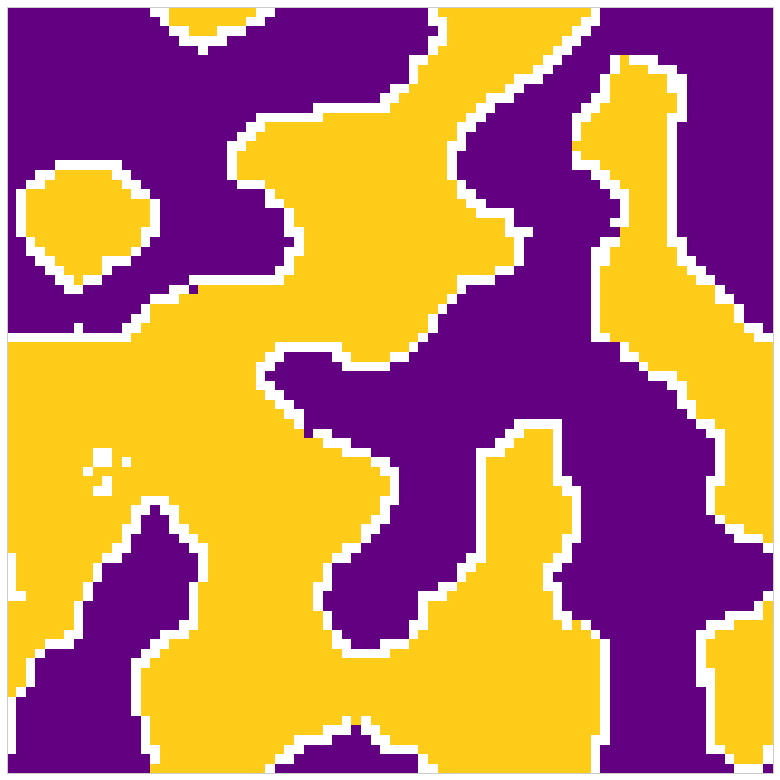

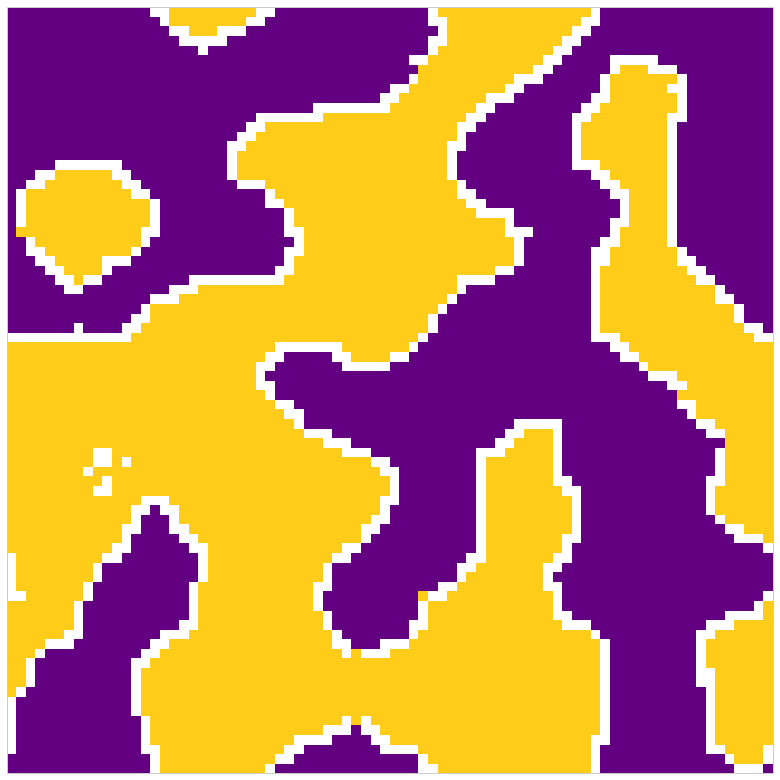

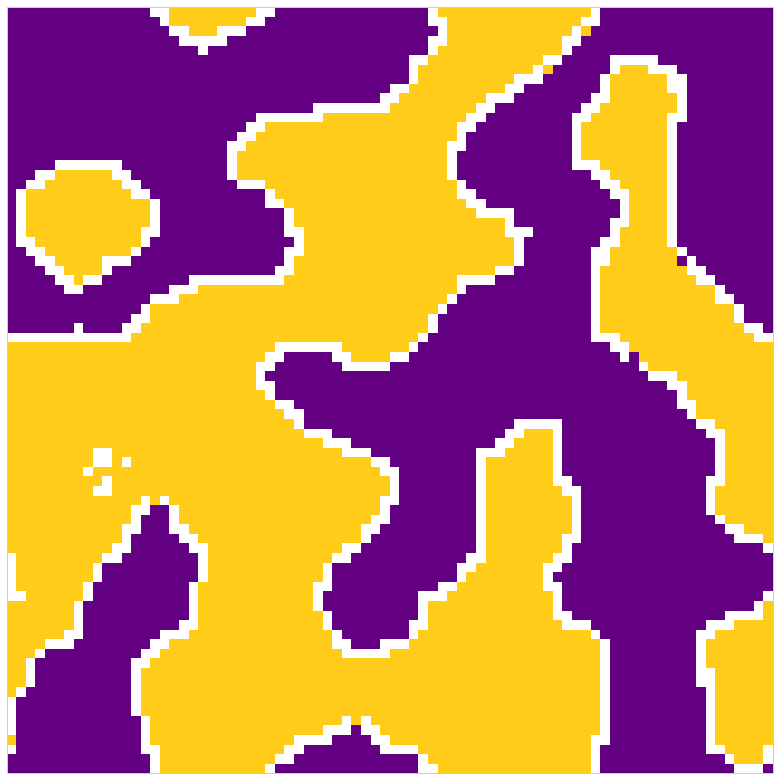

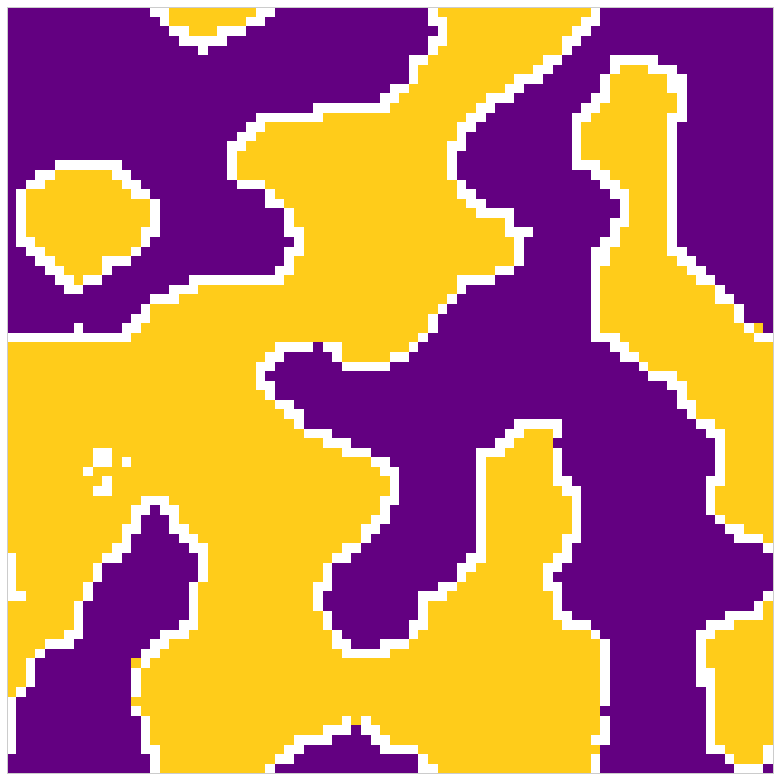

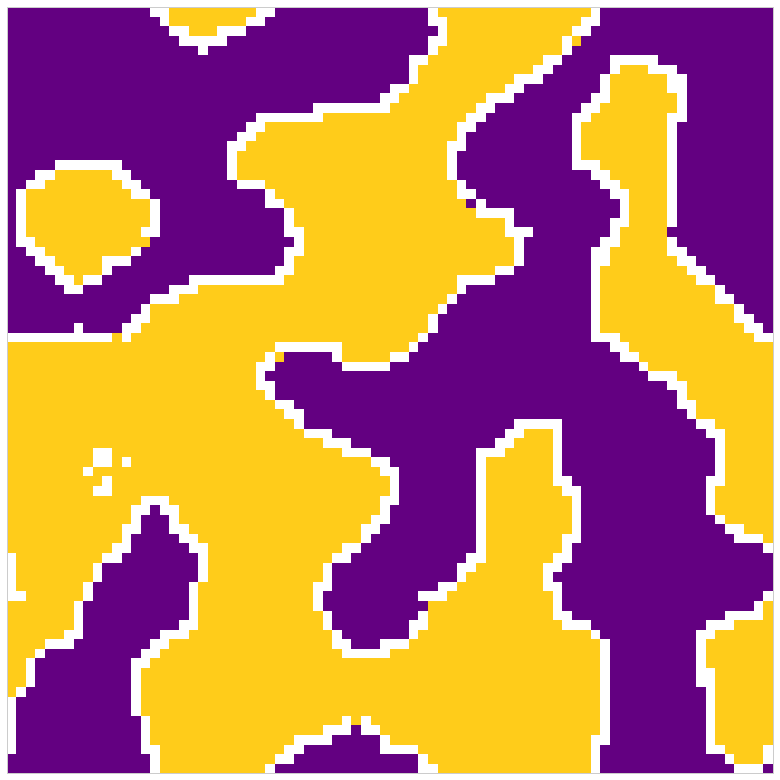

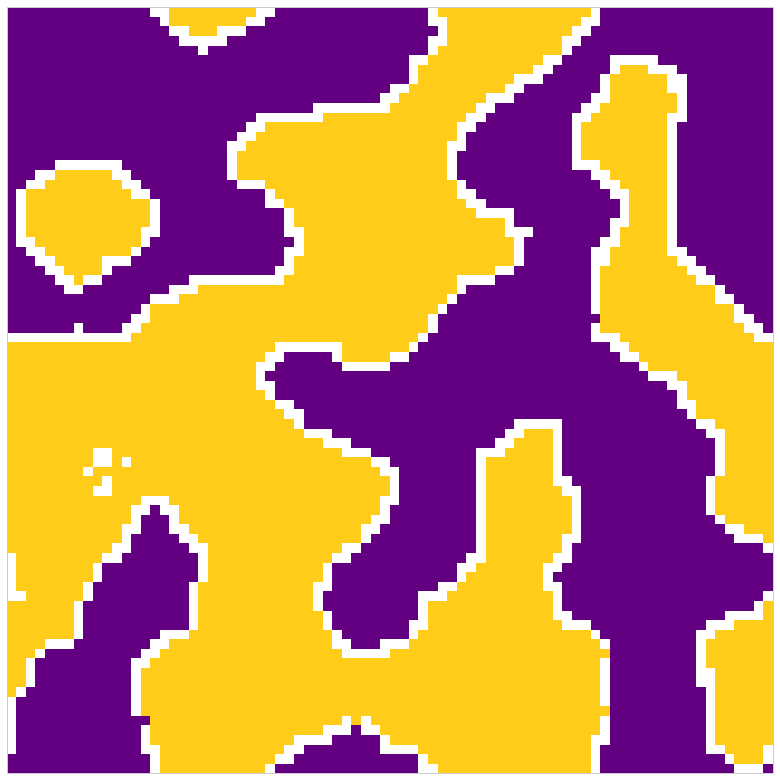

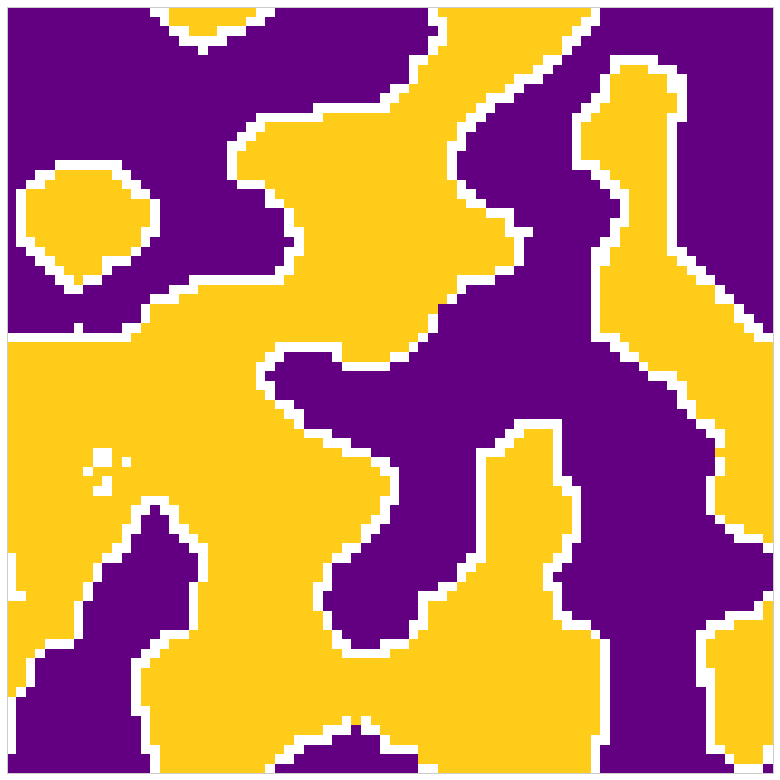

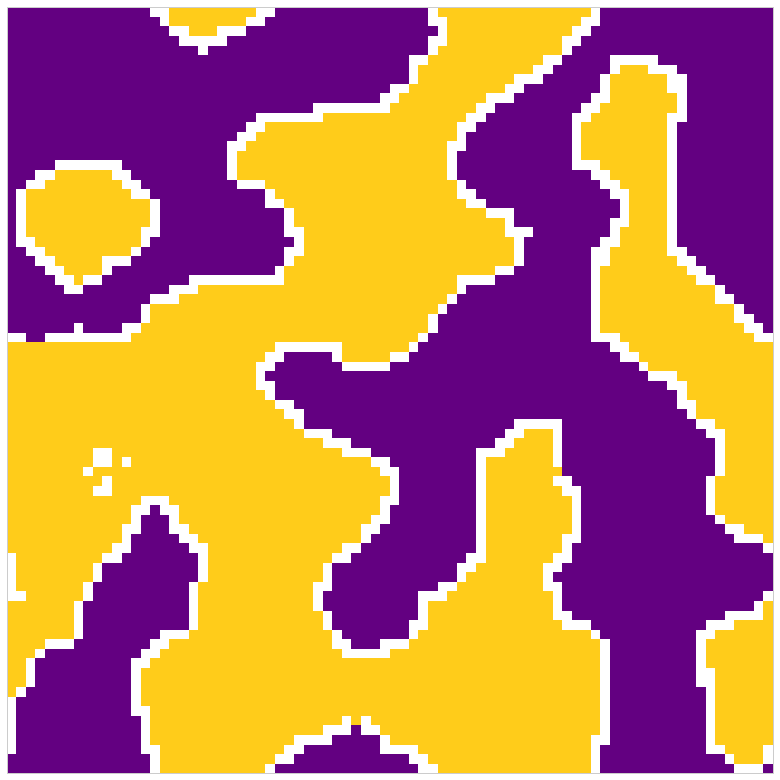

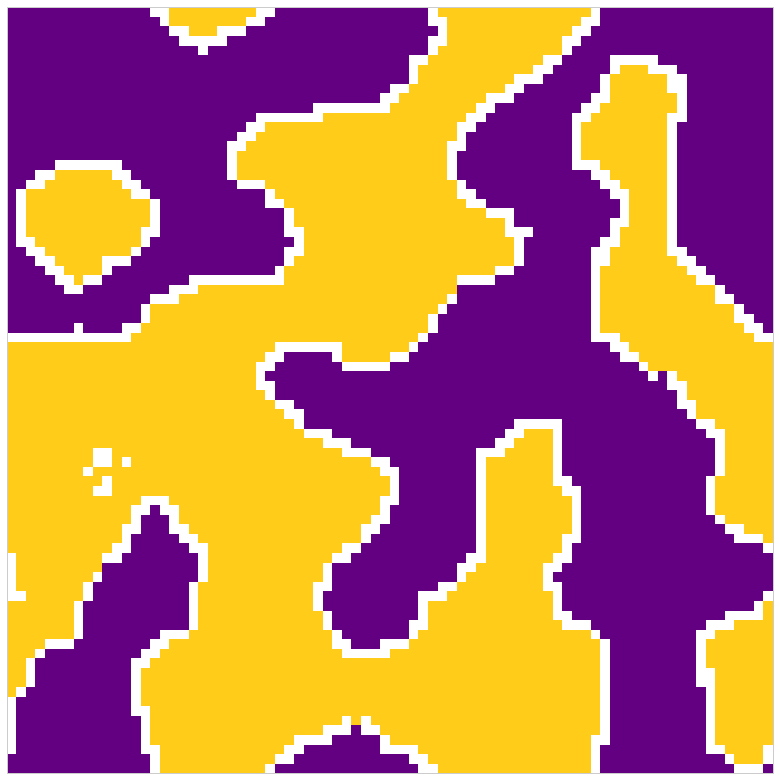

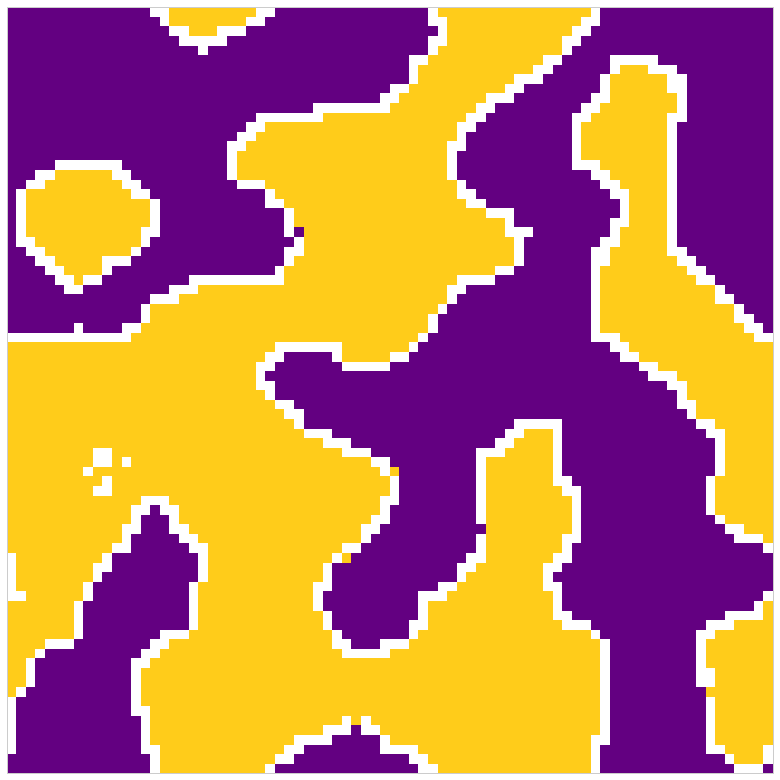

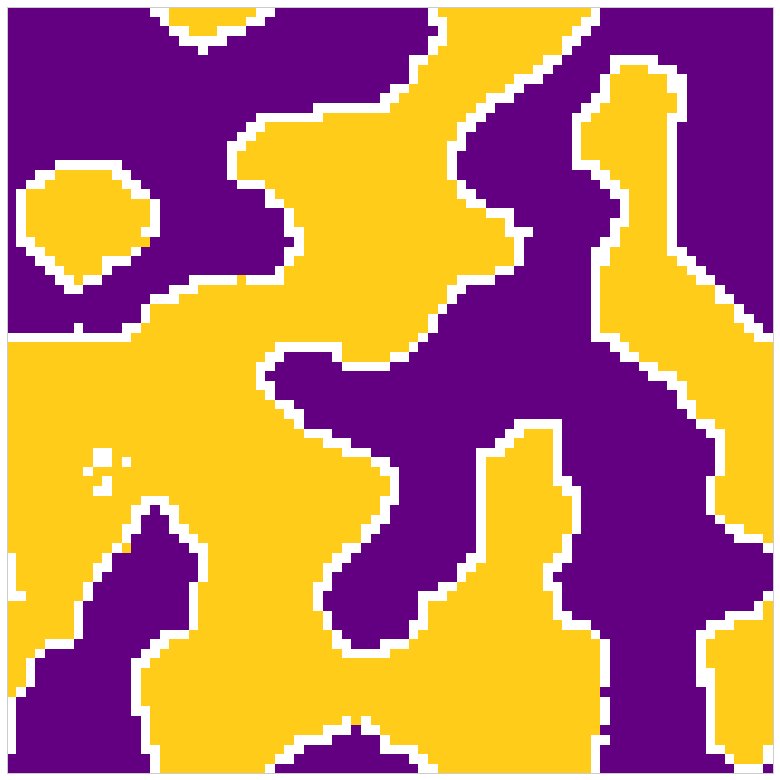

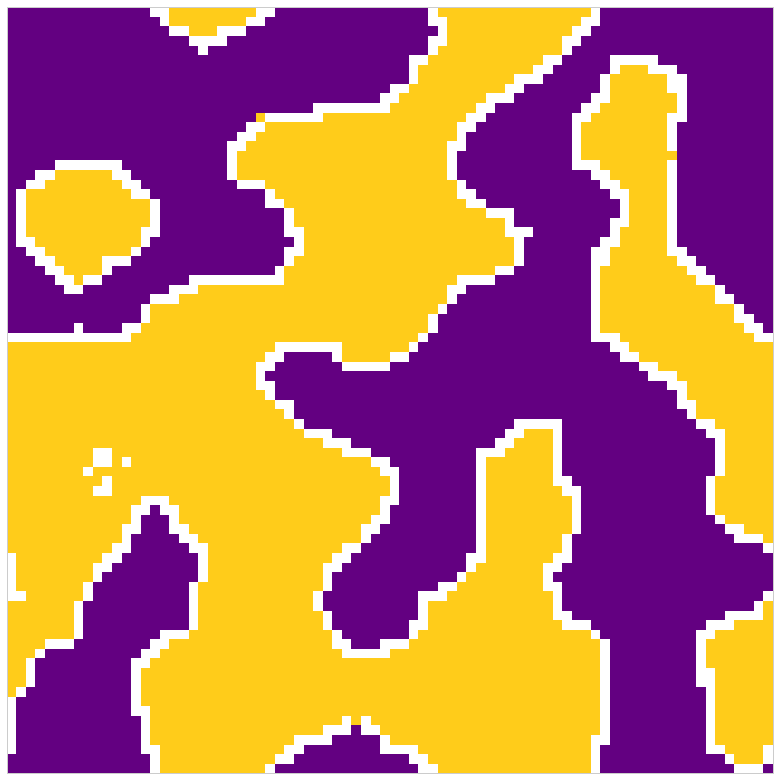

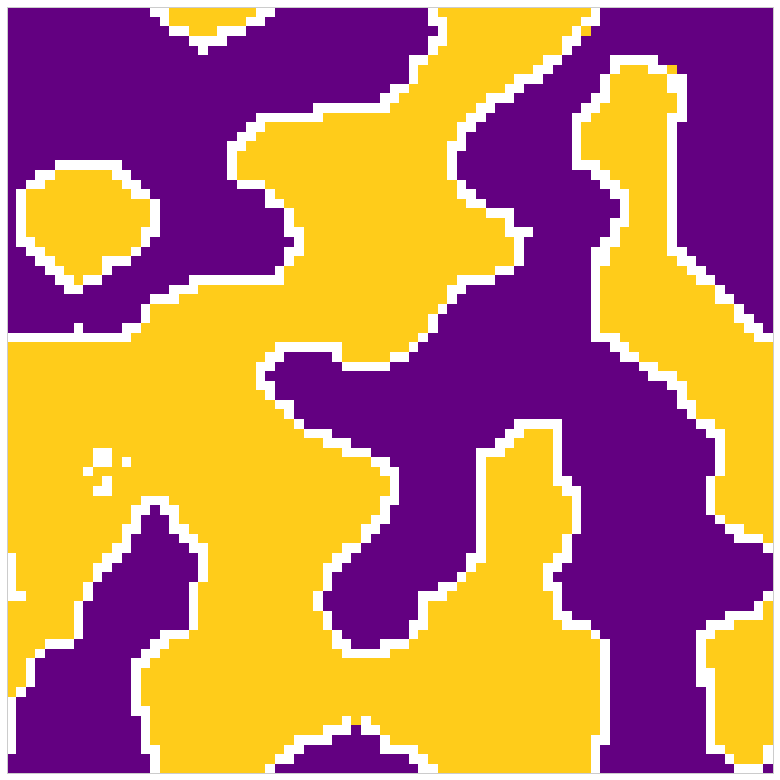

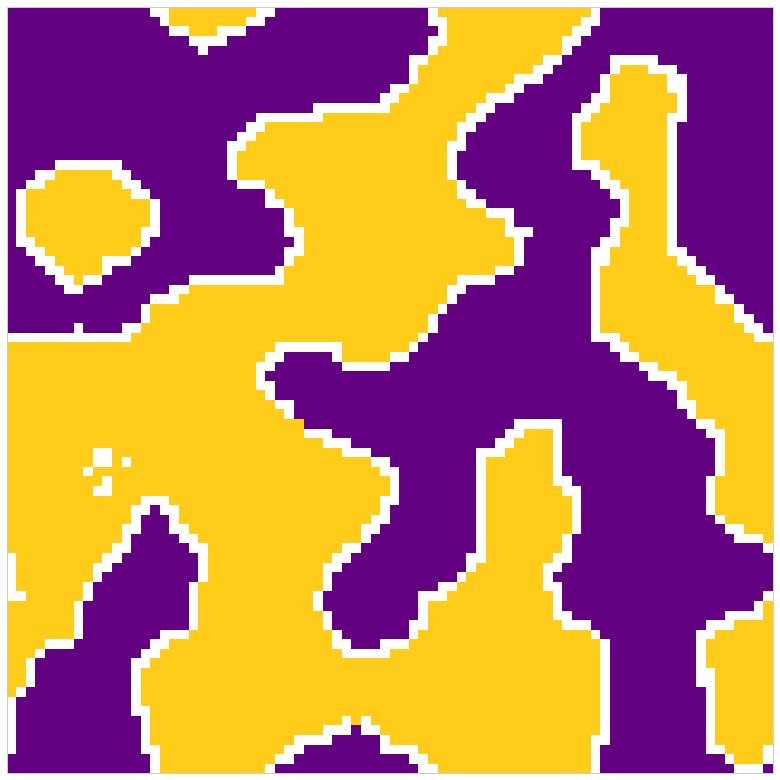

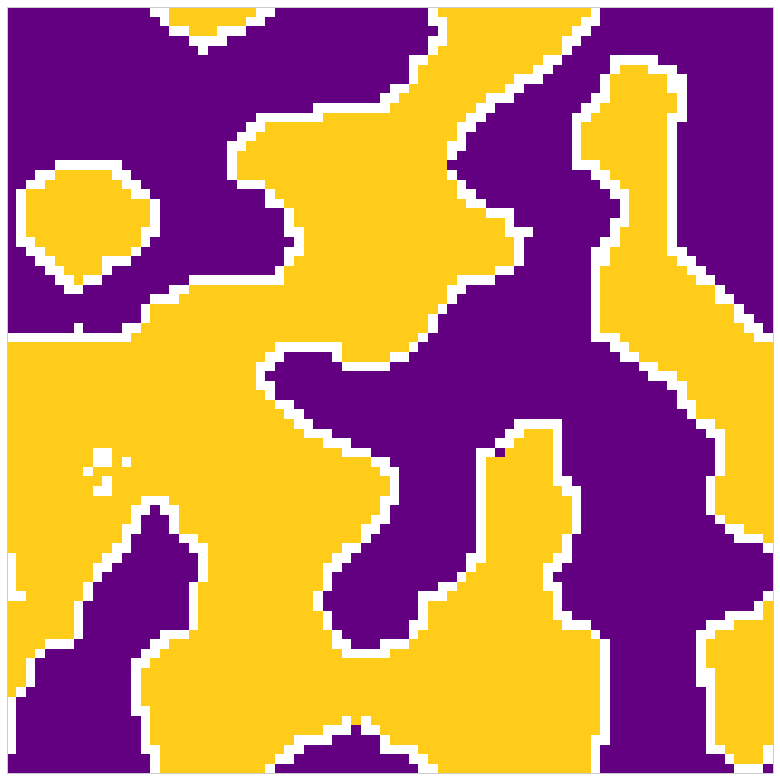

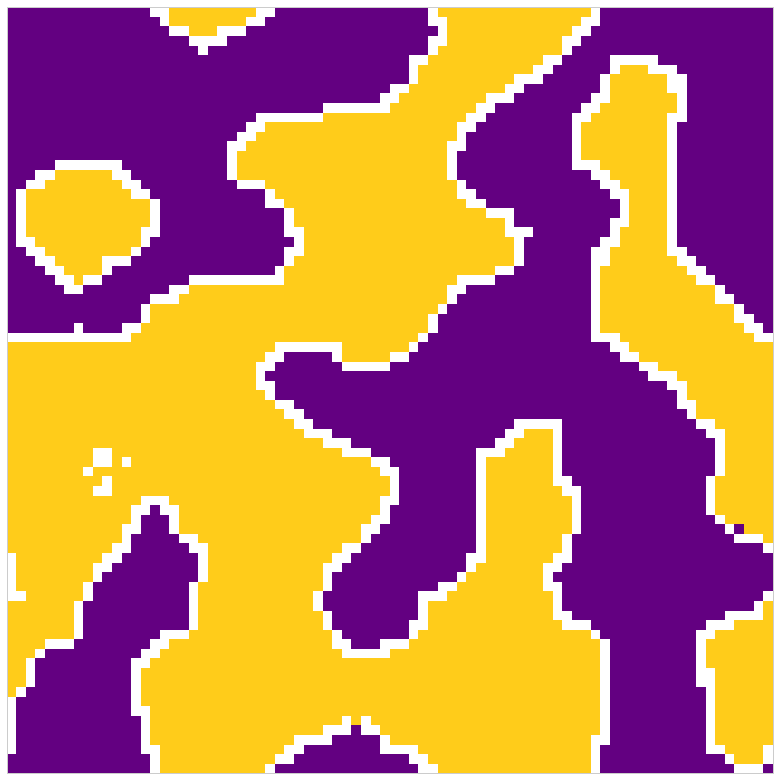

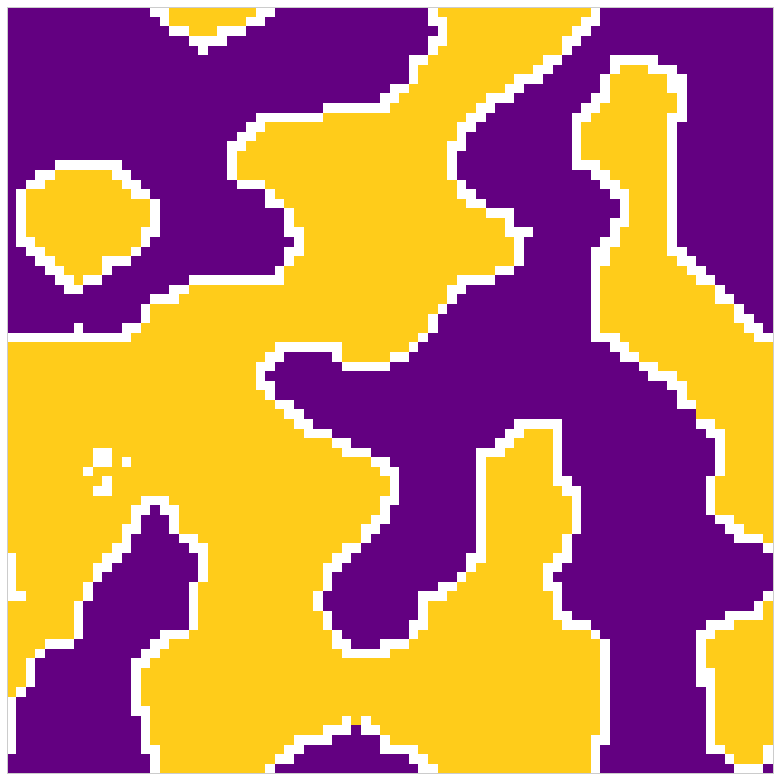

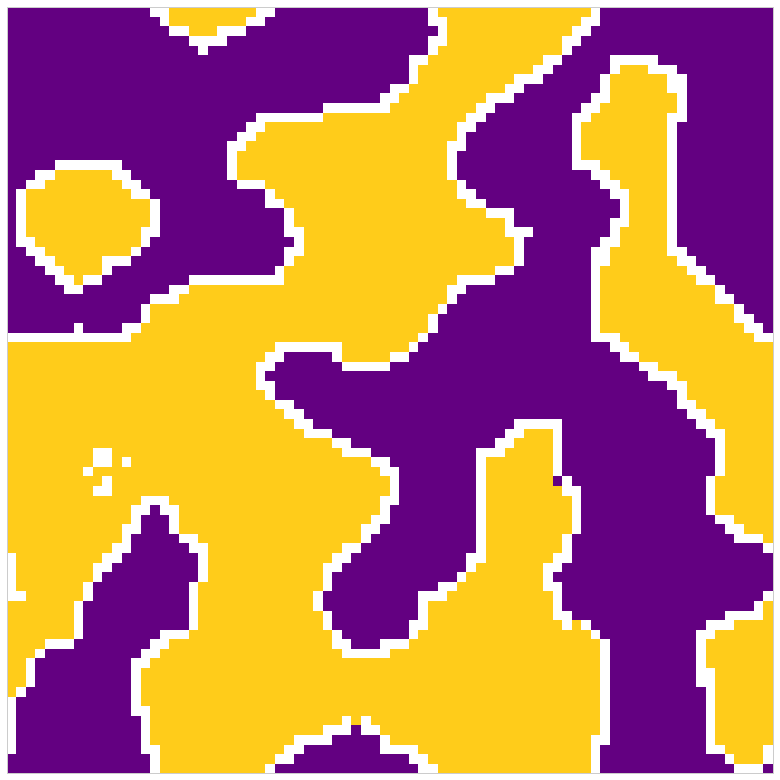

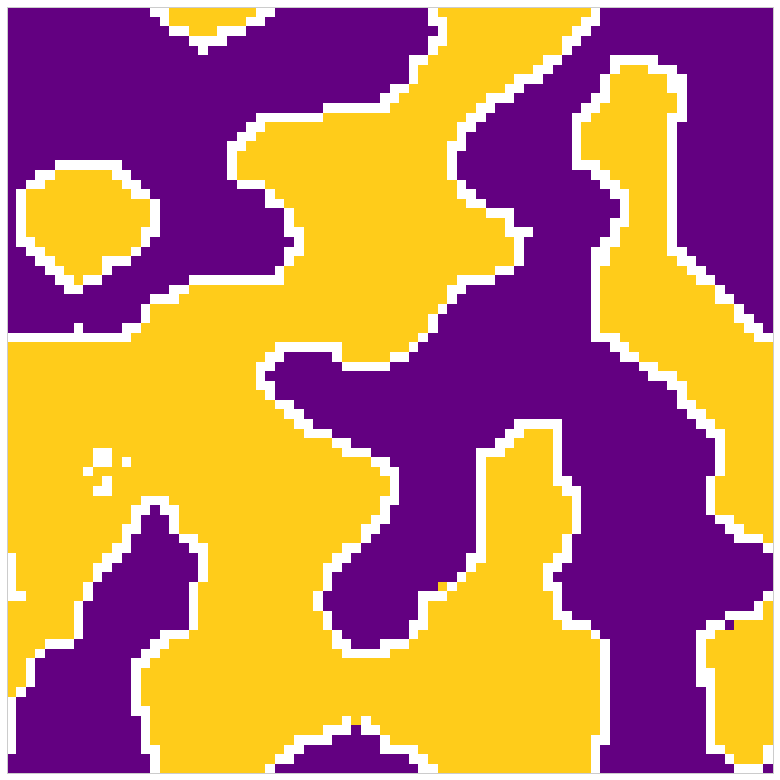

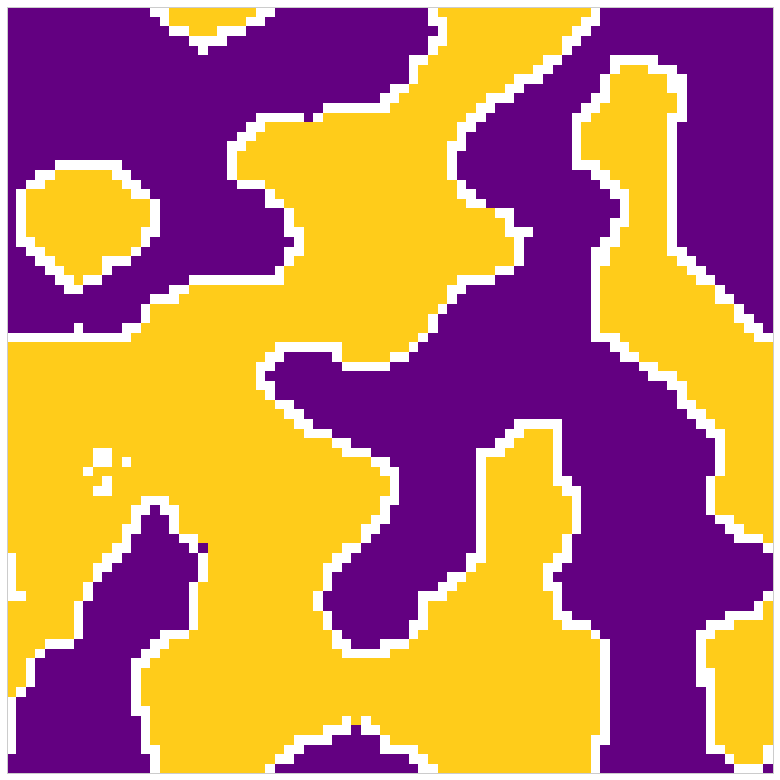

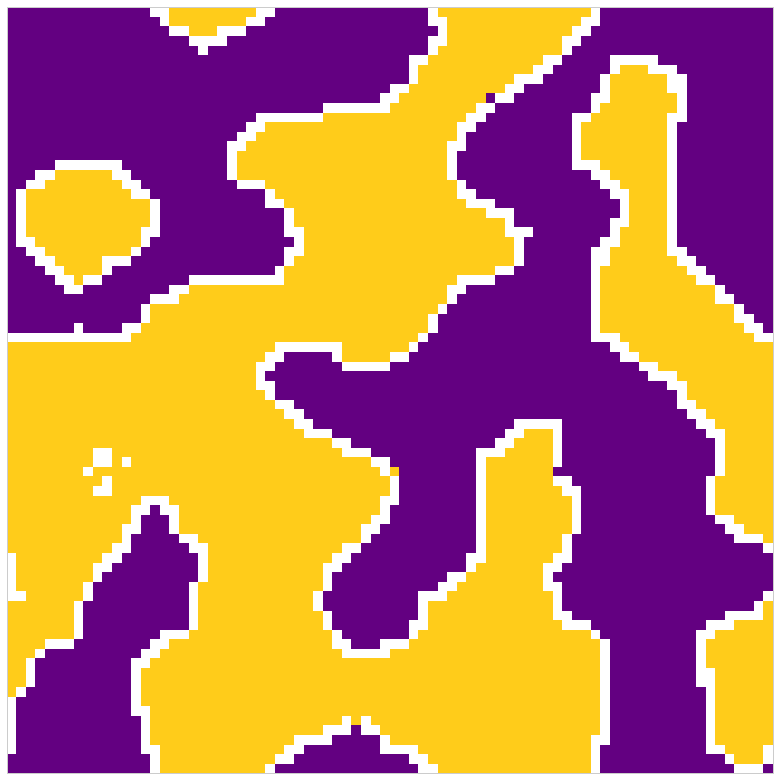

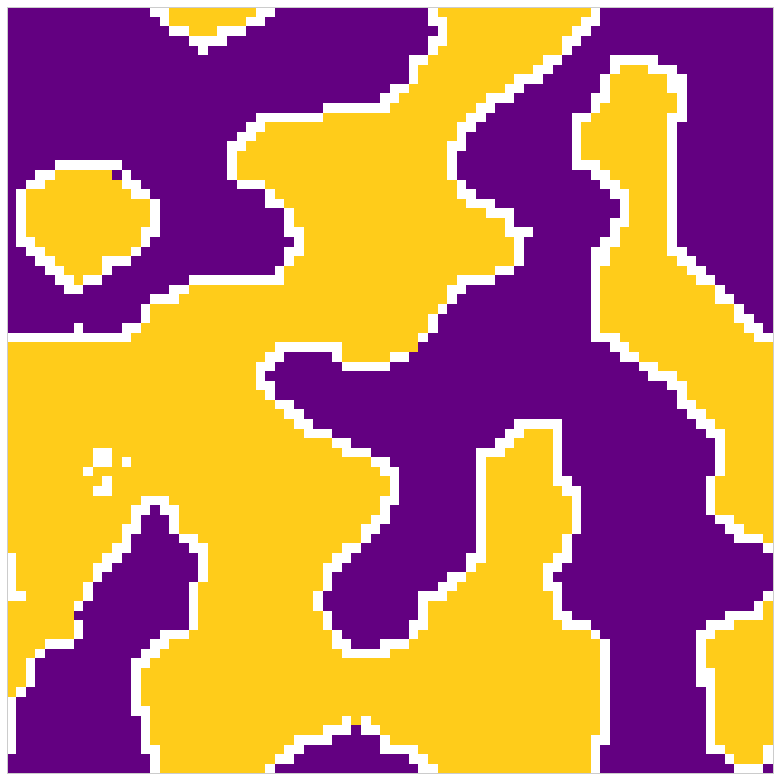

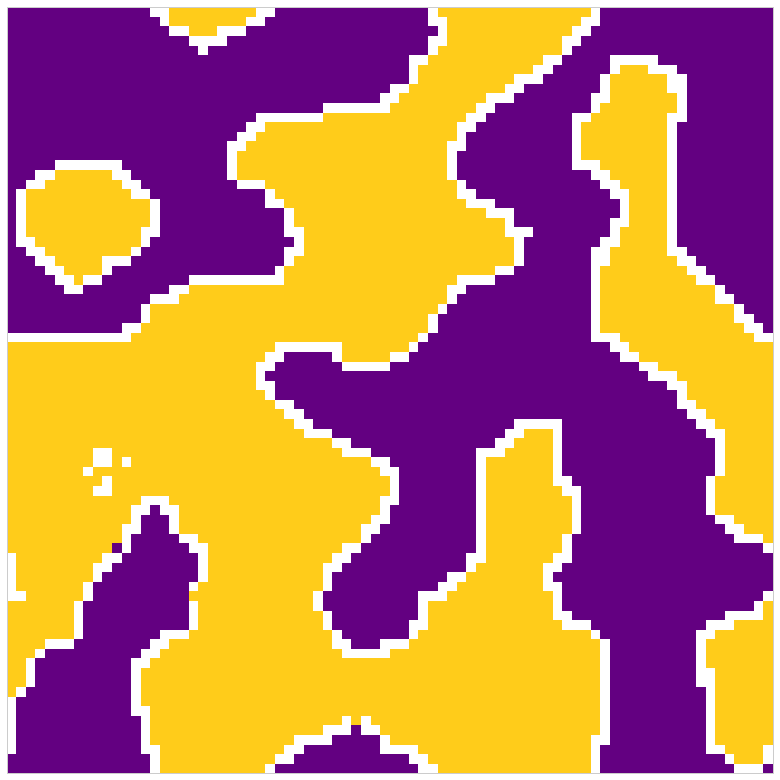

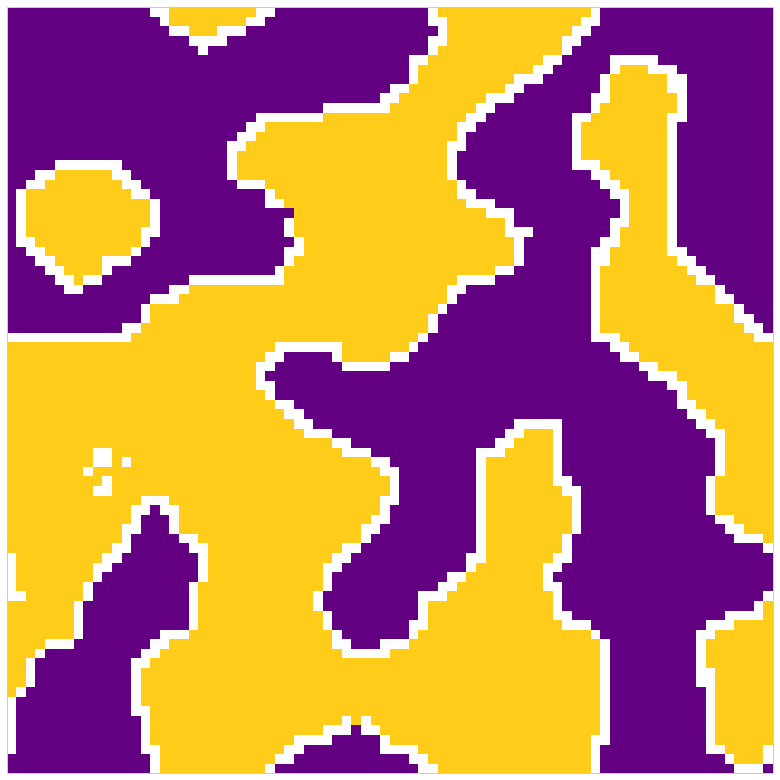

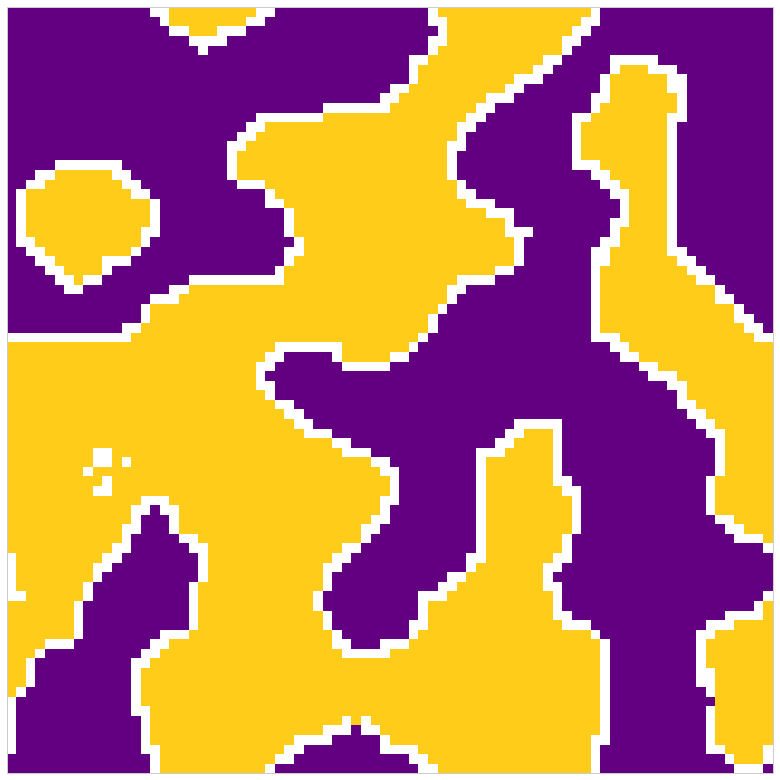

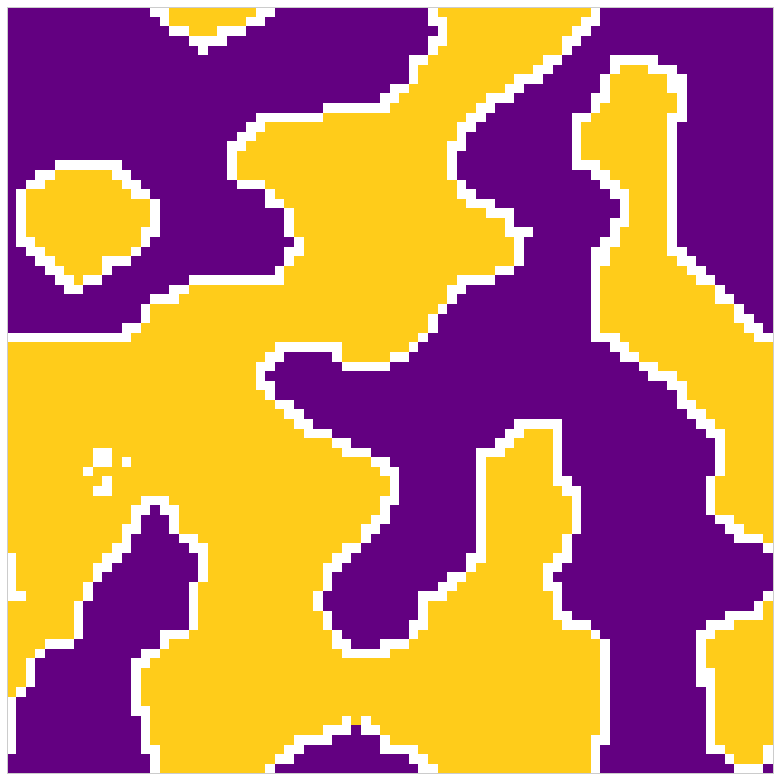

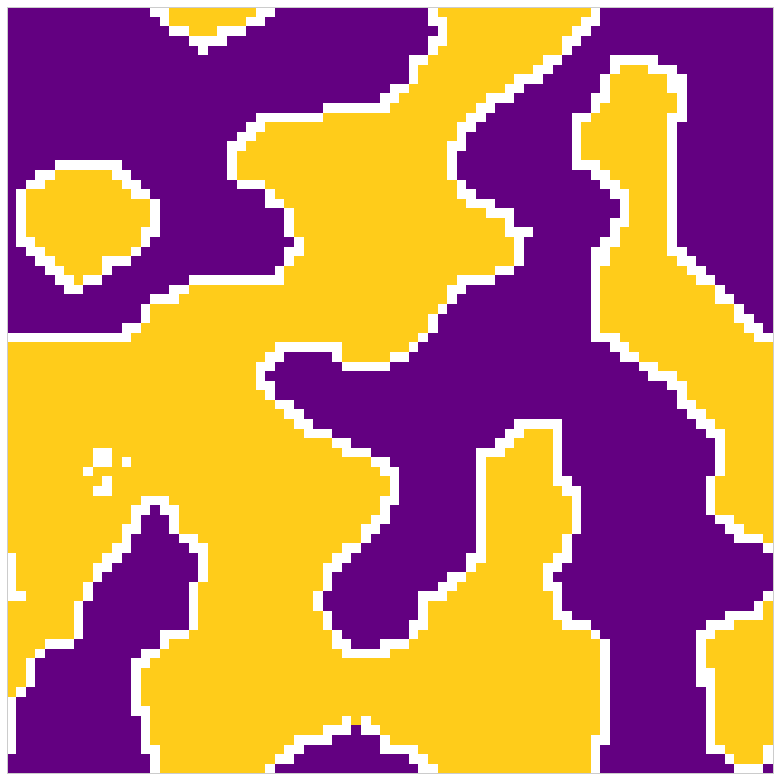

In [25]:
for turn in tqdm.tqdm(range(len(w.archived_atlases))):
    plot_atlas(w, turn);

In [49]:
np.mean(w.happiness_distribution())

0.95299581144046808

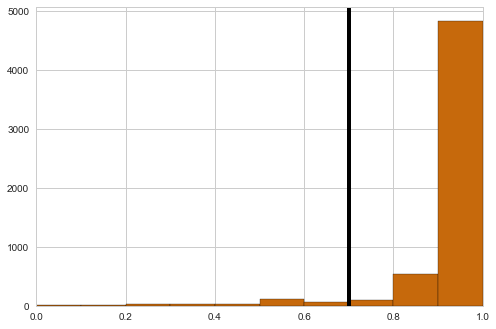

In [50]:
fig, ax = plt.subplots(1)
ax.hist(w.happiness_distribution(), edgecolor='black')
ymin, ymax = ax.get_ylim()
ax.vlines(0.7, ymin, ymax, linewidth=4)
ax.set_ylim(ymin, ymax)
ax.set_xlim(0, 1)
fig.savefig('happynessdist_after')